In [ ]:
import os
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from parse import *
import seaborn as sns

In [ ]:
CHUNKSIZE = 100000

TRAIN_PATH        = "../train_StationPathInfo.csv"
TRAIN_PATH_EX     = "../train_StationPathInfoEx.csv"
TEST_PATH         = "../test_StationPathInfo.csv"
TEST_PATH_EX      = "../test_StationPathInfoEx.csv"

TRAIN_DATE        = "../train_date.csv"
TRAIN_NUMERIC     = "../train_numeric.csv"
TRAIN_CATEGORICAL = "../train_categorical.csv"
TEST_DATE         = "../test_date.csv"
TEST_NUMERIC      = "../test_numeric.csv"
TEST_CATEGORICAL  = "../test_categorical.csv"

SEED = 0
CHUNKSIZE = 50000
NROWS = 1200000

ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'
    
    

In [3]:
chunk_train_num = pd.read_csv(TRAIN_NUMERIC, nrows=NROWS, chunksize=CHUNKSIZE)
chunk_test_num  = pd.read_csv(TEST_NUMERIC, nrows=NROWS, chunksize=CHUNKSIZE)
chunk_train_cat = pd.read_csv(TRAIN_CATEGORICAL, nrows=NROWS, chunksize=CHUNKSIZE)
chunk_test_cat  = pd.read_csv(TEST_CATEGORICAL, nrows=NROWS, chunksize=CHUNKSIZE)

df_train_num = chunk_train_num.get_chunk(10)
df_test_num  = chunk_test_num.get_chunk(10)
df_train_cat = chunk_train_cat.get_chunk(10)
df_test_cat  = chunk_test_cat.get_chunk(10)

df_train_num.head()

Id  L0_S0_F0  L0_S0_F2  L0_S0_F4  L0_S0_F6  L0_S0_F8  L0_S0_F10  L0_S0_F12  \
0   4     0.030    -0.034    -0.197    -0.179     0.118      0.116     -0.015   
1   6       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
2   7     0.088     0.086     0.003    -0.052     0.161      0.025     -0.015   
3   9    -0.036    -0.064     0.294     0.330     0.074      0.161      0.022   
4  11    -0.055    -0.086     0.294     0.330     0.118      0.025      0.030   

   L0_S0_F14  L0_S0_F16    ...     L3_S50_F4245  L3_S50_F4247  L3_S50_F4249  \
0     -0.032      0.020    ...              NaN           NaN           NaN   
1        NaN        NaN    ...              NaN           NaN           NaN   
2     -0.072     -0.225    ...              NaN           NaN           NaN   
3      0.128     -0.026    ...              NaN           NaN           NaN   
4      0.168     -0.169    ...              NaN           NaN           NaN   

   L3_S50_F4251  L3_S50_F4253  L3_S51_F4256  L3_S51_F4258  L3_S51_F4260  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   L3_S51_F4262  Response  
0           NaN         0  
1           NaN         0  
2           NaN         0  
3           NaN         0  
4           NaN         0  

[5 rows x 970 columns]

In [4]:
STATION_NUM = 52

num_cols = df_train_num.columns
cat_cols = df_train_cat.columns

num_feature_list = []
cat_feature_list = []

for cur_station_id in range(STATION_NUM):
    num_feature_list_one = []
    cat_feature_list_one = []
    for column_name in num_cols:
        if column_name != 'Id':
            r = parse("L{}_S{}_F{}", column_name)
            if r is not None:
                col_line_id    = int(r[0])
                col_station_id = int(r[1])
                if cur_station_id == col_station_id:
                    num_feature_list_one.append(column_name)
    for column_name in cat_cols:
        if column_name != 'Id':
            r = parse("L{}_S{}_F{}", column_name)
            if r is not None:
                col_line_id    = int(r[0])
                col_station_id = int(r[1])
                if cur_station_id == col_station_id:
                    cat_feature_list_one.append(column_name)
        
    num_feature_list.append(num_feature_list_one)
    cat_feature_list.append(cat_feature_list_one)

In [5]:
for i in range(STATION_NUM):
    print(str(i) + '   ' + str(len(num_feature_list[i])) + '   ' + str(len(cat_feature_list[i])))

0   12   0
1   2   4
2   9   18
3   9   18
4   2   6
5   2   0
6   3   10
7   3   0
8   3   0
9   12   39
10   12   39
11   12   26
12   12   0
13   2   0
14   9   18
15   9   9
16   2   6
17   2   0
18   3   10
19   3   0
20   3   0
21   14   45
22   14   45
23   14   30
24   229   660
25   284   567
26   14   53
27   14   53
28   14   53
29   53   63
30   68   204
31   4   8
32   1   3
33   10   0
34   4   0
35   8   18
36   8   8
37   4   0
38   3   6
39   4   8
40   8   0
41   14   0
42   0   24
43   8   24
44   8   8
45   5   0
46   0   3
47   11   33
48   6   0
49   7   21
50   7   0
51   4   0


S24, S25, S30 の feature が多いので、ここを外すと普通に扱えそう…
だが、そんなことはなかった。
feature importance で上位に来る、29, 30, 31, 33 の numeric でやってみる。

### 通過ステーション情報・時刻情報を読み出す。

In [13]:
# 読み出す。

df_train_bin = pd.read_csv(TRAIN_PATH)
df_test_bin  = pd.read_csv(TEST_PATH)
#df_pass = pd.concat([df_train_bin, df_test_bin])
df_pass = df_train_bin

In [7]:


TEST_START_TIME      = "../test_StartEndTime.csv"
TRAIN_START_TIME     = "../train_StartEndTime.csv"

df_start_train = pd.read_csv(TRAIN_START_TIME)
df_start_train = df_start_train.ix[:,['Id','StartTime','EndTime', 'Response']]
df_start_test = pd.read_csv(TEST_START_TIME)
df_start_test['Response'] = -1
df_time = pd.concat([df_start_train, df_start_test])


C:\Users\Tomonobu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [18]:
def generate_df_one(numeric_filename, station_name):
    df_station_numeric = pd.read_csv(numeric_filename)
    df_station_all = pd.merge(df_pass, df_time, on='Id', how='left')
    df_station_all = pd.merge(df_station_all, df_station_numeric, on = 'Id', how='left')
    df_station_pass = df_station_all[df_station_all[station_name] ==1]
    return df_station_numeric, df_station_pass

In [37]:
def plot_features(df_numeric, df_all, rangeL=-1, rangeH=1):
    feature_columns = df_numeric.columns.delete(0)
    for feature in feature_columns:
        print(feature)
        print(df[feature].isnull().sum())        
        df_disp1 = df_all[df_all['Response'] == 0].sample(frac=0.01)
        df_disp2 = df_all[df_all['Response'] == 1]
        plt.hist(df_disp1[feature], label = "0", bins = 40, range = (rangeL, rangeH),alpha = 0.5, color = "blue")
        plt.hist(df_disp2[feature], label = "1", bins = 40, range = (rangeL, rangeH), alpha = 0.5, color = "red")
        plt.show()

## station のnumerical data, categorical data とマージする。

### station 0編


Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8', 'L0_S0_F

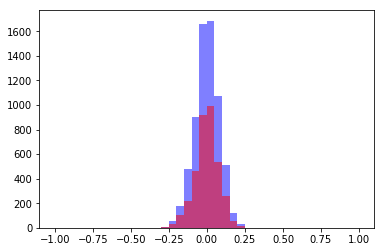

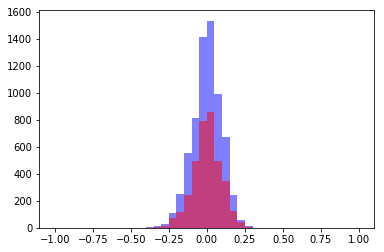

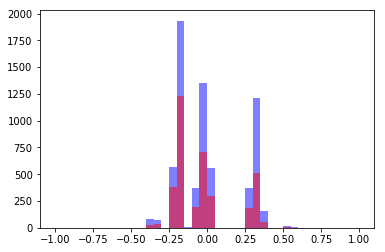

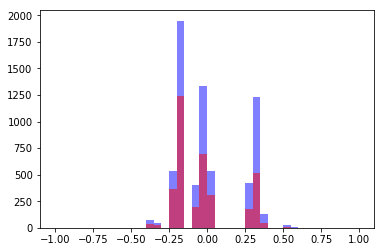

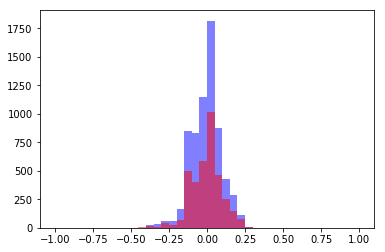

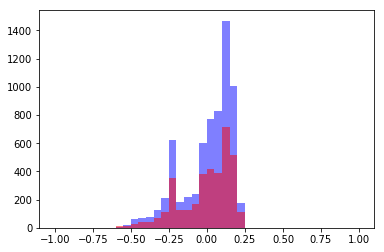

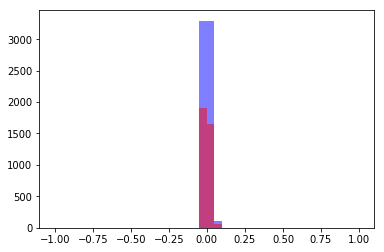

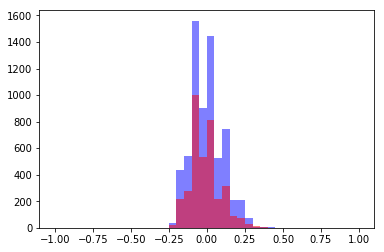

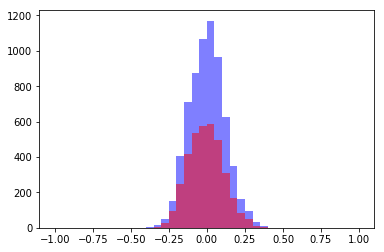

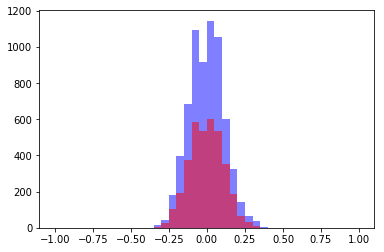

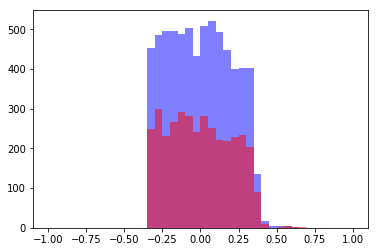

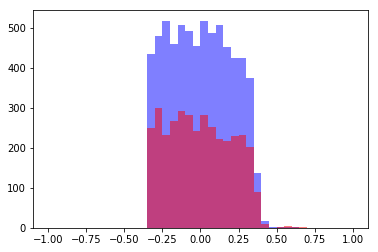

In [22]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_0.csv", 'L0_S0_D1')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

あきれるほど分布が一致している…

### station 1 編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L0_S1_F24', 'L0_S1_F28'],
      dtype='object')


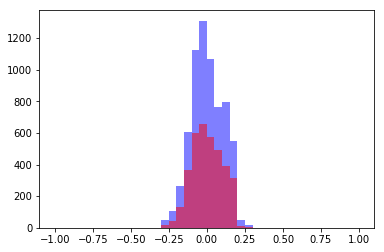

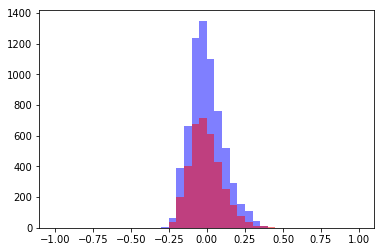

In [23]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_1.csv", 'L0_S1_D26')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

### station4 編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L0_S4_F104', 'L0_S4_F109'],
      dtype='object')


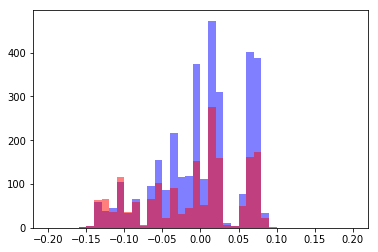

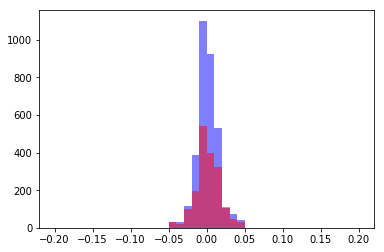

In [28]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_4.csv", 'L0_S4_D106')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric, rangeL=-0.2, rangeH=0.2)

### station 24編

In [ ]:
いけるかと思ったが、数が少ないだけでばらつきが見えてるみたい。

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145',
       ...
       'L1_S24_F1831', 'L1_S24_F1834', 'L1_S24_F1836', 'L1_S24_F1838',
       'L1_S24_F1840', 'L1_S24_F1842', 'L1_S24_F1844', 'L1_S24_F1846',
       'L1_S24_F1848', 'L1_S24_F1850'],
      dtype='object', length=285)
L1_S24_F679


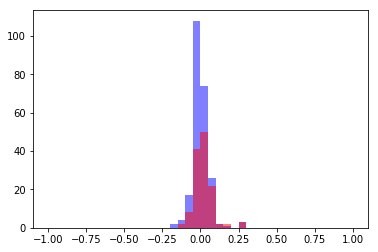

L1_S24_F683


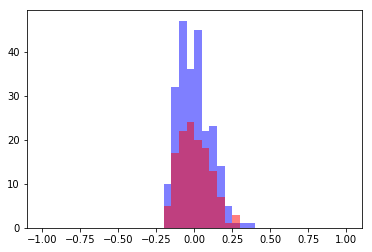

L1_S24_F687


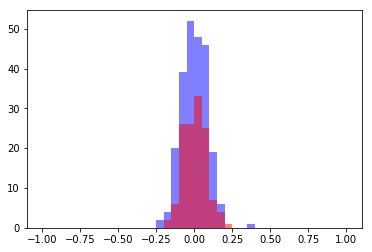

L1_S24_F691


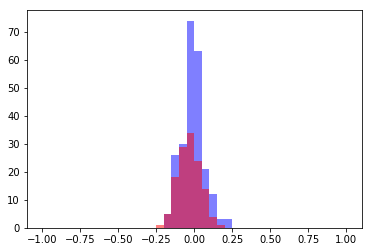

L1_S24_F700


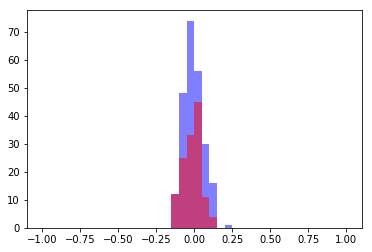

L1_S24_F719


C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


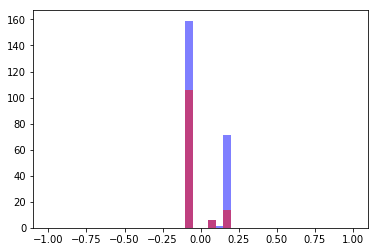

L1_S24_F728


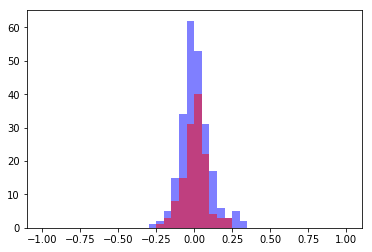

L1_S24_F733


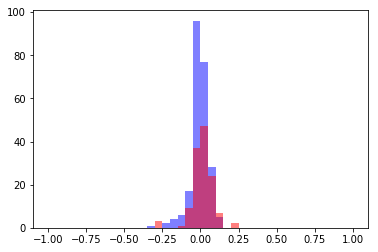

L1_S24_F746


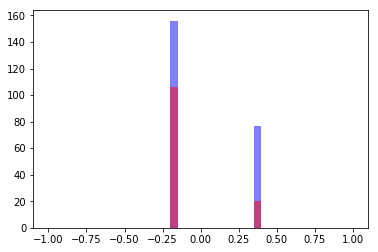

L1_S24_F751


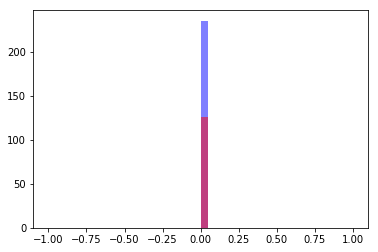

L1_S24_F756


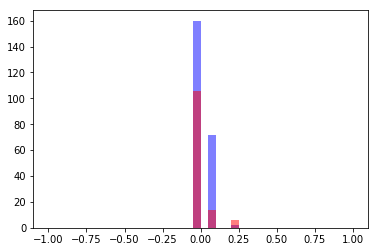

L1_S24_F761


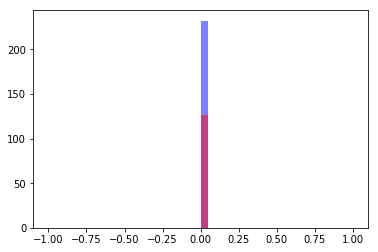

L1_S24_F766


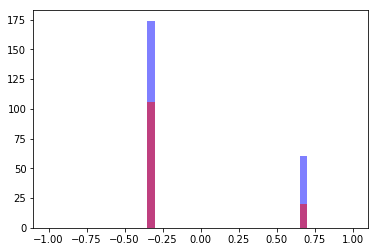

L1_S24_F775


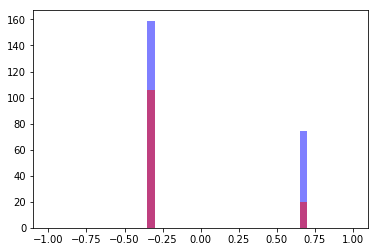

L1_S24_F780


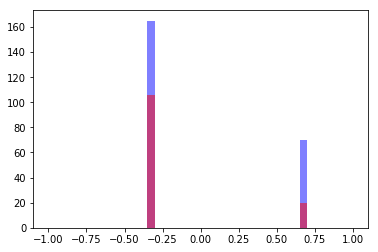

L1_S24_F785


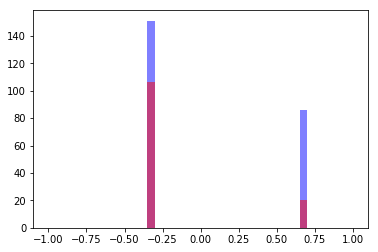

L1_S24_F790


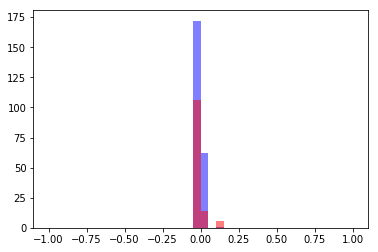

L1_S24_F795


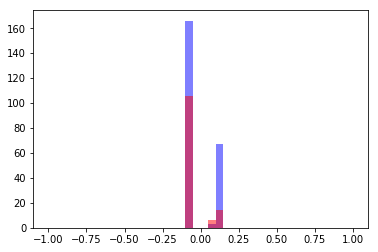

L1_S24_F800


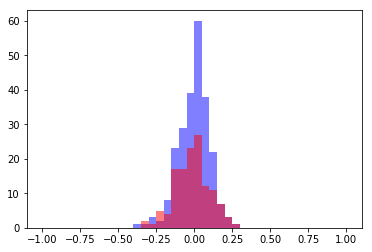

L1_S24_F802


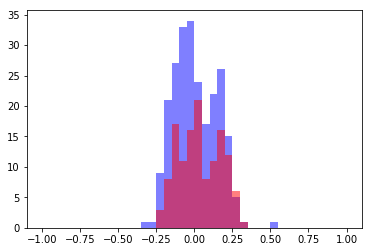

L1_S24_F806


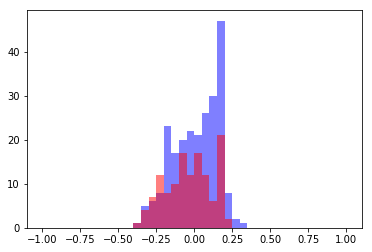

L1_S24_F808


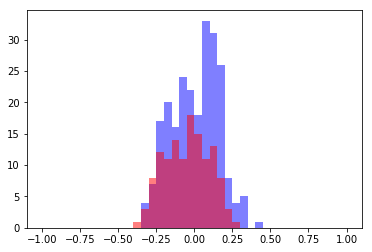

L1_S24_F810


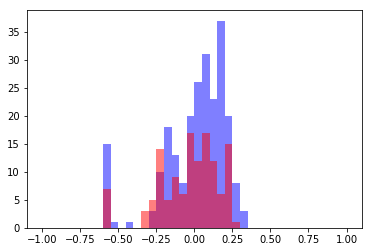

L1_S24_F812


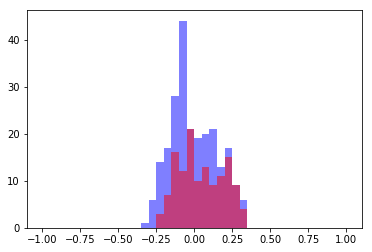

L1_S24_F814


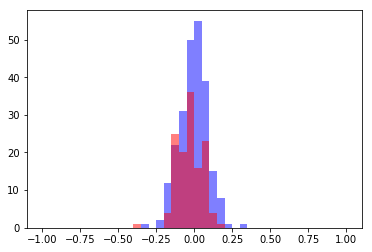

L1_S24_F816


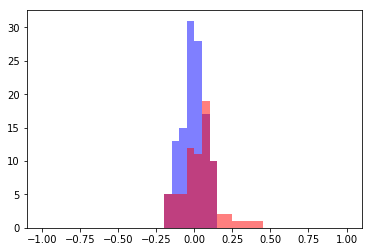

L1_S24_F829


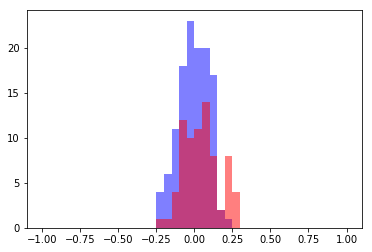

L1_S24_F834


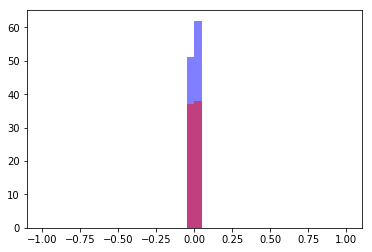

L1_S24_F839


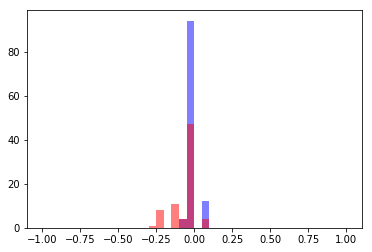

L1_S24_F844


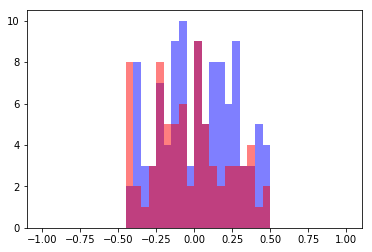

L1_S24_F857


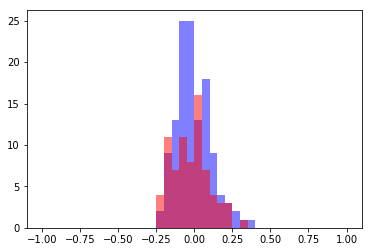

L1_S24_F862


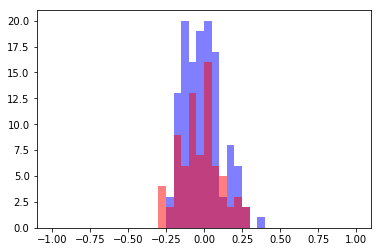

L1_S24_F867


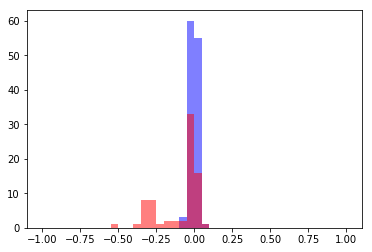

L1_S24_F872


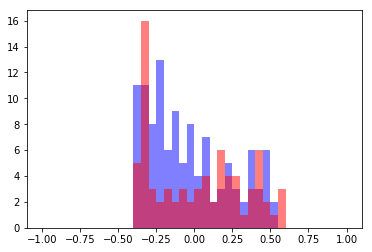

L1_S24_F877


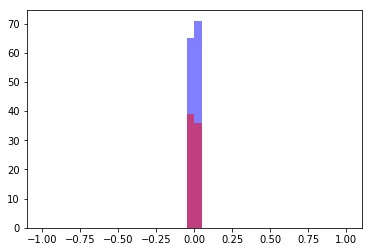

L1_S24_F882


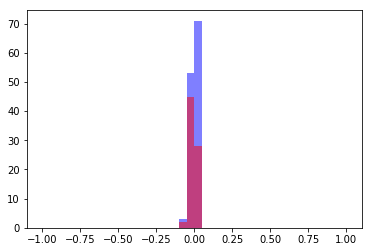

L1_S24_F887


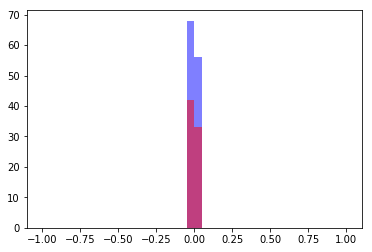

L1_S24_F892


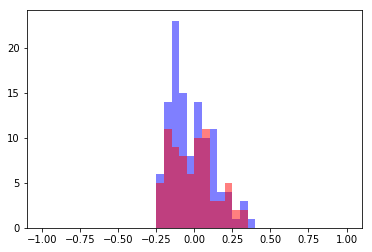

L1_S24_F897


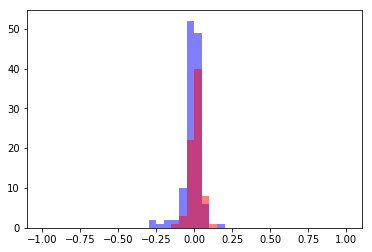

L1_S24_F902


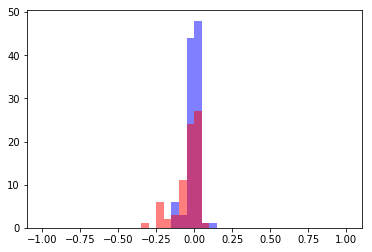

L1_S24_F907


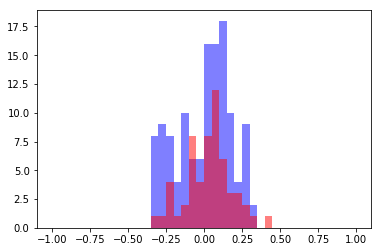

L1_S24_F920


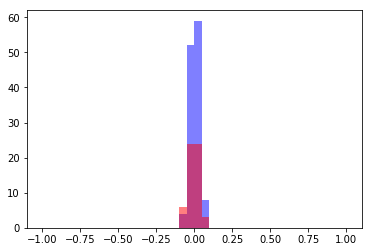

L1_S24_F925


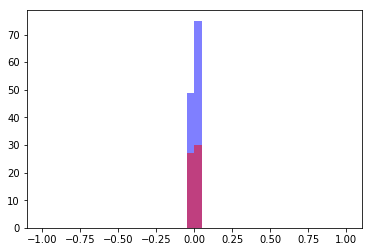

L1_S24_F930


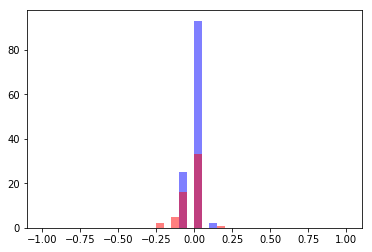

L1_S24_F935


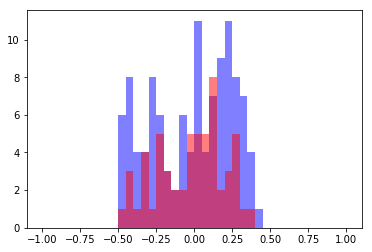

L1_S24_F948


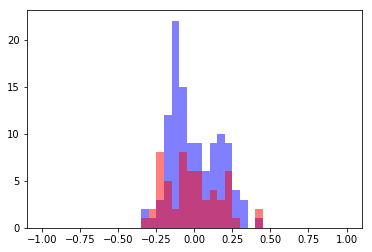

L1_S24_F953


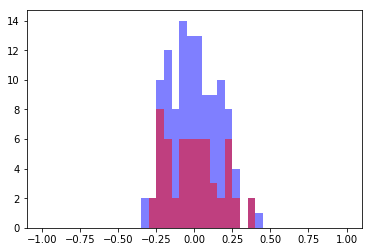

L1_S24_F958


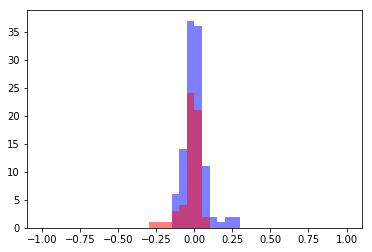

L1_S24_F963


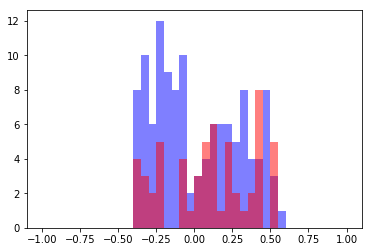

L1_S24_F968


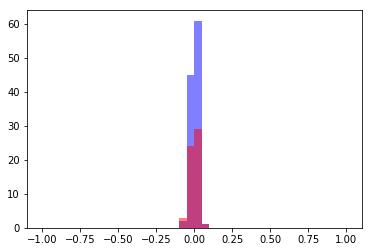

L1_S24_F973


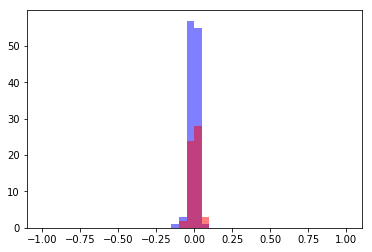

L1_S24_F978


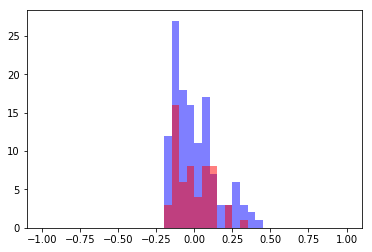

L1_S24_F983


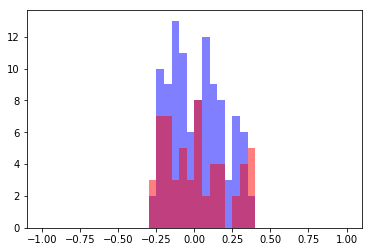

L1_S24_F988


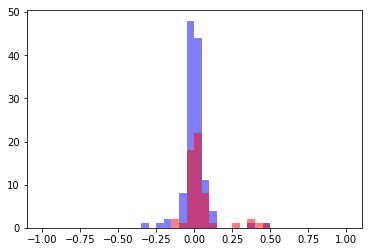

L1_S24_F993


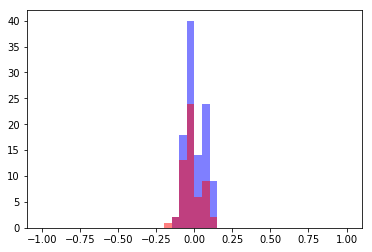

L1_S24_F998


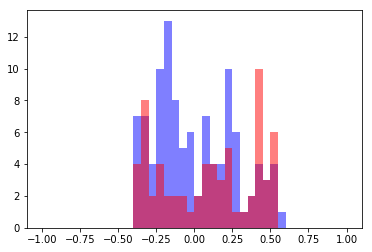

L1_S24_F1000


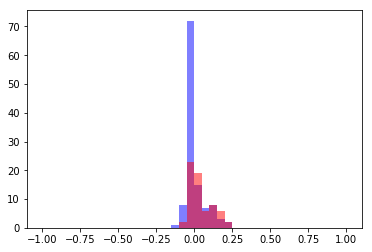

L1_S24_F1002


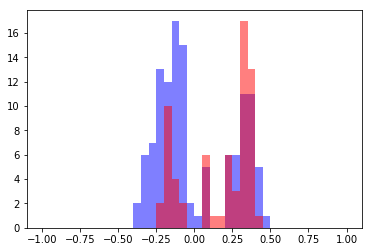

L1_S24_F1004


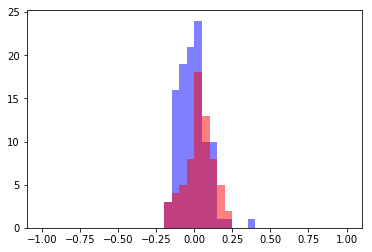

L1_S24_F1006


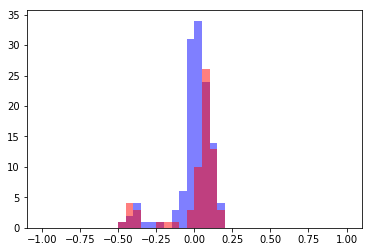

L1_S24_F1008


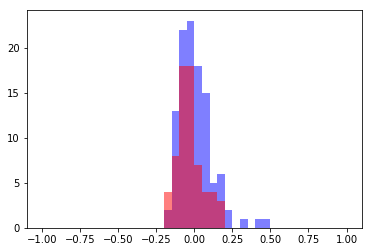

L1_S24_F1010


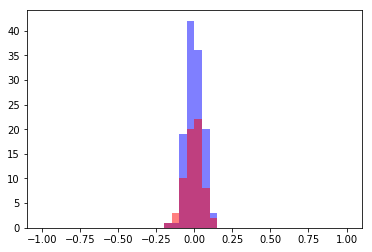

L1_S24_F1012


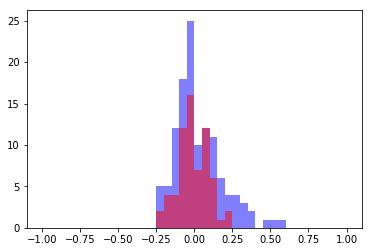

L1_S24_F1014


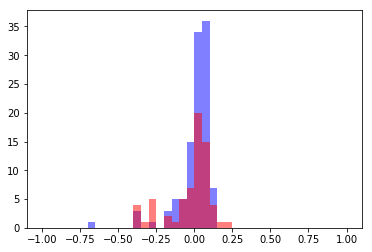

L1_S24_F1016


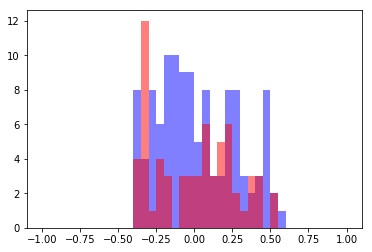

L1_S24_F1021


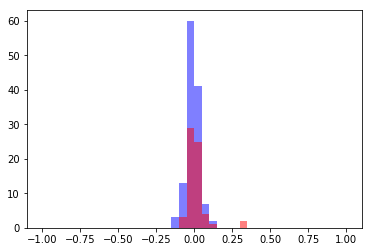

L1_S24_F1026


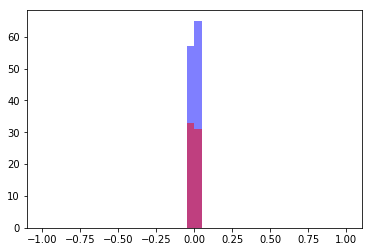

L1_S24_F1031


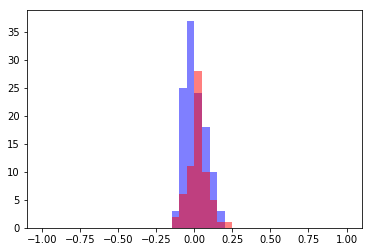

L1_S24_F1036


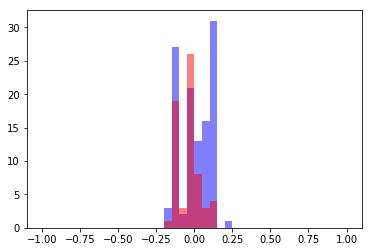

L1_S24_F1041


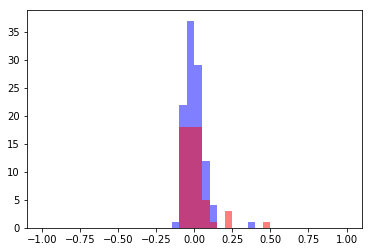

L1_S24_F1046


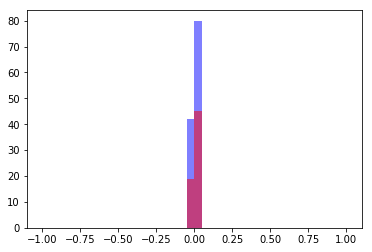

L1_S24_F1051


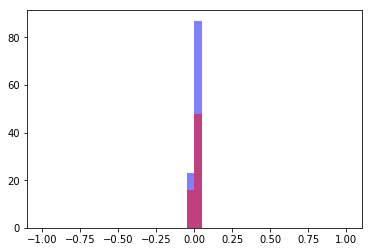

L1_S24_F1056


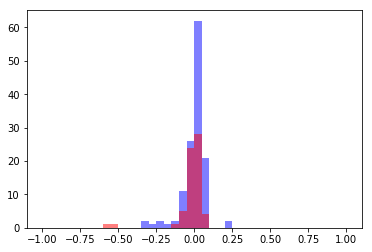

L1_S24_F1068


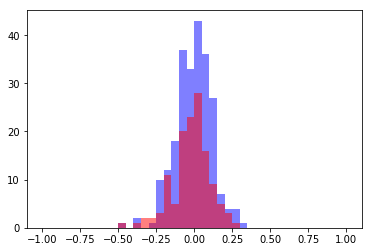

L1_S24_F1072


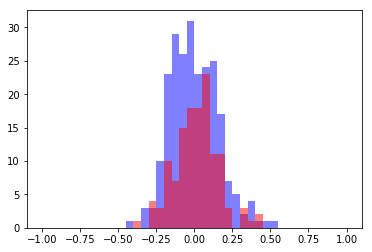

L1_S24_F1079


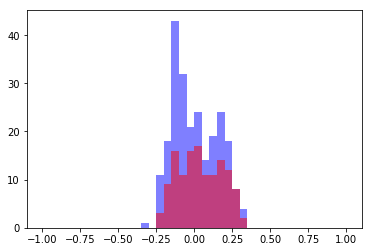

L1_S24_F1083


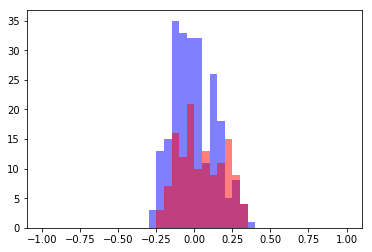

L1_S24_F1087


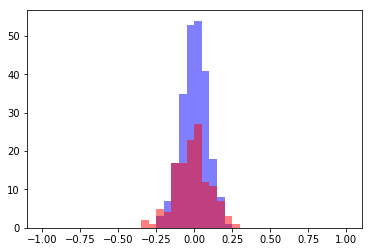

L1_S24_F1094


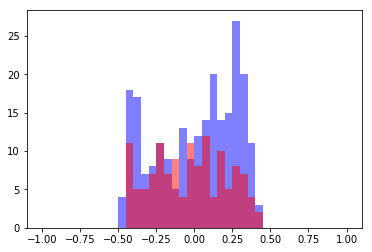

L1_S24_F1098


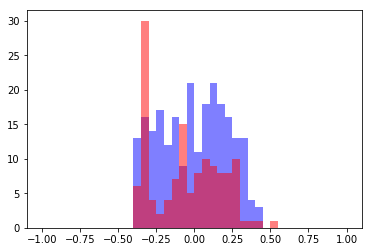

L1_S24_F1102


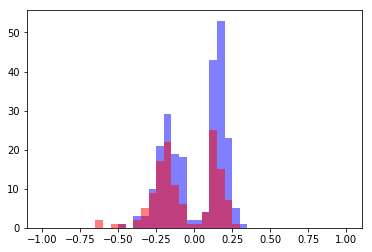

L1_S24_F1106


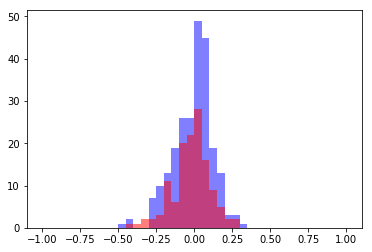

L1_S24_F1110


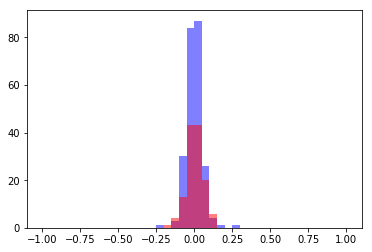

L1_S24_F1118


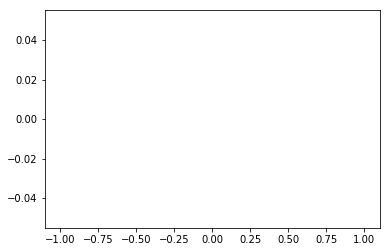

L1_S24_F1122


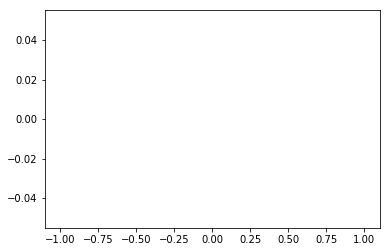

L1_S24_F1126


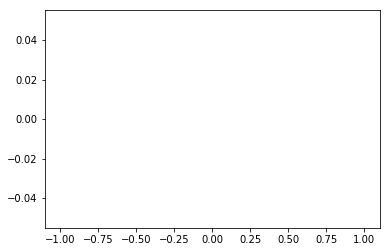

L1_S24_F1130


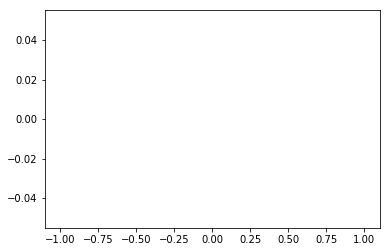

L1_S24_F1134


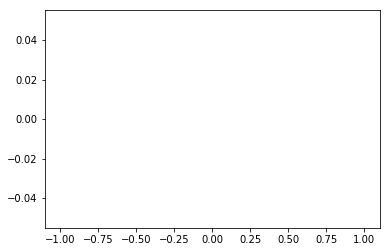

L1_S24_F1145


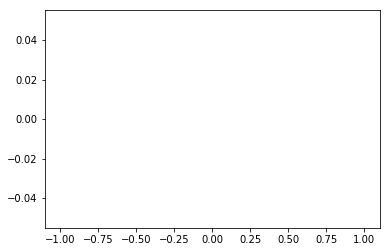

L1_S24_F1148


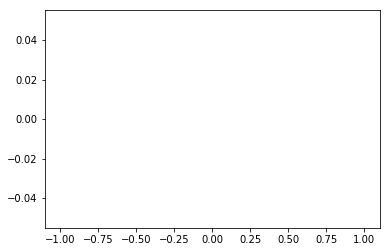

L1_S24_F1161


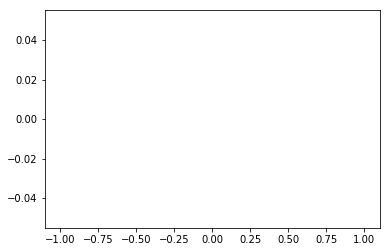

L1_S24_F1166


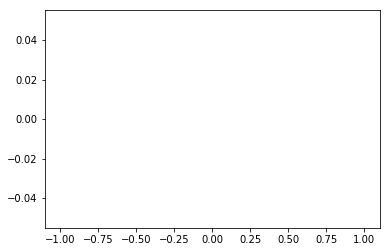

L1_S24_F1170


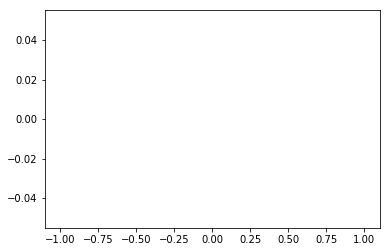

L1_S24_F1172


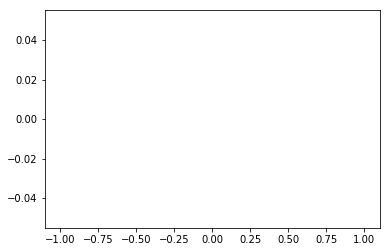

L1_S24_F1174


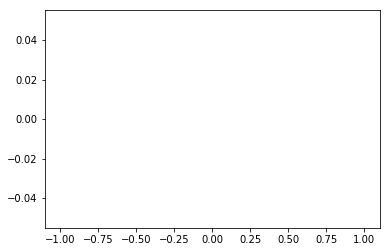

L1_S24_F1176


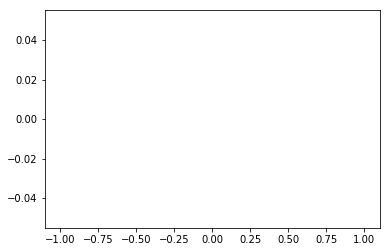

L1_S24_F1180


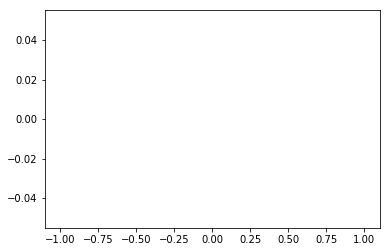

L1_S24_F1184


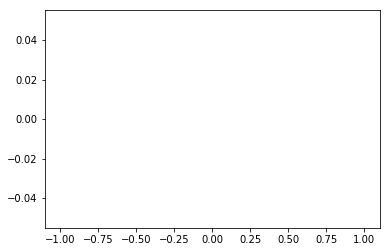

L1_S24_F1197


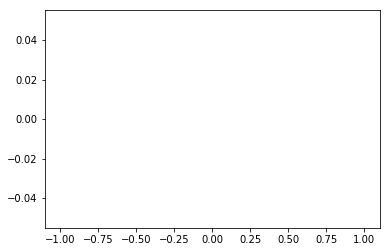

L1_S24_F1202


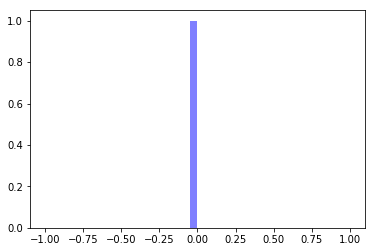

L1_S24_F1207


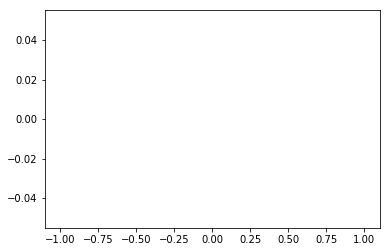

L1_S24_F1212


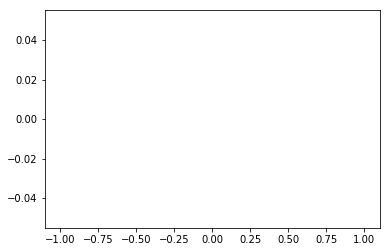

L1_S24_F1225


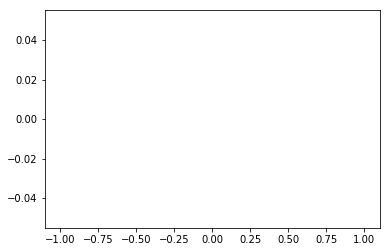

L1_S24_F1230


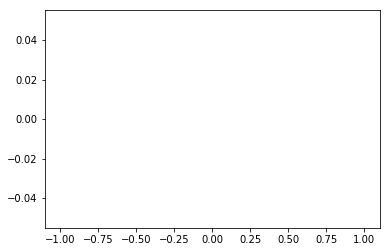

L1_S24_F1235


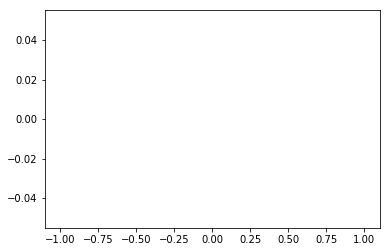

L1_S24_F1240


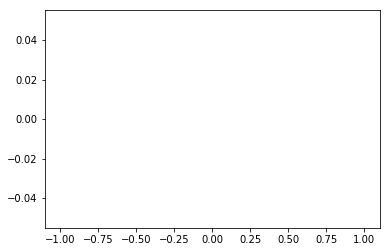

L1_S24_F1245


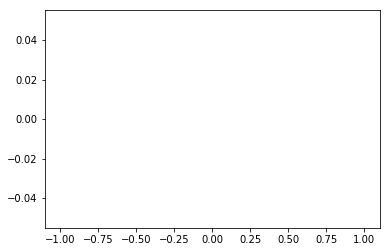

L1_S24_F1250


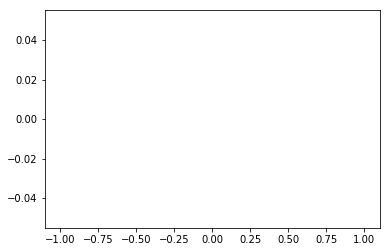

L1_S24_F1255


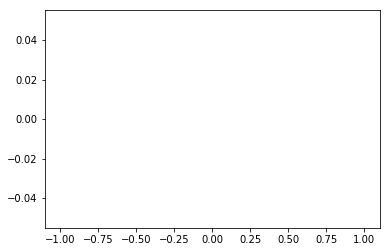

L1_S24_F1260


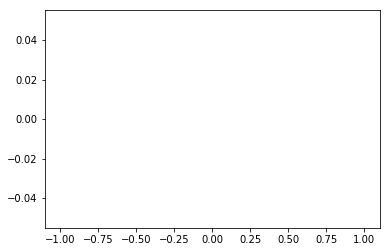

L1_S24_F1265


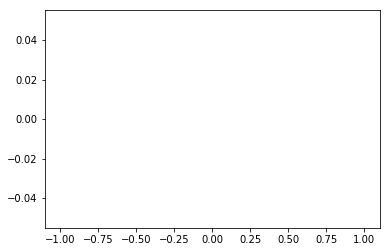

L1_S24_F1270


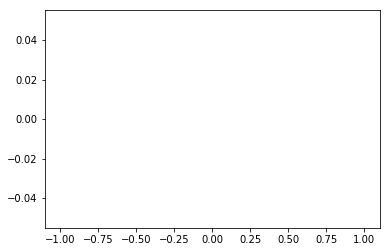

L1_S24_F1275


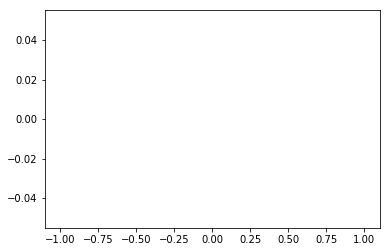

L1_S24_F1288


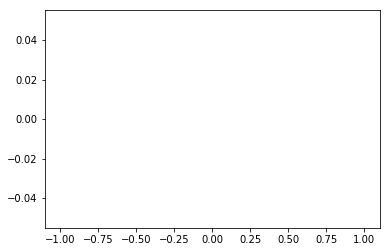

L1_S24_F1293


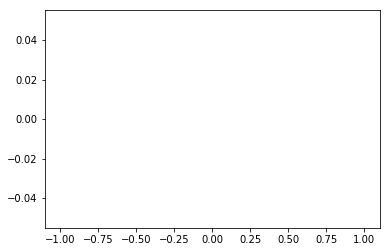

L1_S24_F1298


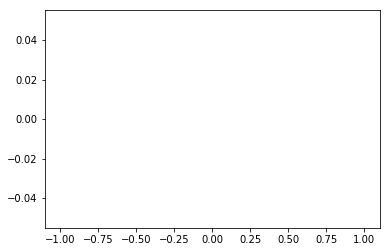

L1_S24_F1303


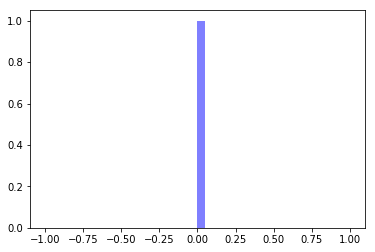

L1_S24_F1316


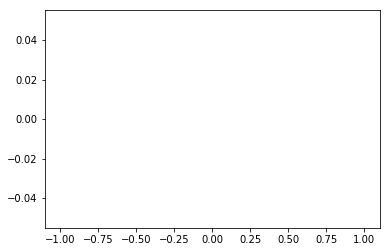

L1_S24_F1321


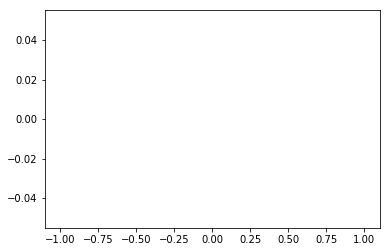

L1_S24_F1326


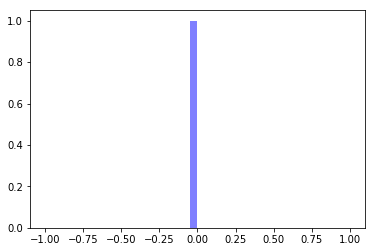

L1_S24_F1331


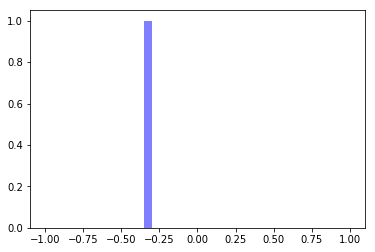

L1_S24_F1336


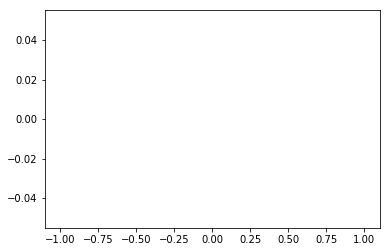

L1_S24_F1341


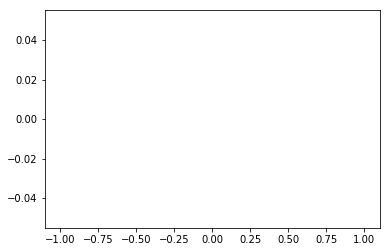

L1_S24_F1346


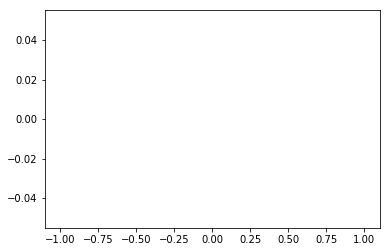

L1_S24_F1351


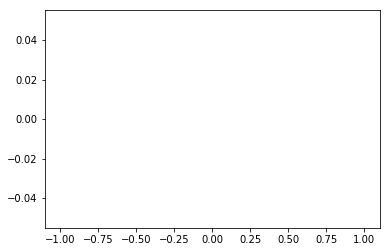

L1_S24_F1356


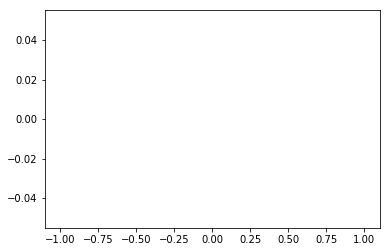

L1_S24_F1361


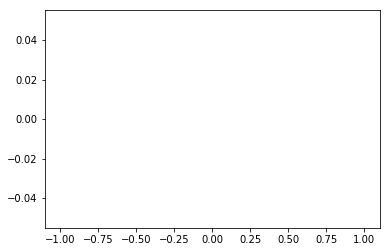

L1_S24_F1366


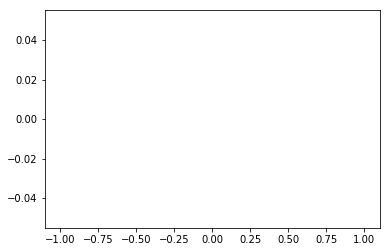

L1_S24_F1371


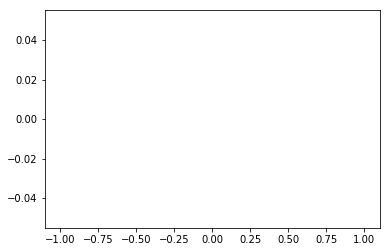

L1_S24_F1376


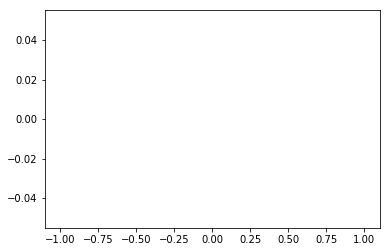

L1_S24_F1381


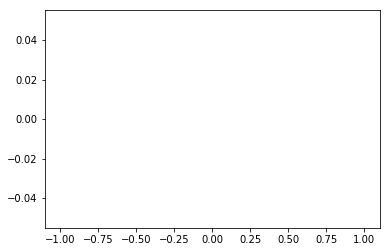

L1_S24_F1386


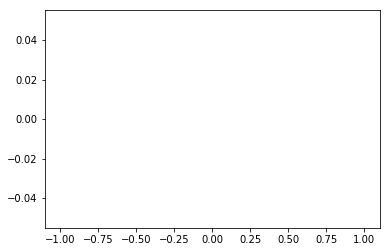

L1_S24_F1391


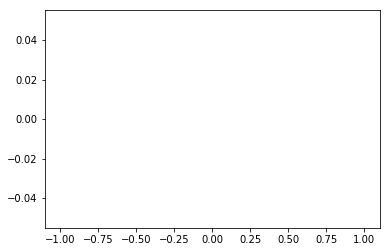

L1_S24_F1396


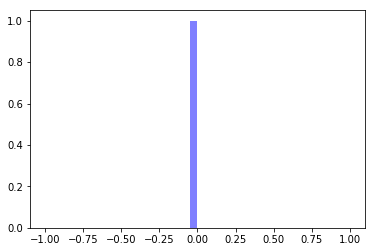

L1_S24_F1401


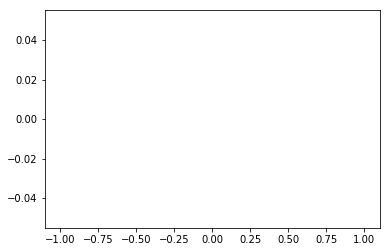

L1_S24_F1406


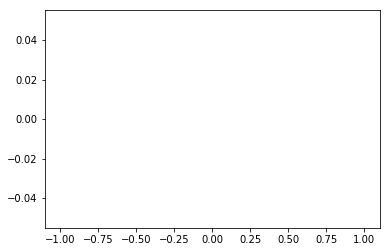

L1_S24_F1411


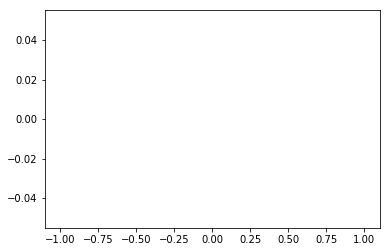

L1_S24_F1416


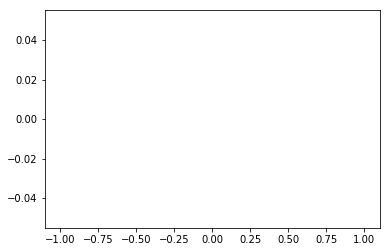

L1_S24_F1421


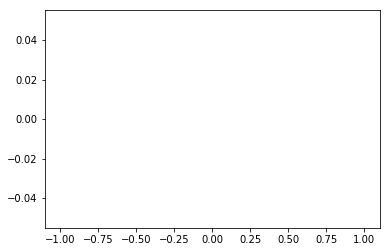

L1_S24_F1426


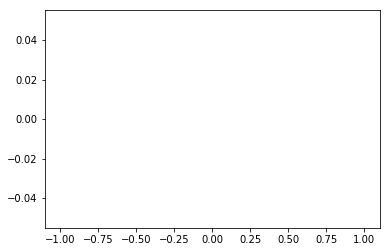

L1_S24_F1431


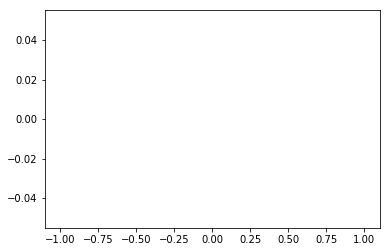

L1_S24_F1436


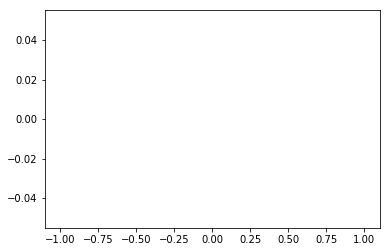

L1_S24_F1441


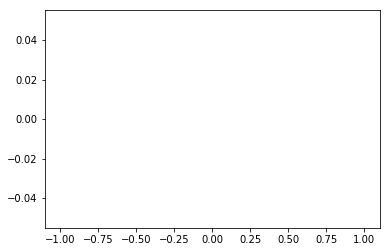

L1_S24_F1446


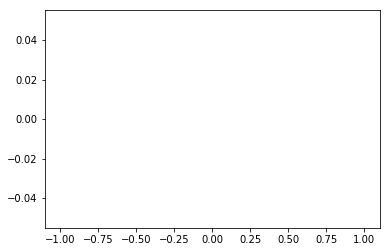

L1_S24_F1451


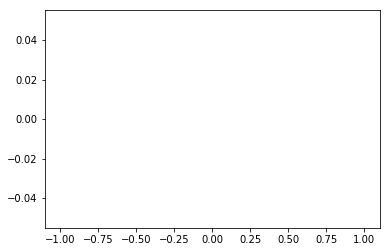

L1_S24_F1463


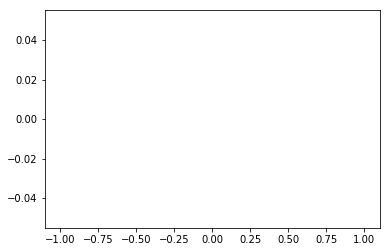

L1_S24_F1467


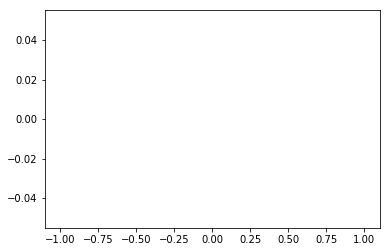

L1_S24_F1474


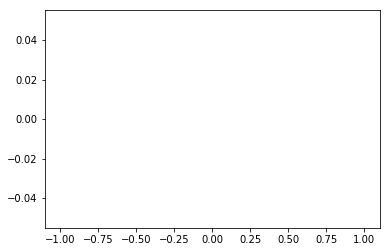

L1_S24_F1478


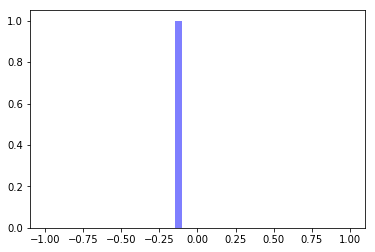

L1_S24_F1482


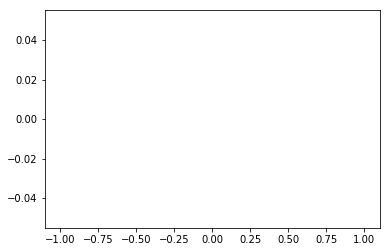

L1_S24_F1486


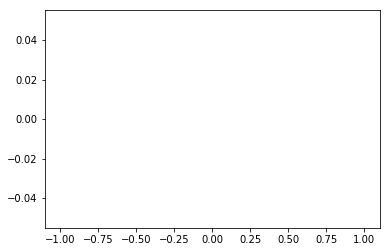

L1_S24_F1490


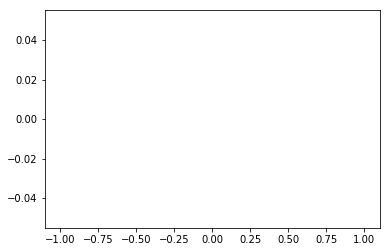

L1_S24_F1494


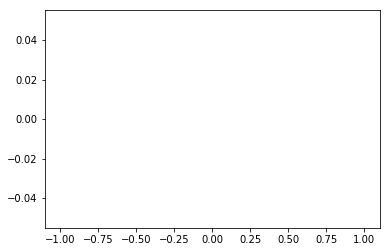

L1_S24_F1498


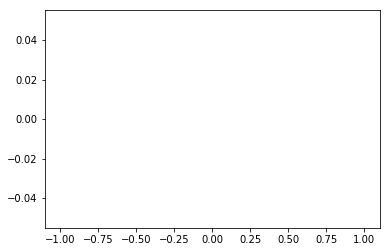

L1_S24_F1502


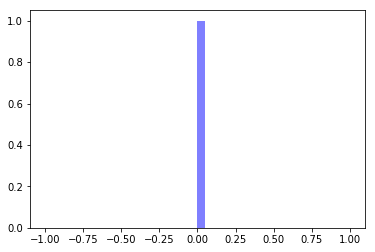

L1_S24_F1506


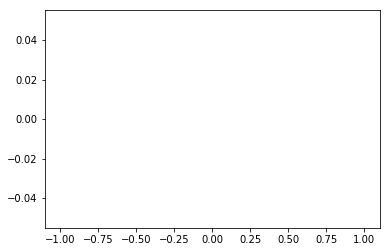

L1_S24_F1512


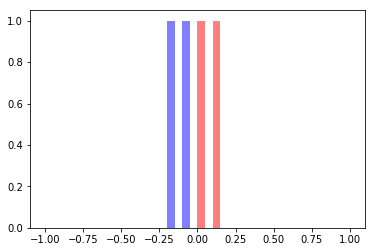

L1_S24_F1514


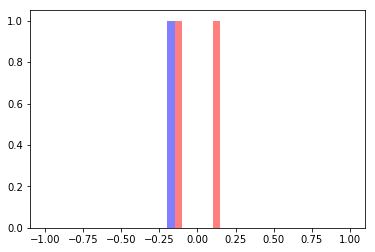

L1_S24_F1516


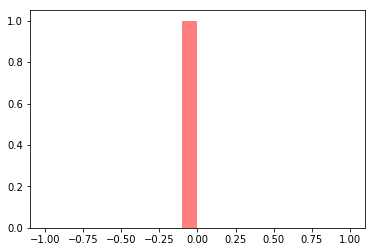

L1_S24_F1518


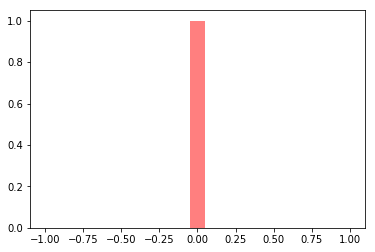

L1_S24_F1520


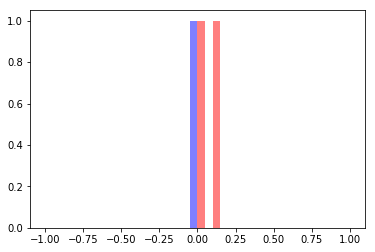

L1_S24_F1539


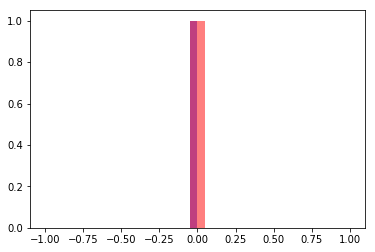

L1_S24_F1544


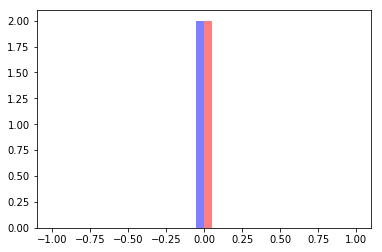

L1_S24_F1565


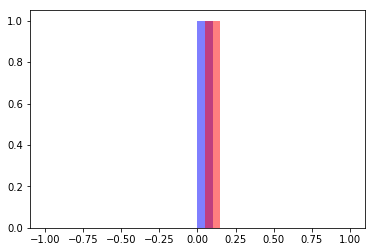

L1_S24_F1567


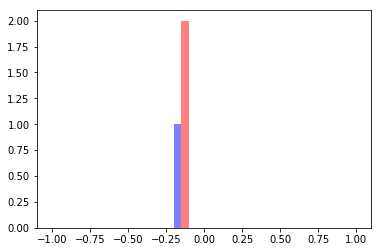

L1_S24_F1569


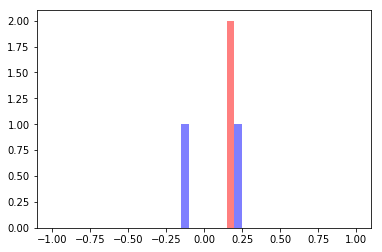

L1_S24_F1571


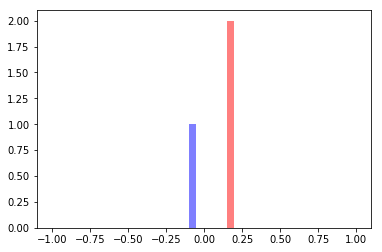

L1_S24_F1573


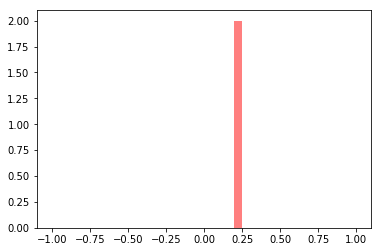

L1_S24_F1575


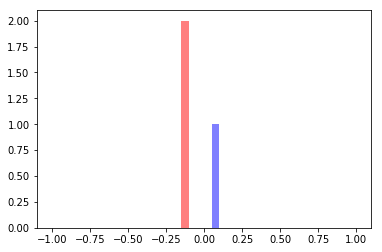

L1_S24_F1578


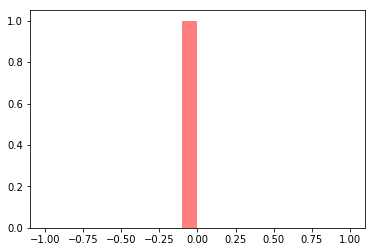

L1_S24_F1581


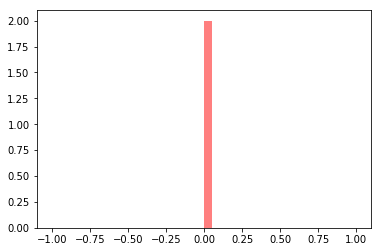

L1_S24_F1594


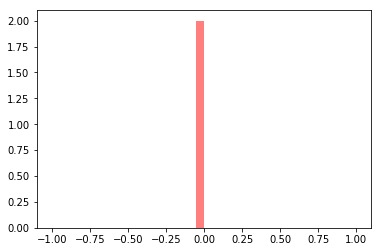

L1_S24_F1599


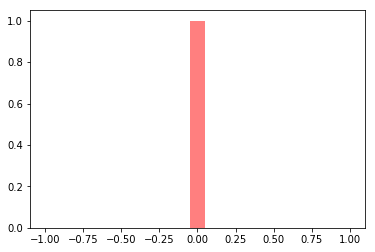

L1_S24_F1604


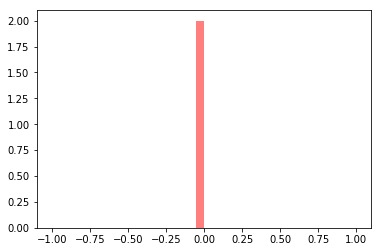

L1_S24_F1609


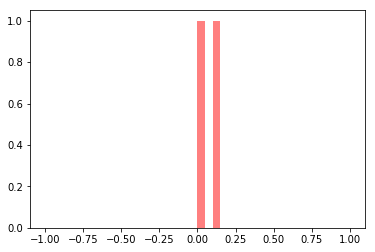

L1_S24_F1622


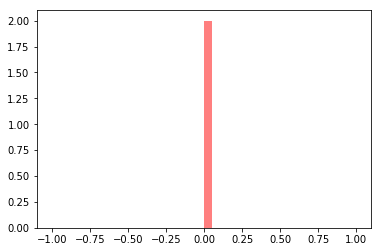

L1_S24_F1627


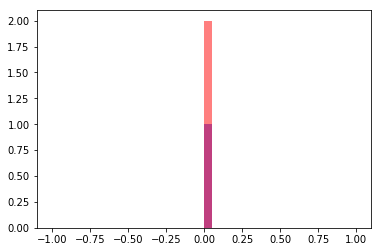

L1_S24_F1632


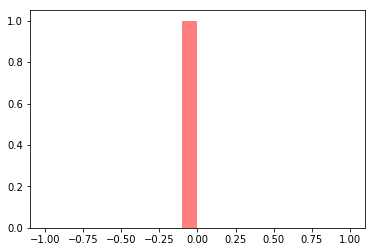

L1_S24_F1637


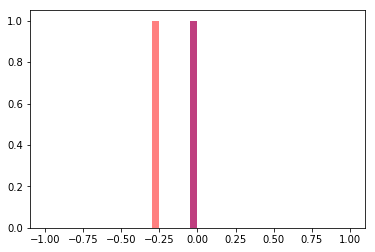

L1_S24_F1642


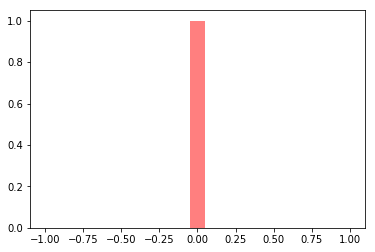

L1_S24_F1647


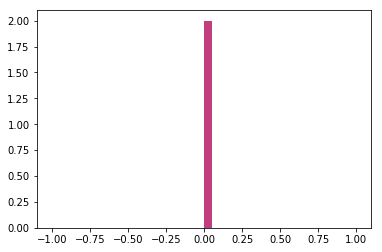

L1_S24_F1652


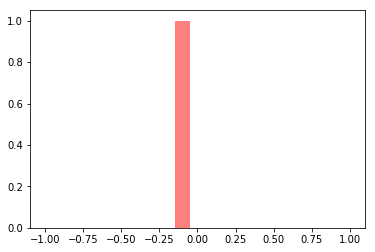

L1_S24_F1657


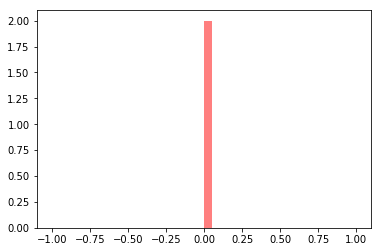

L1_S24_F1662


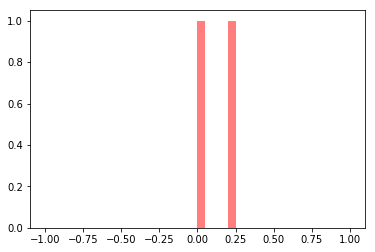

L1_S24_F1667


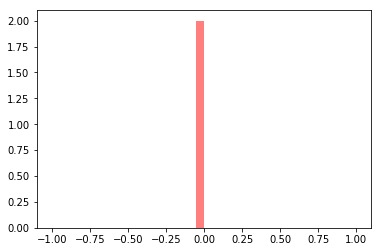

L1_S24_F1672


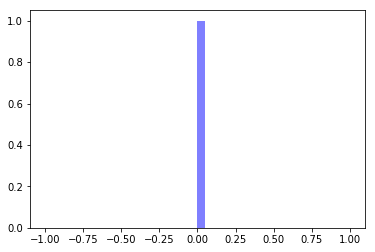

L1_S24_F1685


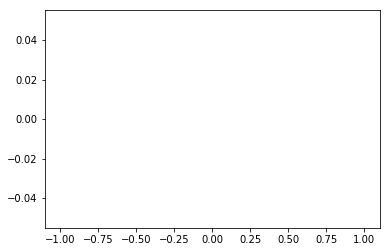

L1_S24_F1690


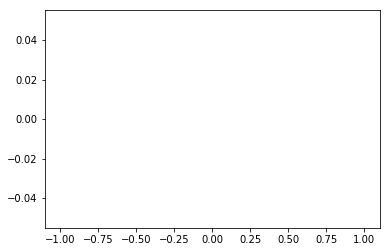

L1_S24_F1695


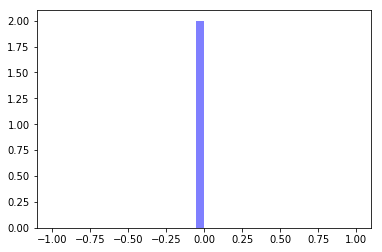

L1_S24_F1700


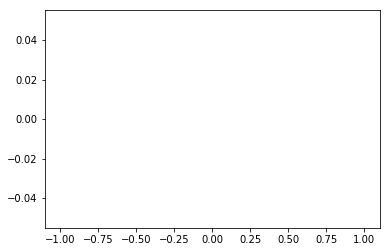

L1_S24_F1713


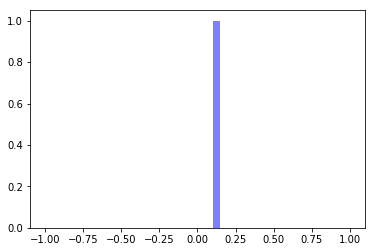

L1_S24_F1718


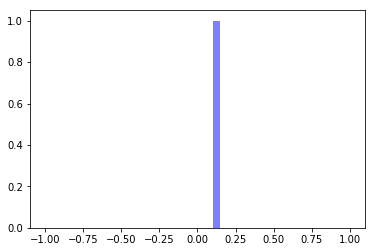

L1_S24_F1723


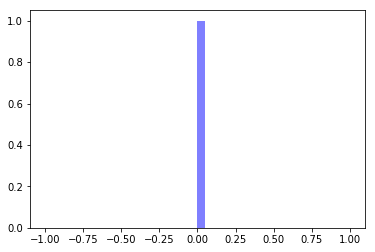

L1_S24_F1728


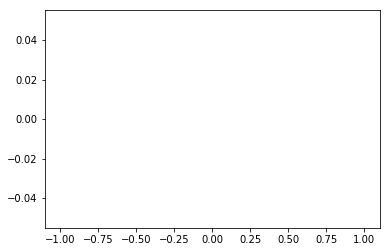

L1_S24_F1733


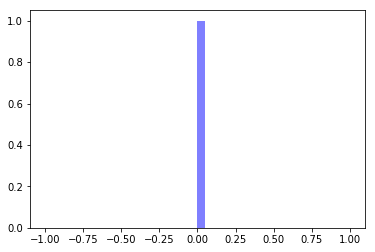

L1_S24_F1738


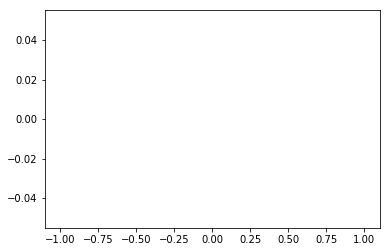

L1_S24_F1743


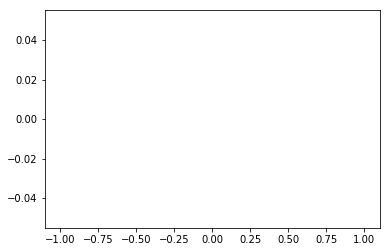

L1_S24_F1748


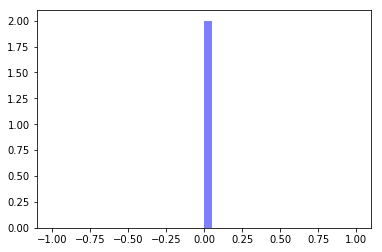

L1_S24_F1753


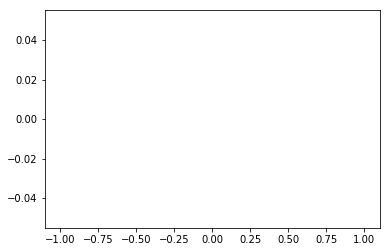

L1_S24_F1758


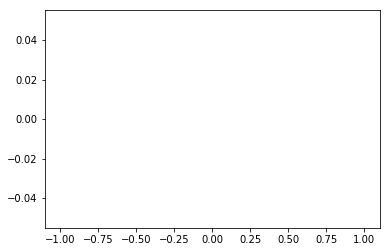

L1_S24_F1763


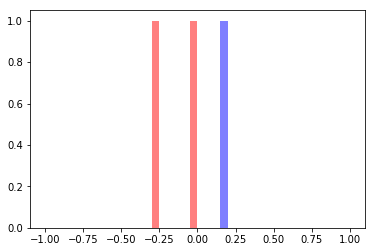

L1_S24_F1768


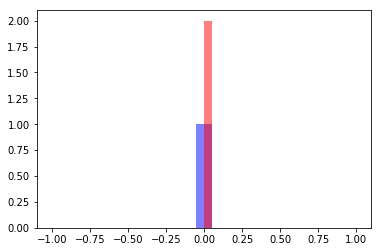

L1_S24_F1773


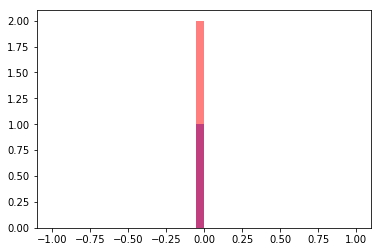

L1_S24_F1778


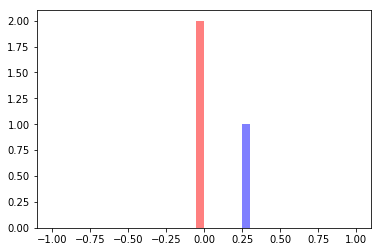

L1_S24_F1783


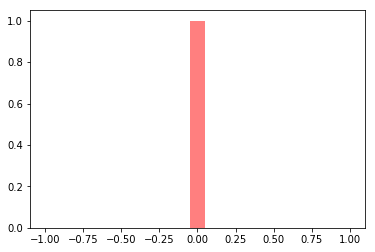

L1_S24_F1788


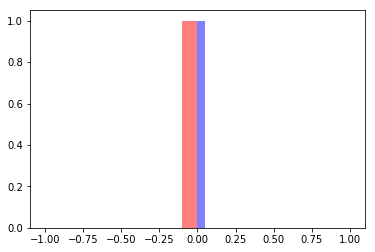

L1_S24_F1793


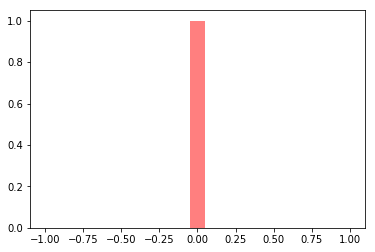

L1_S24_F1798


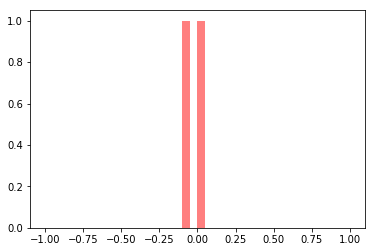

L1_S24_F1803


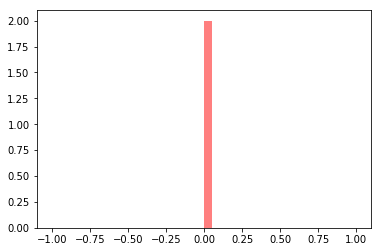

L1_S24_F1808


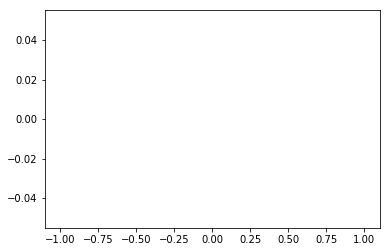

L1_S24_F1810


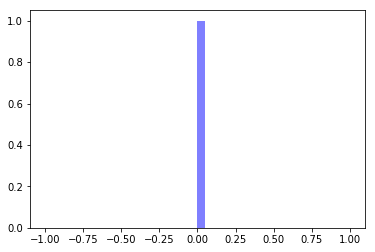

L1_S24_F1812


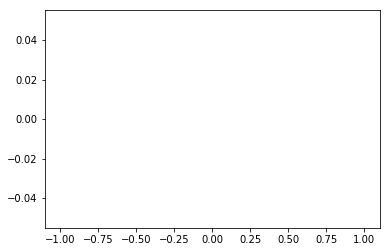

L1_S24_F1814


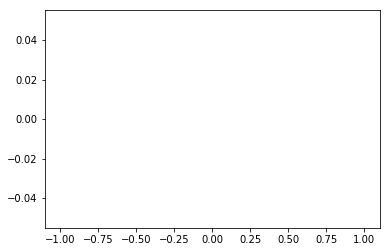

L1_S24_F1816


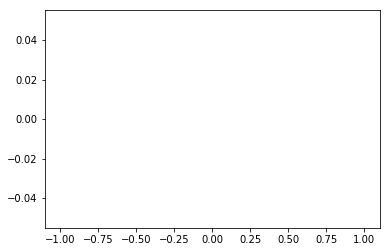

L1_S24_F1818


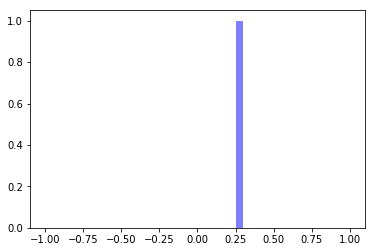

L1_S24_F1820


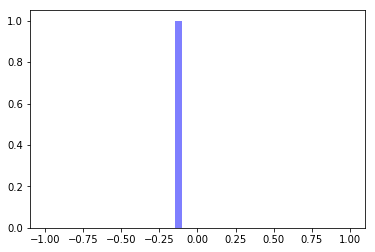

L1_S24_F1822


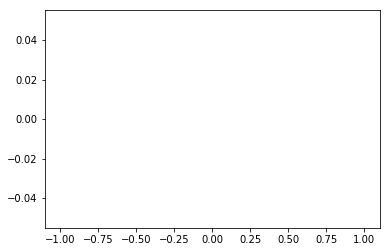

L1_S24_F1824


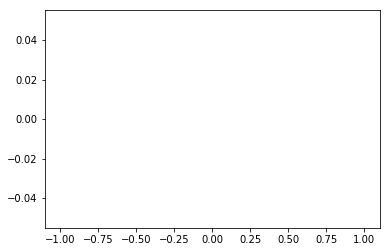

L1_S24_F1829


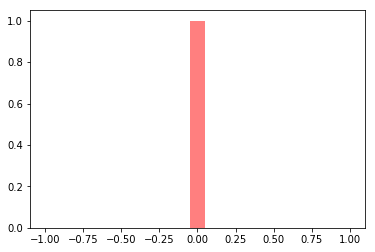

L1_S24_F1831


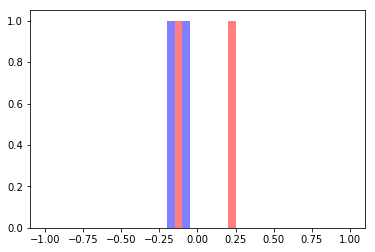

L1_S24_F1834


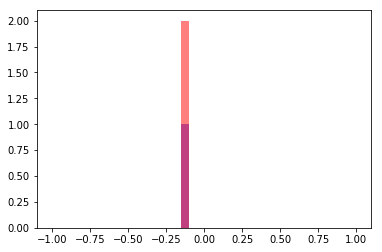

L1_S24_F1836


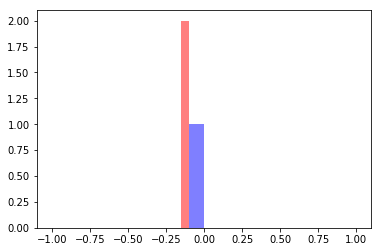

L1_S24_F1838


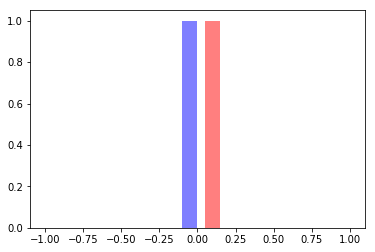

L1_S24_F1840


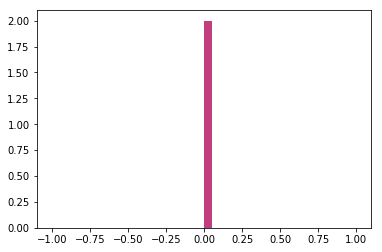

L1_S24_F1842


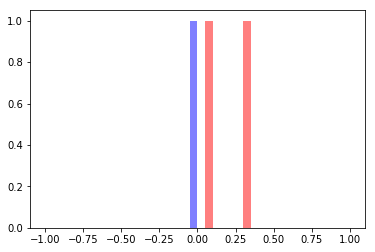

L1_S24_F1844


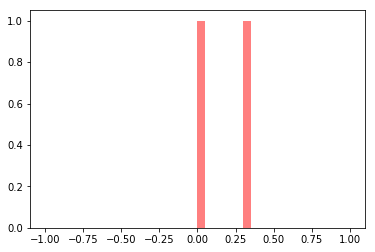

L1_S24_F1846


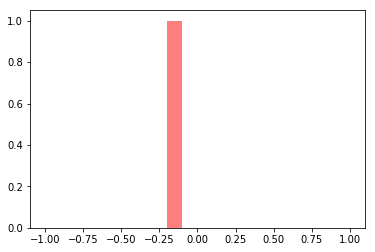

L1_S24_F1848


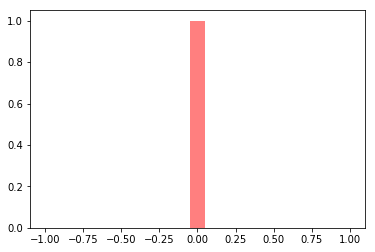

L1_S24_F1850


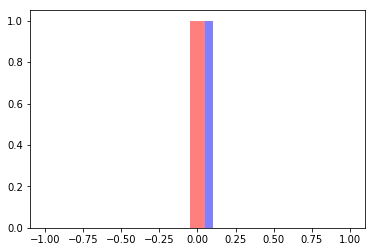

In [88]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_24.csv", 'L1_S24_D677')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [90]:
df_pass_with_numeric.describe()

Id      L0_S0_D1     L0_S1_D26     L0_S2_D34     L0_S3_D70  \
count  2.386200e+04  23862.000000  23862.000000  23862.000000  23862.000000   
mean   1.174616e+06      0.019529      0.019445      0.009303      0.010267   
std    6.700632e+05      0.138378      0.138086      0.096007      0.100809   
min    2.820000e+02      0.000000      0.000000      0.000000      0.000000   
25%    6.009482e+05      0.000000      0.000000      0.000000      0.000000   
50%    1.169870e+06      0.000000      0.000000      0.000000      0.000000   
75%    1.746627e+06      0.000000      0.000000      0.000000      0.000000   
max    2.367422e+06      1.000000      1.000000      1.000000      1.000000   

         L0_S4_D106    L0_S5_D115    L0_S6_D120    L0_S7_D137    L0_S8_D145  \
count  23862.000000  23862.000000  23862.000000  23862.000000  23862.000000   
mean       0.010267      0.009303      0.009513      0.010058      0.019529   
std        0.100809      0.096007      0.097072      0.099785      0.138378   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           ...       L1_S24_F1831  L1_S24_F1834  L1_S24_F1836  L1_S24_F1838  \
count      ...           88.00000     88.000000     88.000000     88.000000   
mean       ...           -0.01367     -0.054295     -0.044159      0.041341   
std        ...            0.16133      0.113395      0.115019      0.093965   
min        ...           -0.32900     -0.306000     -0.305000     -0.184000   
25%        ...           -0.13500     -0.136000     -0.132750     -0.011000   
50%        ...           -0.02050     -0.076500     -0.065000      0.030000   
75%        ...            0.11100      0.045000      0.063250      0.106250   
max        ...            0.36800      0.205000      0.213000      0.343000   

       L1_S24_F1840  L1_S24_F1842  L1_S24_F1844  L1_S24_F1846  L1_S24_F1848  \
count          88.0     88.000000     88.000000     88.000000     88.000000   
mean            0.0      0.019523      0.019966      0.008898      0.002886   
std             0.0      0.243599      0.209886      0.138391      0.107129   
min             0.0     -0.413000     -0.333000     -0.264000     -0.384000   
25%             0.0     -0.180250     -0.146750     -0.115000     -0.047250   
50%             0.0      0.028000      0.027500      0.038500      0.000000   
75%             0.0      0.216000      0.156500      0.127250      0.061250   
max             0.0      0.426000      0.383000      0.235000      0.288000   

       L1_S24_F1850  
count     88.000000  
mean      -0.004409  
std        0.054074  
min       -0.138000  
25%       -0.035250  
50%       -0.005000  
75%        0.032750  
max        0.168000  

[8 rows x 285 columns]

In [91]:
df_pass_with_numeric.columns

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145',
       ...
       'L1_S24_F1831', 'L1_S24_F1834', 'L1_S24_F1836', 'L1_S24_F1838',
       'L1_S24_F1840', 'L1_S24_F1842', 'L1_S24_F1844', 'L1_S24_F1846',
       'L1_S24_F1848', 'L1_S24_F1850'],
      dtype='object', length=285)

### station 25 編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145',
       ...
       'L1_S25_F3015', 'L1_S25_F3017', 'L1_S25_F3020', 'L1_S25_F3022',
       'L1_S25_F3024', 'L1_S25_F3026', 'L1_S25_F3028', 'L1_S25_F3030',
       'L1_S25_F3032', 'L1_S25_F3034'],
      dtype='object', length=340)
L1_S25_F1855


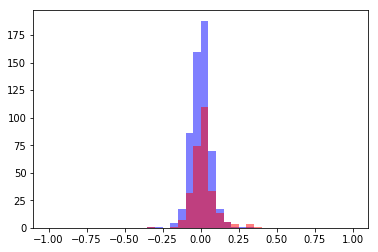

L1_S25_F1858


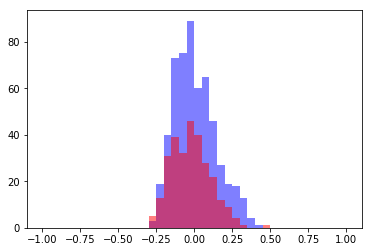

L1_S25_F1865


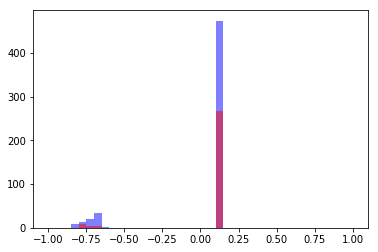

L1_S25_F1869


C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


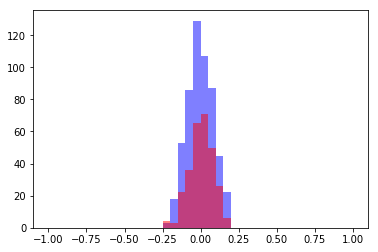

L1_S25_F1873


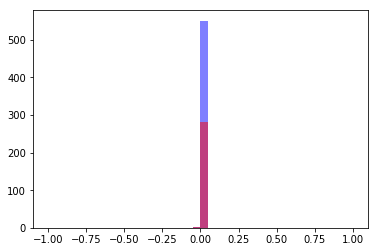

L1_S25_F1877


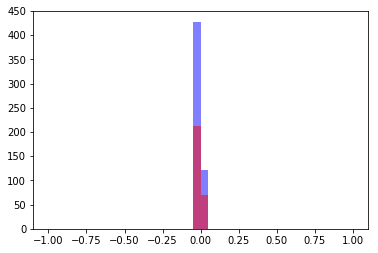

L1_S25_F1881


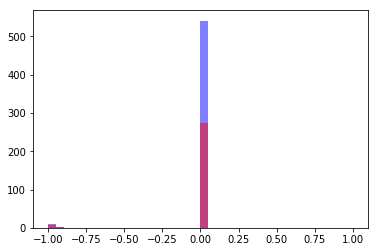

L1_S25_F1885


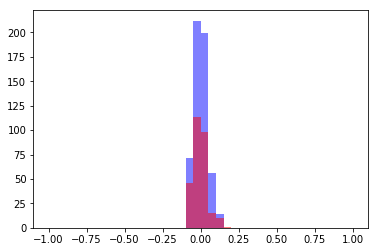

L1_S25_F1890


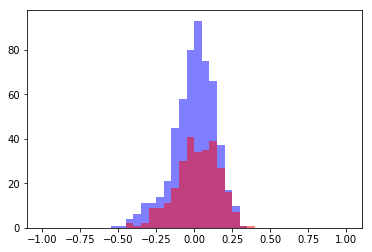

L1_S25_F1892


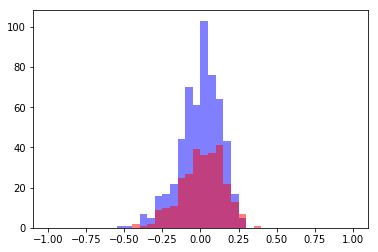

L1_S25_F1894


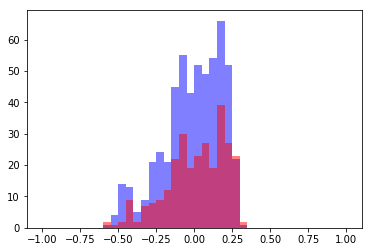

L1_S25_F1896


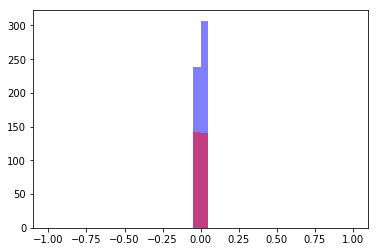

L1_S25_F1900


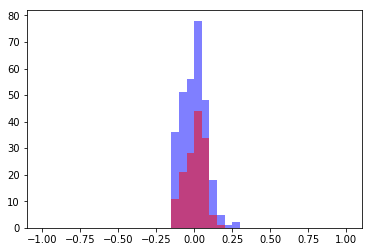

L1_S25_F1909


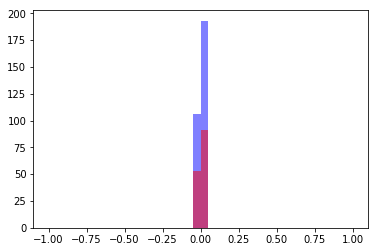

L1_S25_F1914


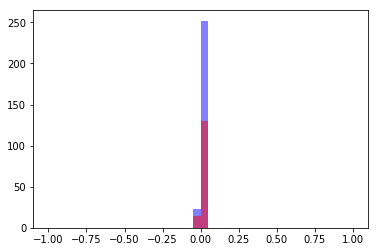

L1_S25_F1919


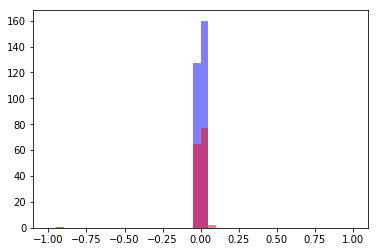

L1_S25_F1924


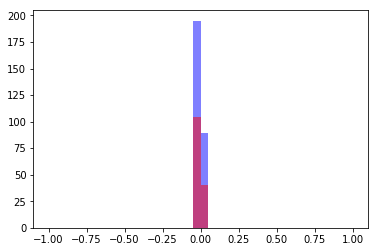

L1_S25_F1929


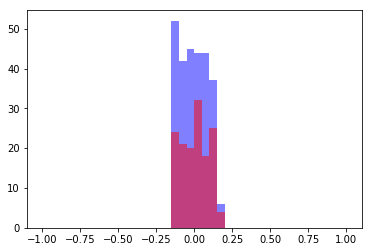

L1_S25_F1938


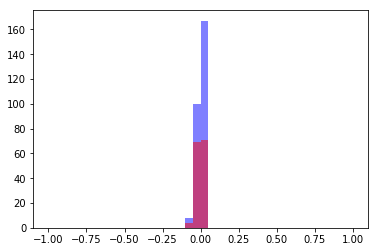

L1_S25_F1943


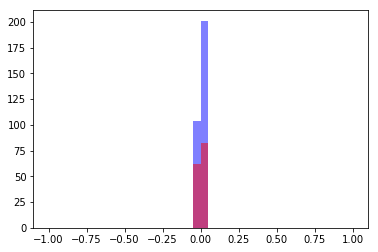

L1_S25_F1948


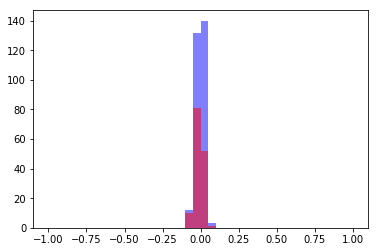

L1_S25_F1953


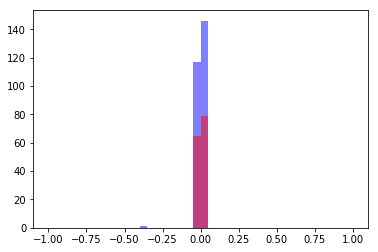

L1_S25_F1958


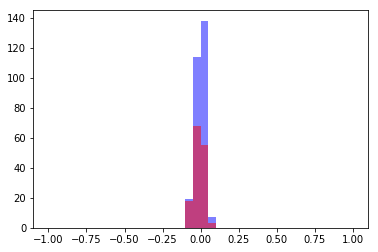

L1_S25_F1963


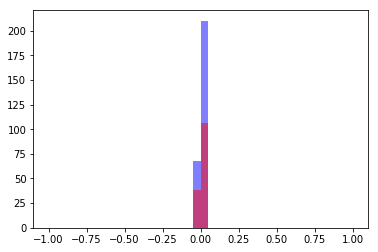

L1_S25_F1968


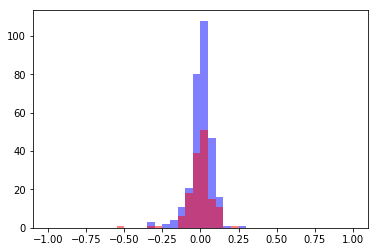

L1_S25_F1973


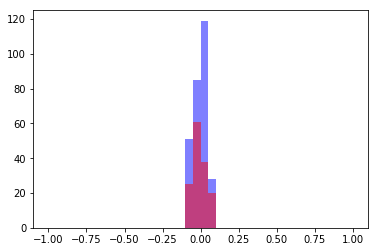

L1_S25_F1978


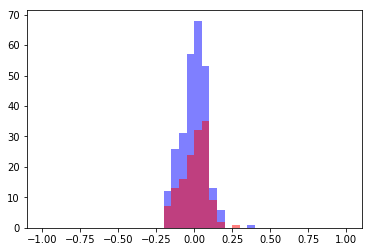

L1_S25_F1987


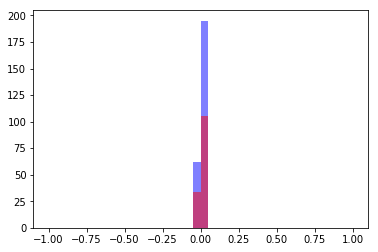

L1_S25_F1992


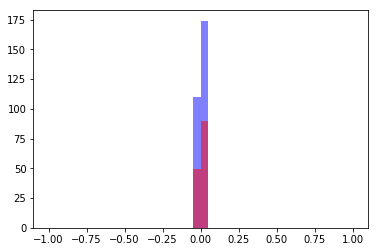

L1_S25_F1997


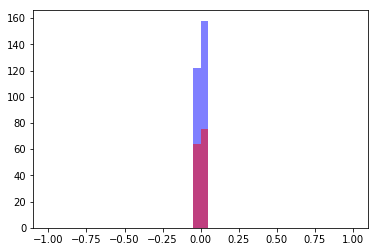

L1_S25_F2002


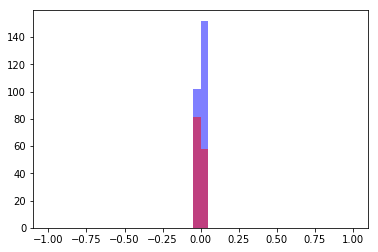

L1_S25_F2007


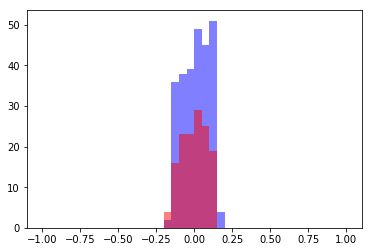

L1_S25_F2016


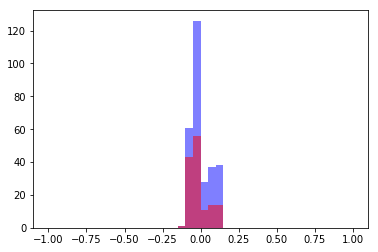

L1_S25_F2021


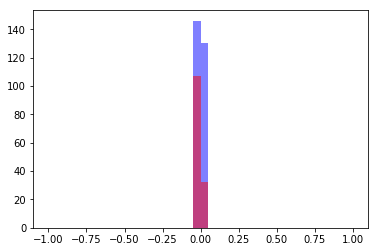

L1_S25_F2026


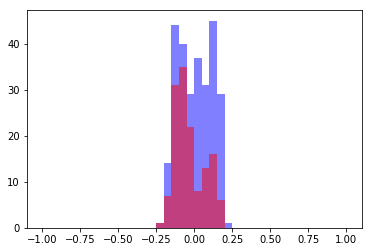

L1_S25_F2031


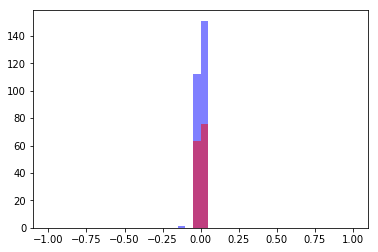

L1_S25_F2036


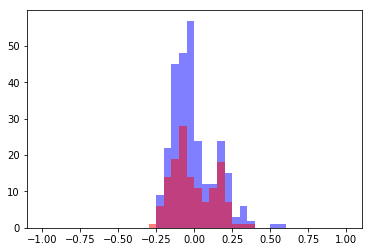

L1_S25_F2041


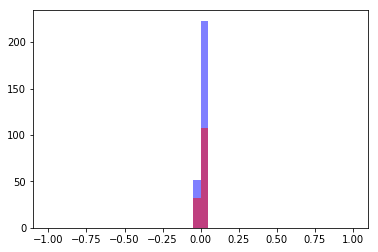

L1_S25_F2046


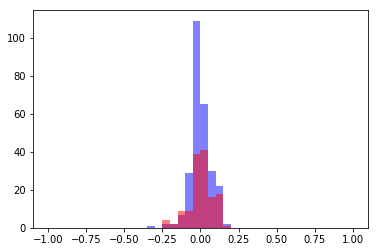

L1_S25_F2051


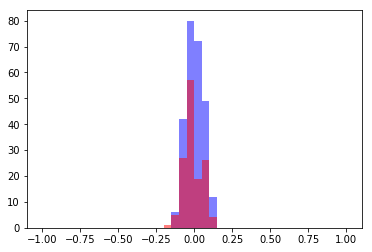

L1_S25_F2056


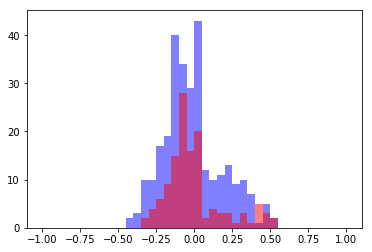

L1_S25_F2061


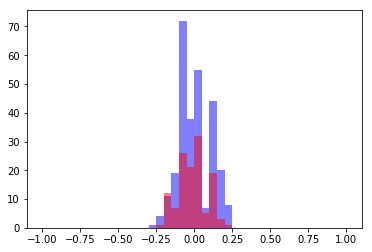

L1_S25_F2066


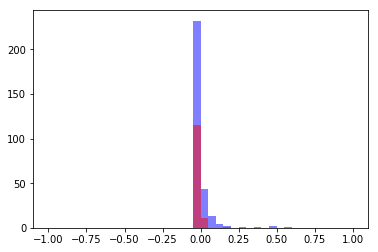

L1_S25_F2071


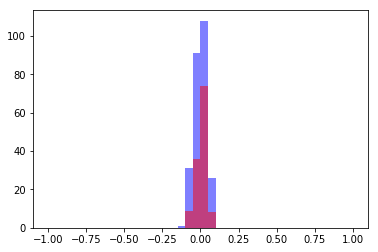

L1_S25_F2076


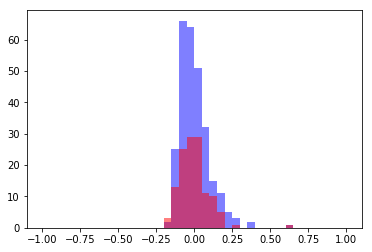

L1_S25_F2081


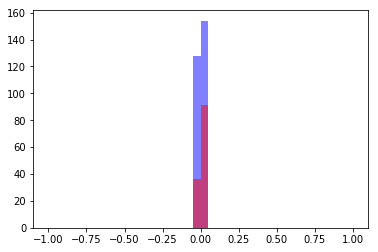

L1_S25_F2086


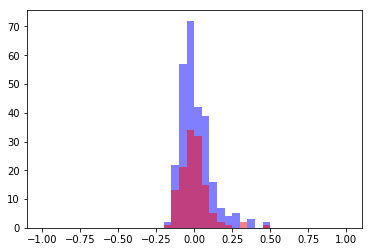

L1_S25_F2091


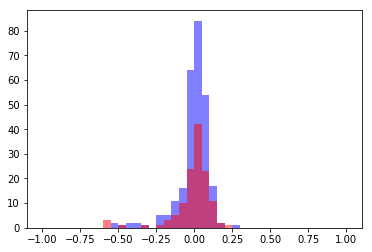

L1_S25_F2096


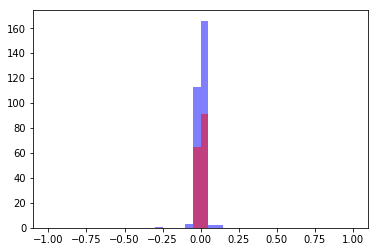

L1_S25_F2101


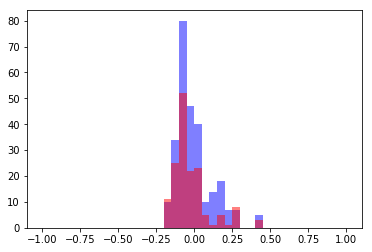

L1_S25_F2106


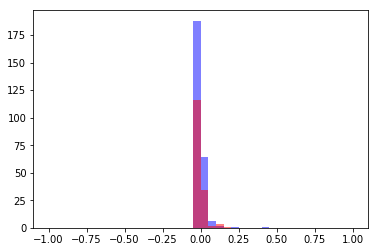

L1_S25_F2111


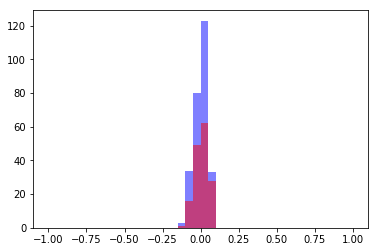

L1_S25_F2116


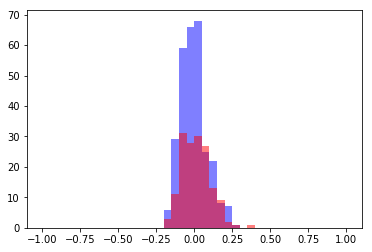

L1_S25_F2121


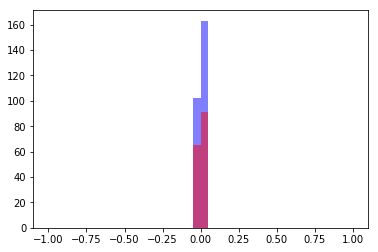

L1_S25_F2126


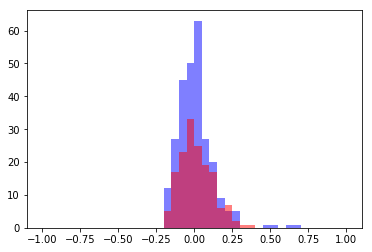

L1_S25_F2131


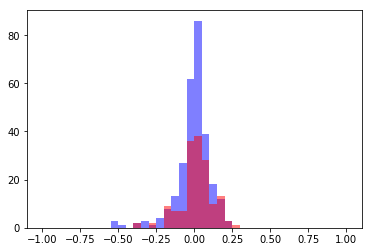

L1_S25_F2136


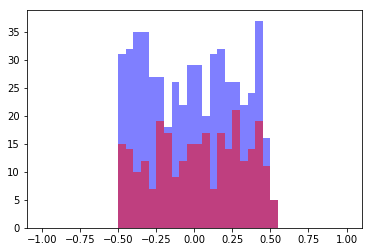

L1_S25_F2144


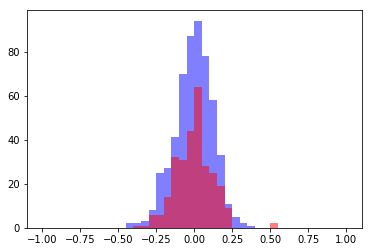

L1_S25_F2147


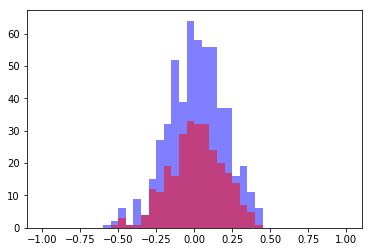

L1_S25_F2152


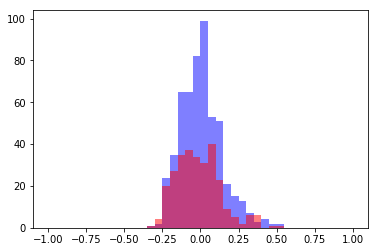

L1_S25_F2155


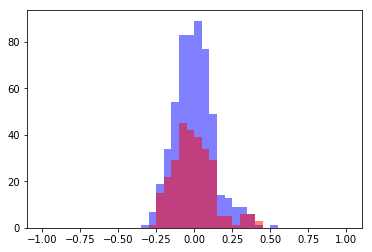

L1_S25_F2158


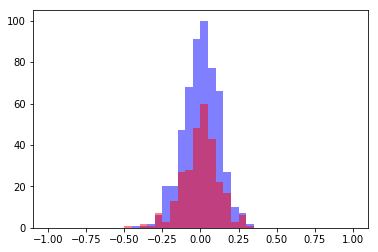

L1_S25_F2161


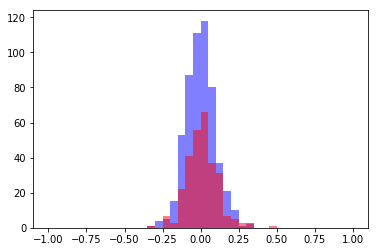

L1_S25_F2164


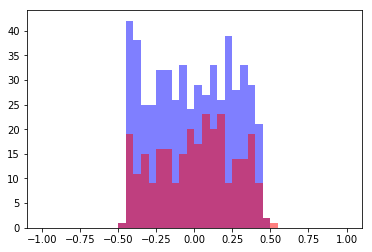

L1_S25_F2167


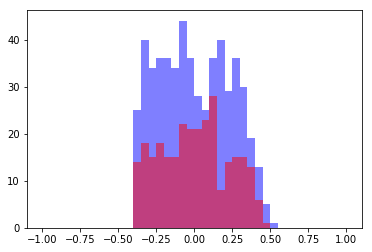

L1_S25_F2170


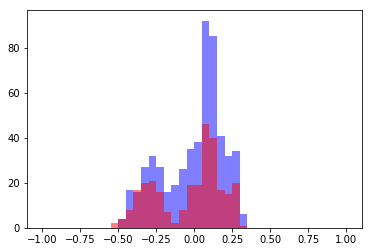

L1_S25_F2173


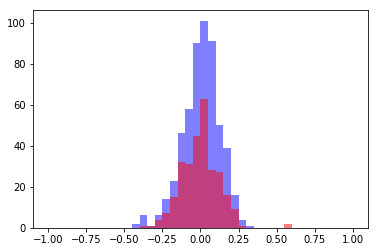

L1_S25_F2176


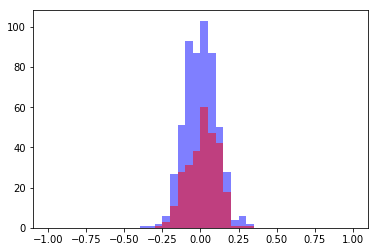

L1_S25_F2181


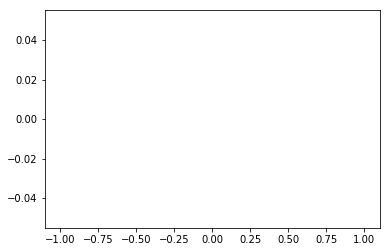

L1_S25_F2184


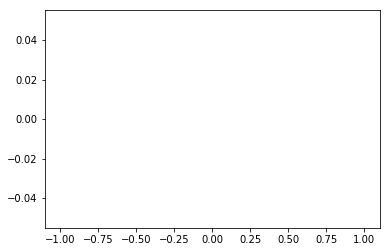

L1_S25_F2187


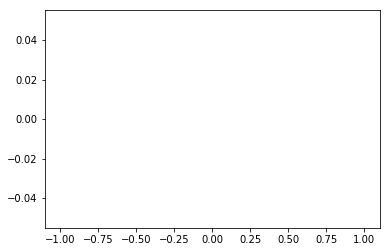

L1_S25_F2190


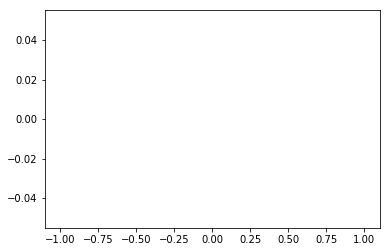

L1_S25_F2193


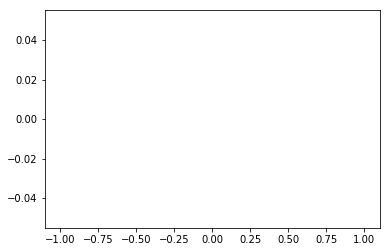

L1_S25_F2196


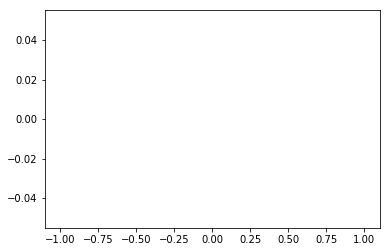

L1_S25_F2199


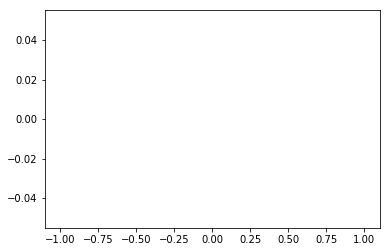

L1_S25_F2202


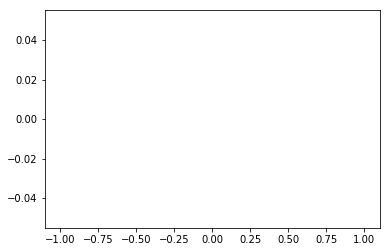

L1_S25_F2207


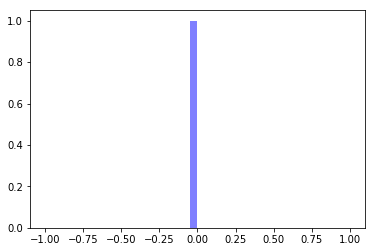

L1_S25_F2210


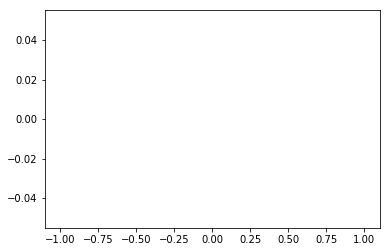

L1_S25_F2217


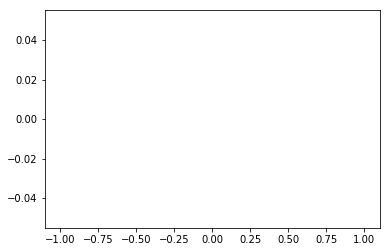

L1_S25_F2220


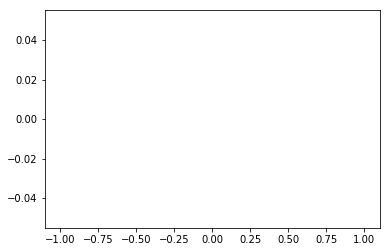

L1_S25_F2223


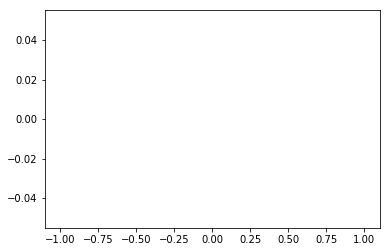

L1_S25_F2226


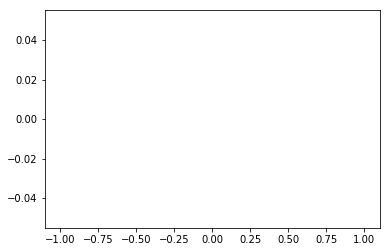

L1_S25_F2231


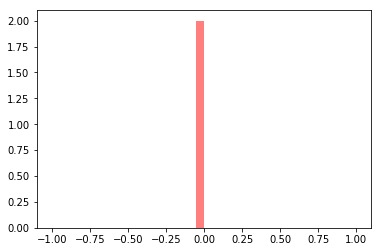

L1_S25_F2233


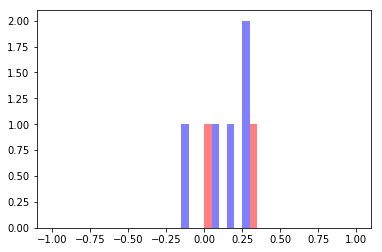

L1_S25_F2237


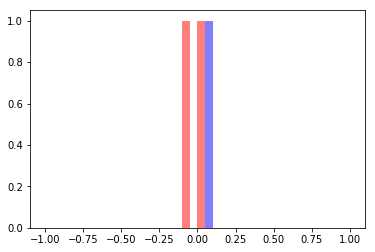

L1_S25_F2239


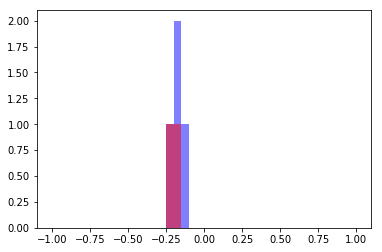

L1_S25_F2241


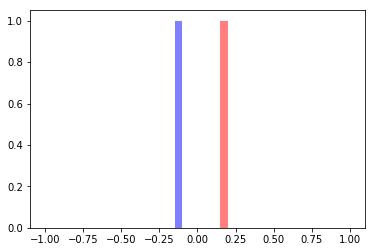

L1_S25_F2243


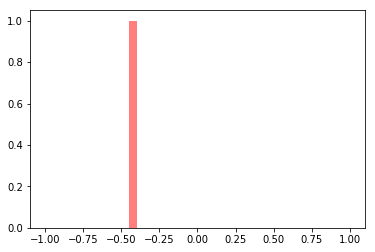

L1_S25_F2245


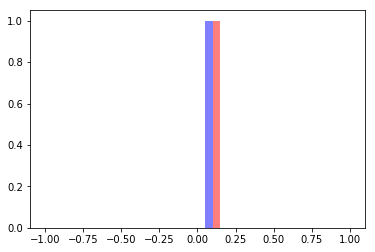

L1_S25_F2247


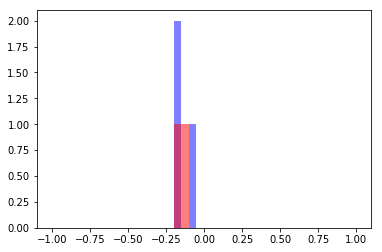

L1_S25_F2249


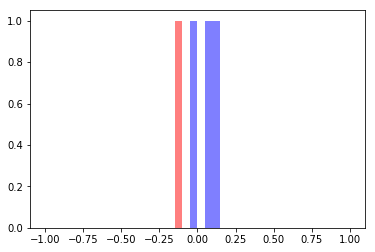

L1_S25_F2258


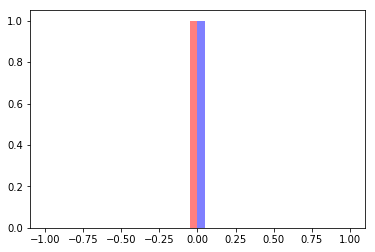

L1_S25_F2263


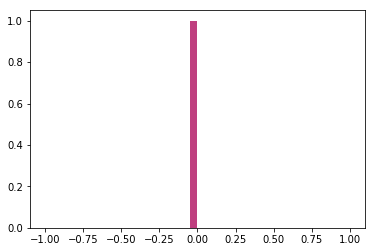

L1_S25_F2268


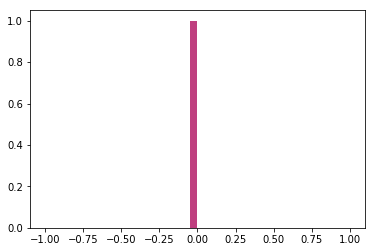

L1_S25_F2273


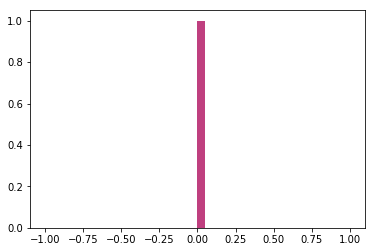

L1_S25_F2278


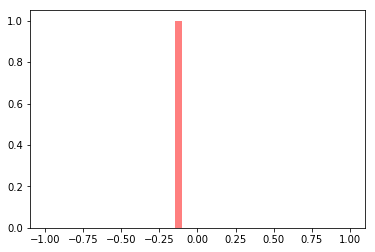

L1_S25_F2287


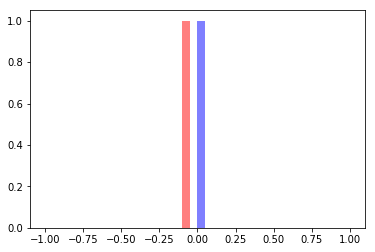

L1_S25_F2292


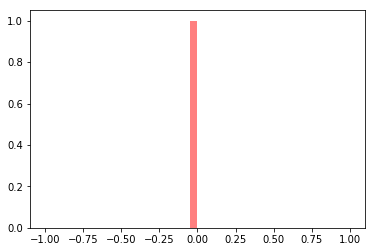

L1_S25_F2297


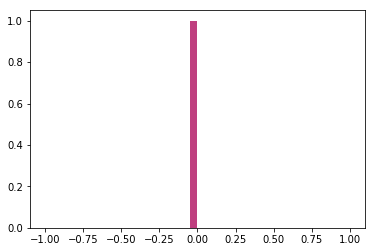

L1_S25_F2302


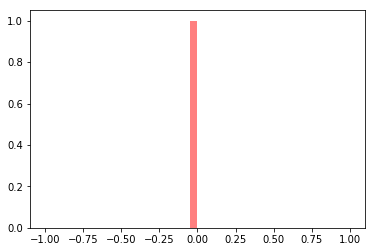

L1_S25_F2307


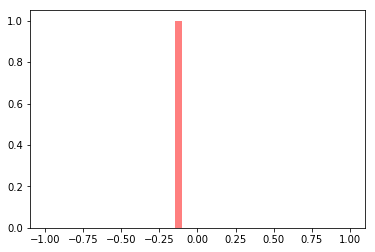

L1_S25_F2312


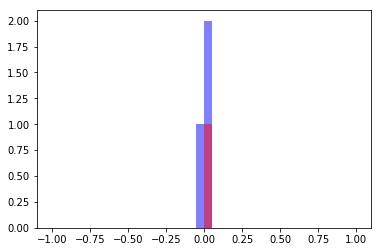

L1_S25_F2317


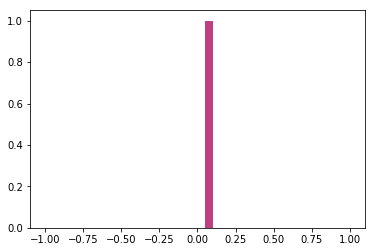

L1_S25_F2322


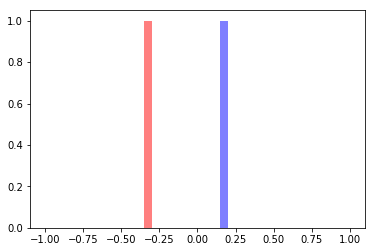

L1_S25_F2327


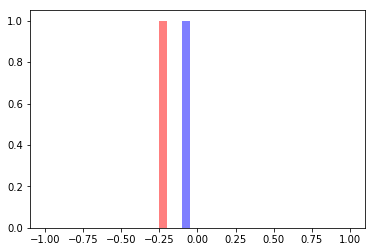

L1_S25_F2336


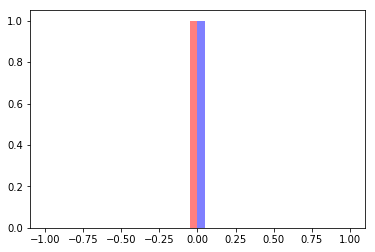

L1_S25_F2341


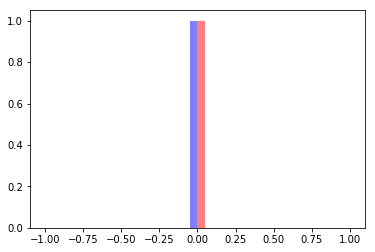

L1_S25_F2346


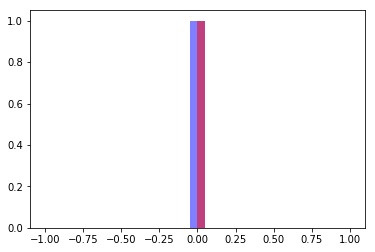

L1_S25_F2351


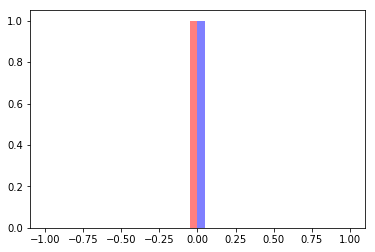

L1_S25_F2356


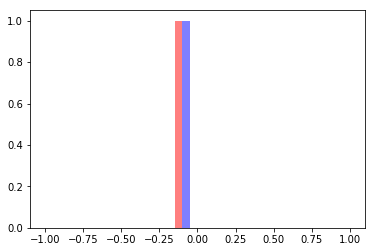

L1_S25_F2365


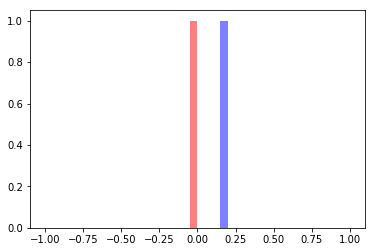

L1_S25_F2370


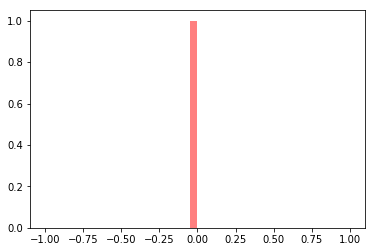

L1_S25_F2375


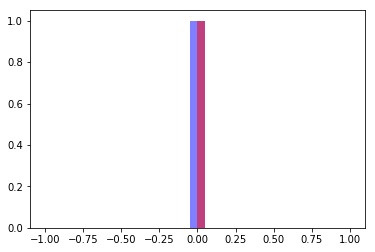

L1_S25_F2380


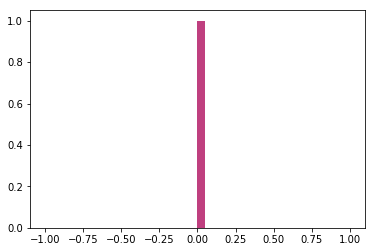

L1_S25_F2385


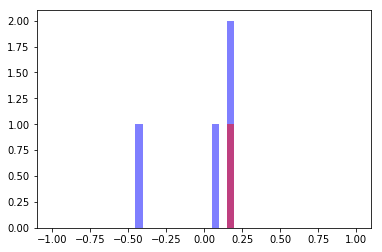

L1_S25_F2390


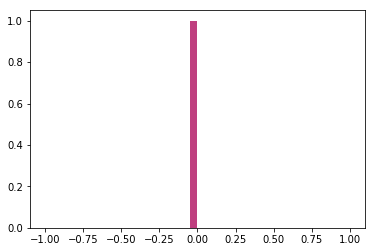

L1_S25_F2395


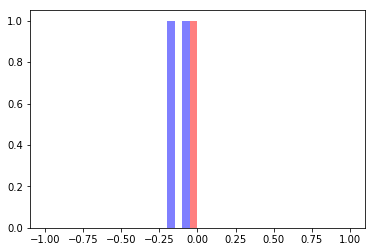

L1_S25_F2400


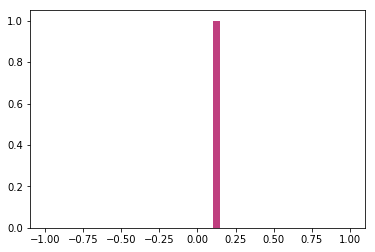

L1_S25_F2405


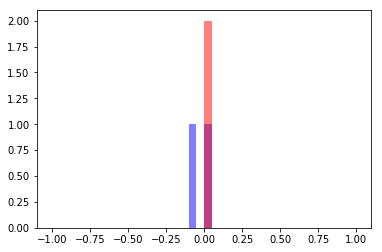

L1_S25_F2408


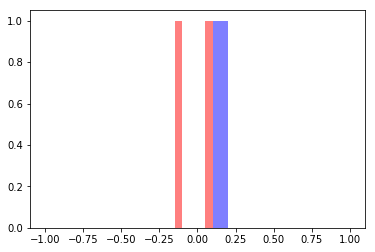

L1_S25_F2411


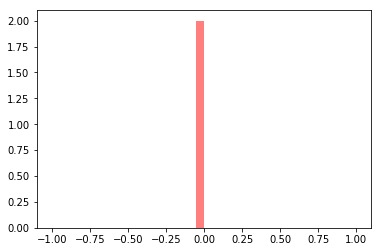

L1_S25_F2414


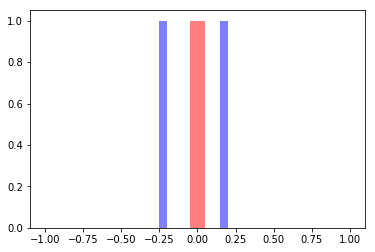

L1_S25_F2417


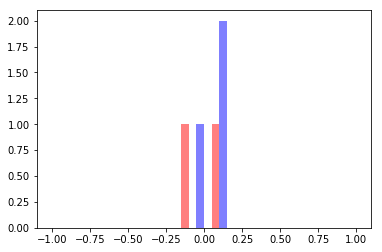

L1_S25_F2420


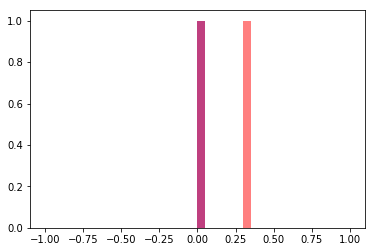

L1_S25_F2423


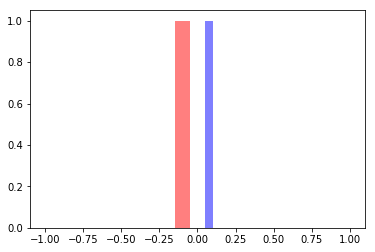

L1_S25_F2426


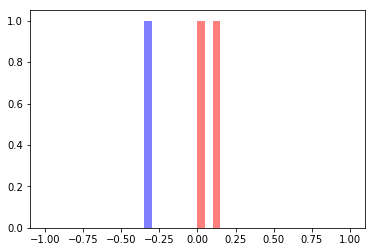

L1_S25_F2429


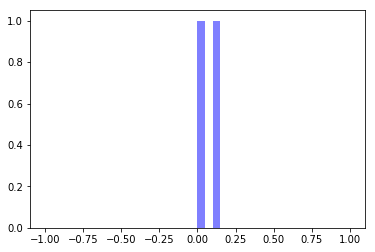

L1_S25_F2431


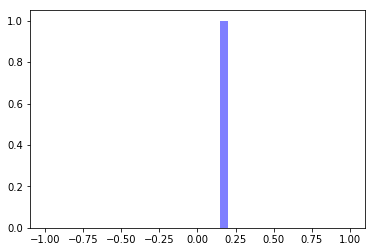

L1_S25_F2433


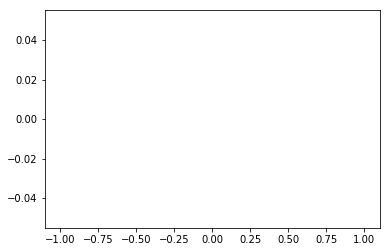

L1_S25_F2435


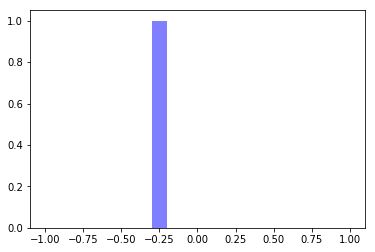

L1_S25_F2437


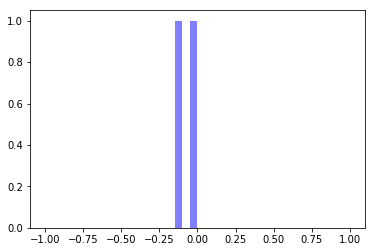

L1_S25_F2439


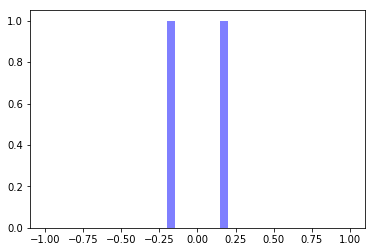

L1_S25_F2441


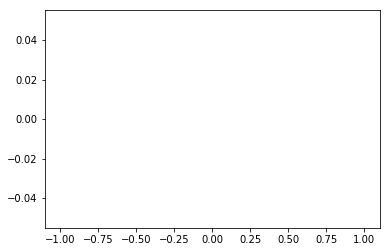

L1_S25_F2443


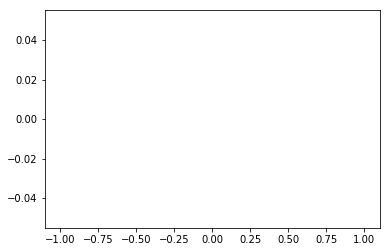

L1_S25_F2449


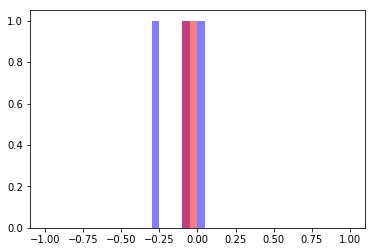

L1_S25_F2451


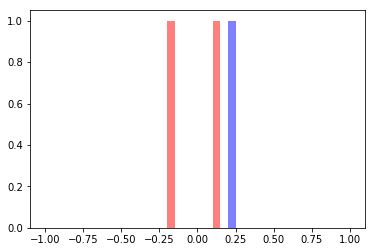

L1_S25_F2454


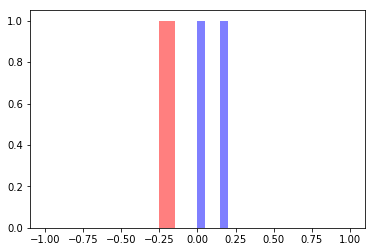

L1_S25_F2456


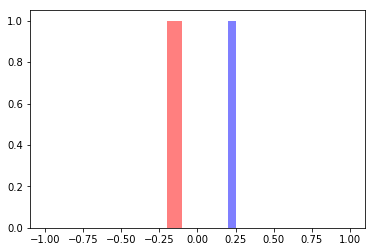

L1_S25_F2458


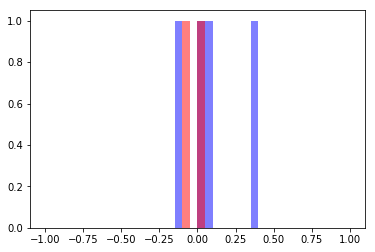

L1_S25_F2460


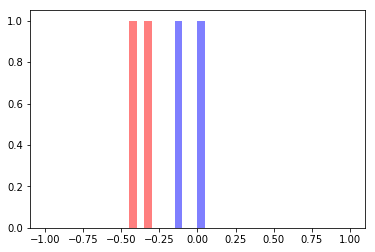

L1_S25_F2462


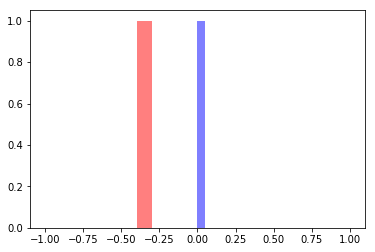

L1_S25_F2464


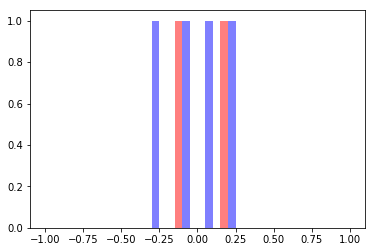

L1_S25_F2466


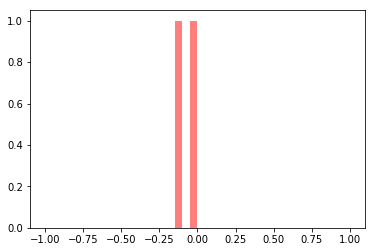

L1_S25_F2468


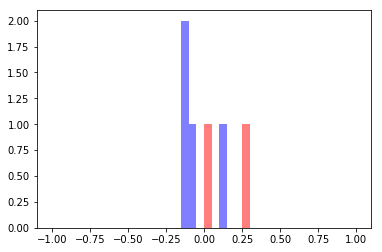

L1_S25_F2472


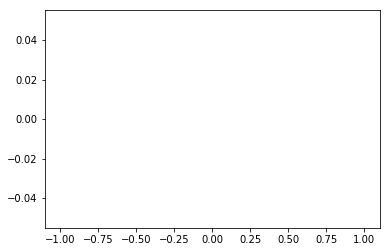

L1_S25_F2475


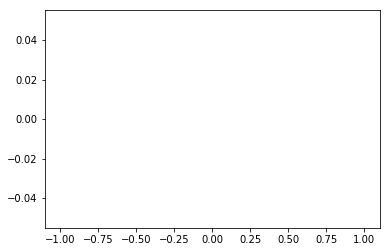

L1_S25_F2478


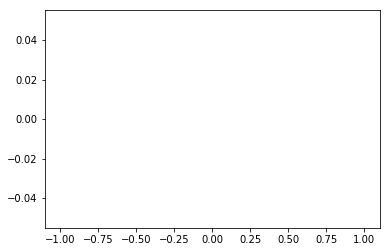

L1_S25_F2481


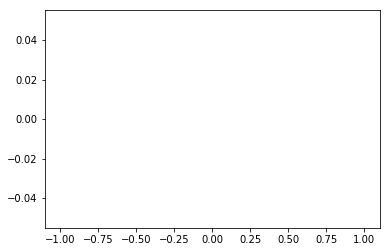

L1_S25_F2484


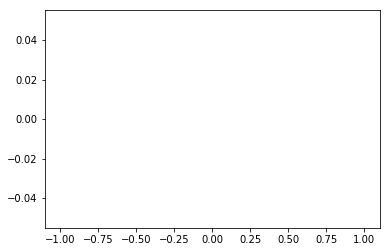

L1_S25_F2487


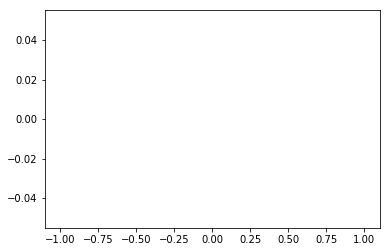

L1_S25_F2490


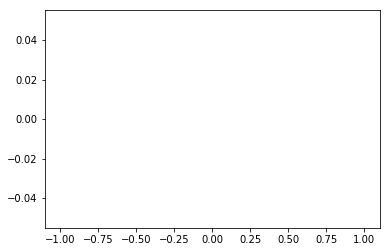

L1_S25_F2493


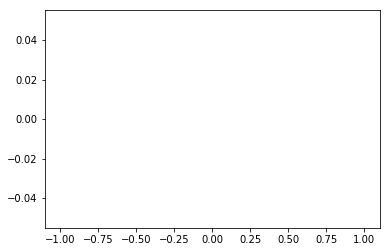

L1_S25_F2498


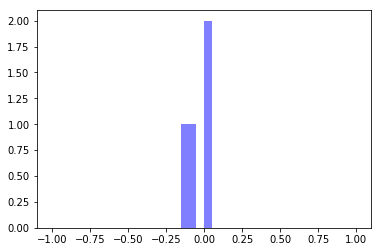

L1_S25_F2500


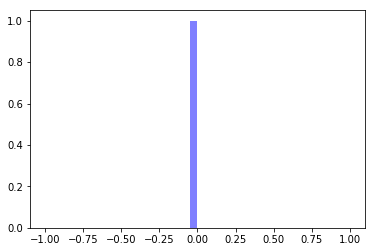

L1_S25_F2504


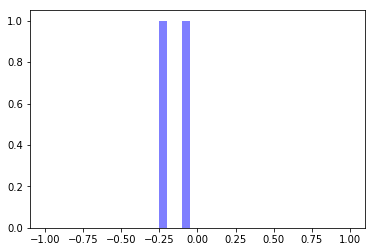

L1_S25_F2506


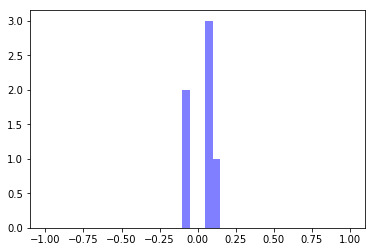

L1_S25_F2508


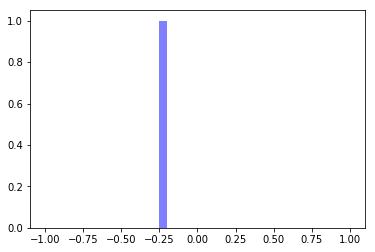

L1_S25_F2510


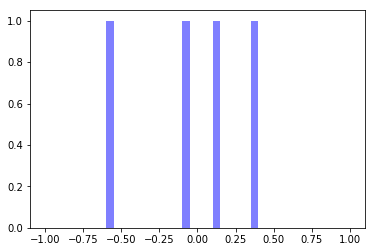

L1_S25_F2512


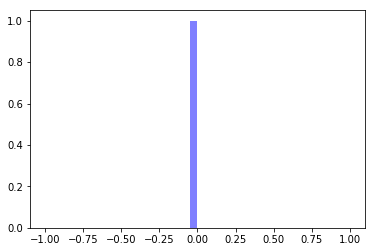

L1_S25_F2514


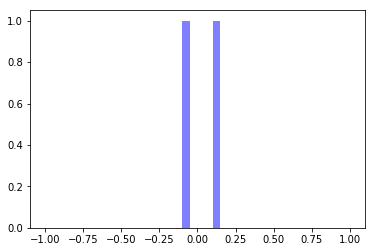

L1_S25_F2516


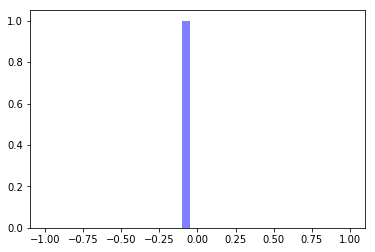

L1_S25_F2525


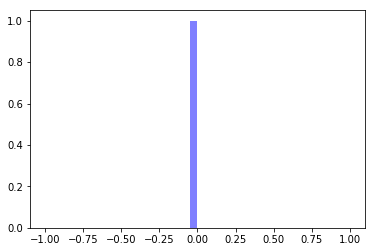

L1_S25_F2530


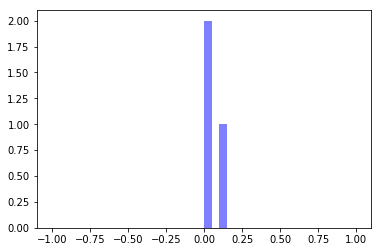

L1_S25_F2535


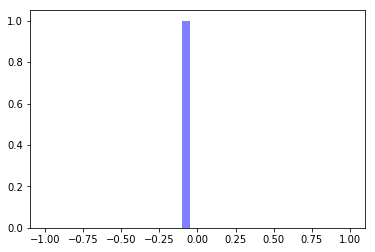

L1_S25_F2540


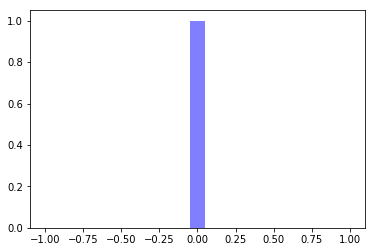

L1_S25_F2545


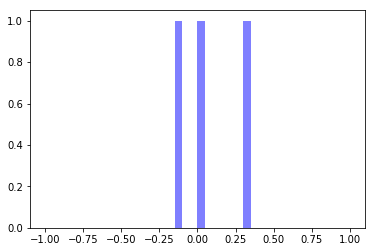

L1_S25_F2554


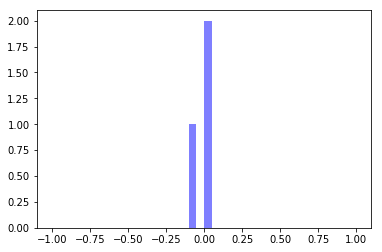

L1_S25_F2559


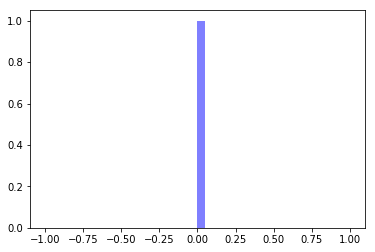

L1_S25_F2564


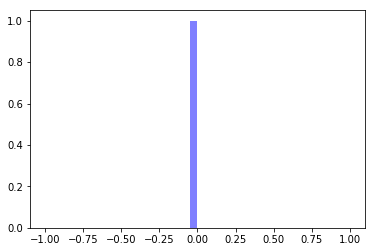

L1_S25_F2569


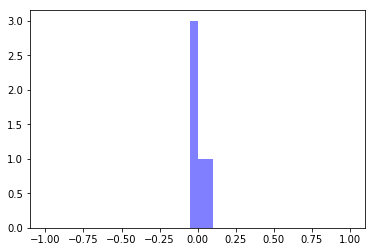

L1_S25_F2574


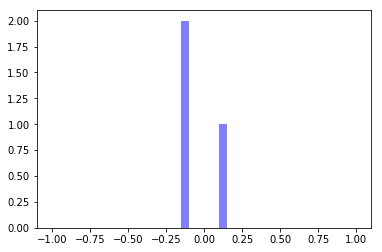

L1_S25_F2579


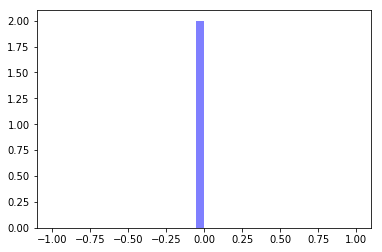

L1_S25_F2584


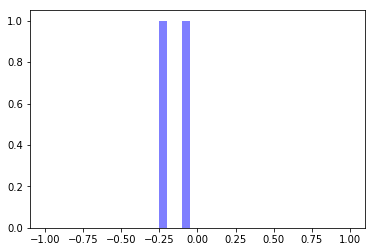

L1_S25_F2589


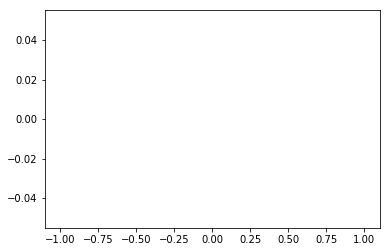

L1_S25_F2594


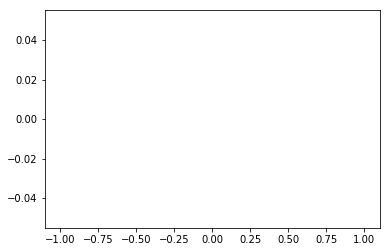

L1_S25_F2603


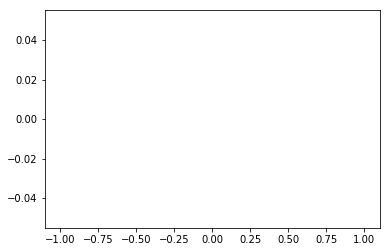

L1_S25_F2608


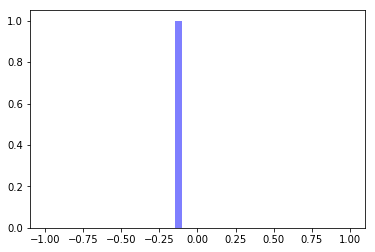

L1_S25_F2613


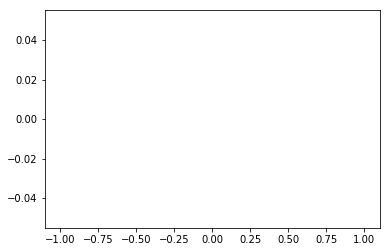

L1_S25_F2618


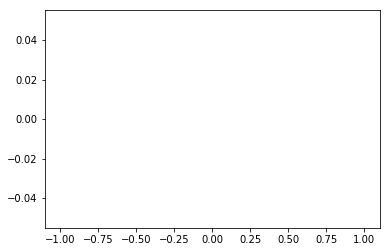

L1_S25_F2623


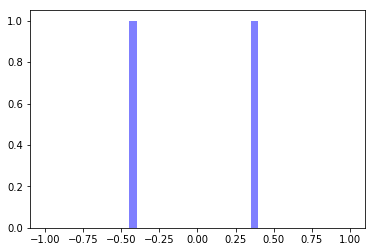

L1_S25_F2632


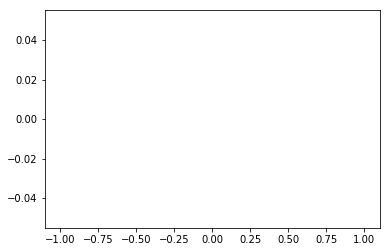

L1_S25_F2637


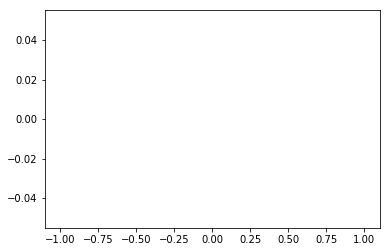

L1_S25_F2642


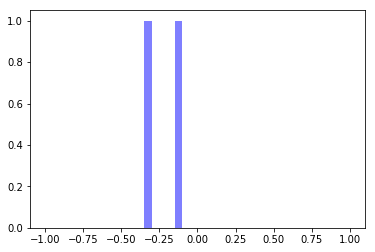

L1_S25_F2647


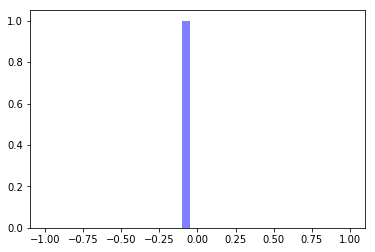

L1_S25_F2652


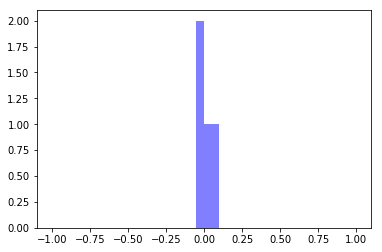

L1_S25_F2657


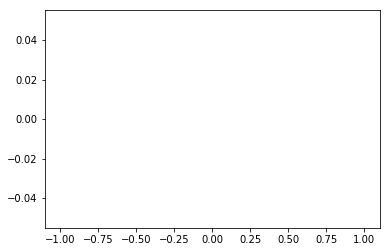

L1_S25_F2662


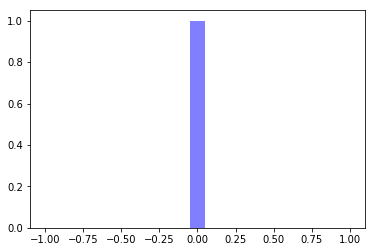

L1_S25_F2667


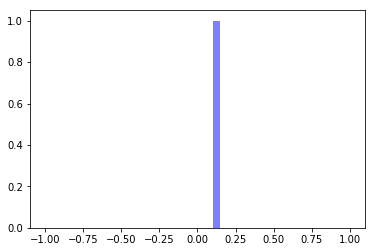

L1_S25_F2672


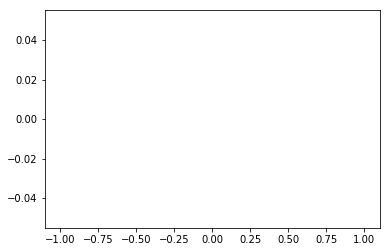

L1_S25_F2677


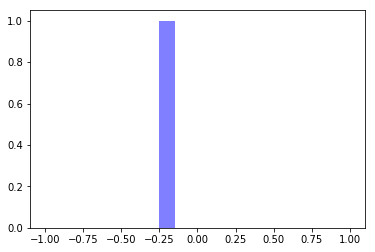

L1_S25_F2682


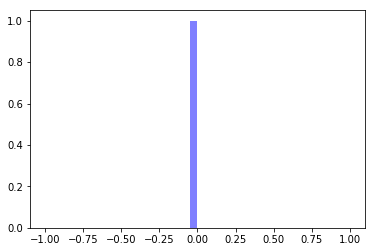

L1_S25_F2687


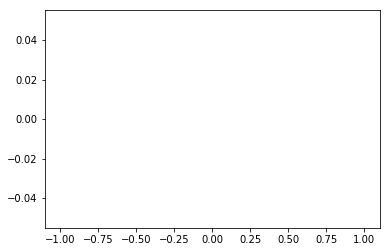

L1_S25_F2692


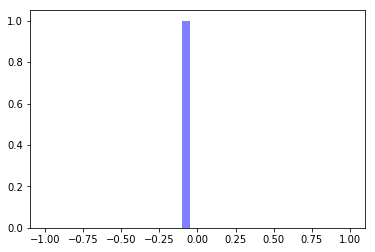

L1_S25_F2697


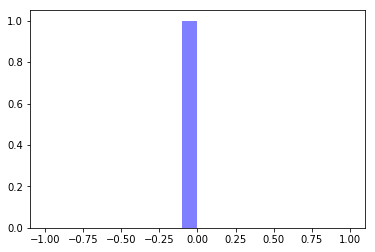

L1_S25_F2702


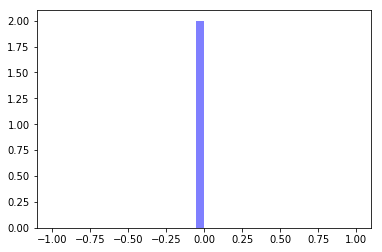

L1_S25_F2707


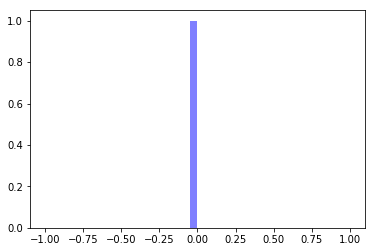

L1_S25_F2712


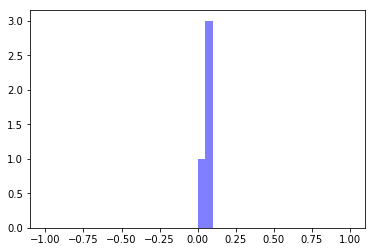

L1_S25_F2714


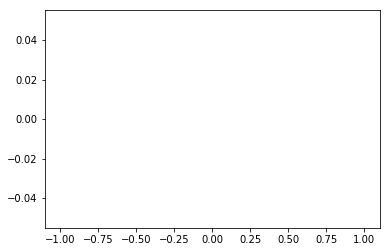

L1_S25_F2716


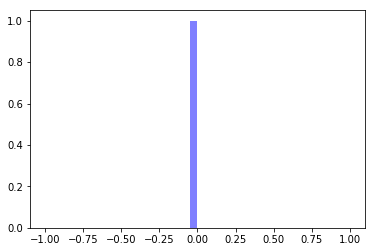

L1_S25_F2718


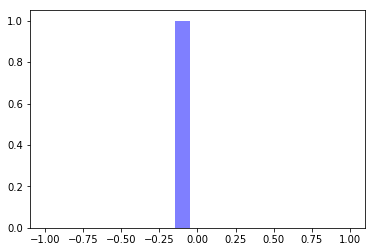

L1_S25_F2720


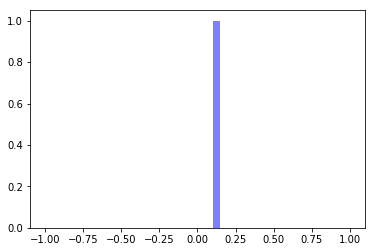

L1_S25_F2722


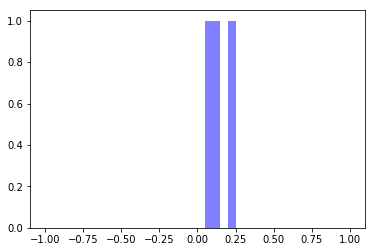

L1_S25_F2724


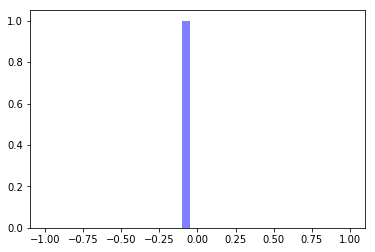

L1_S25_F2726


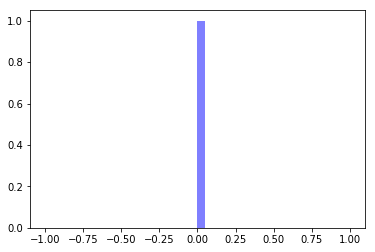

L1_S25_F2732


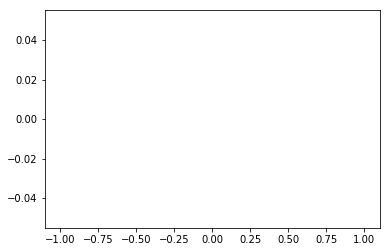

L1_S25_F2734


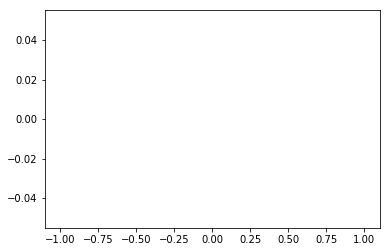

L1_S25_F2737


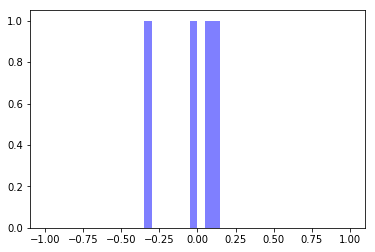

L1_S25_F2739


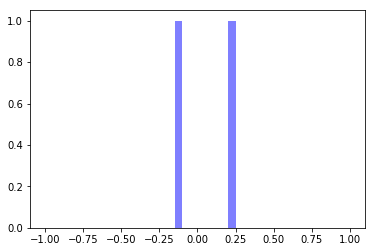

L1_S25_F2741


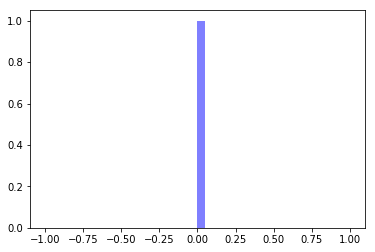

L1_S25_F2743


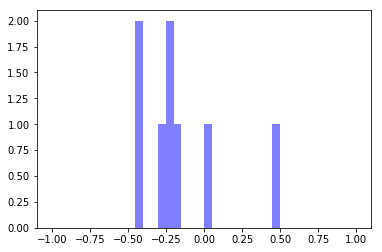

L1_S25_F2745


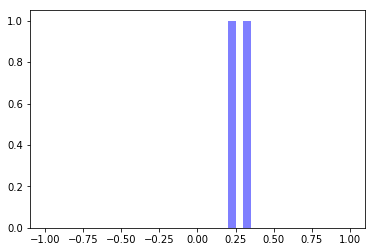

L1_S25_F2747


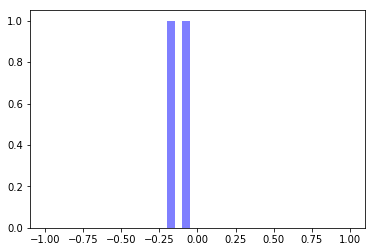

L1_S25_F2749


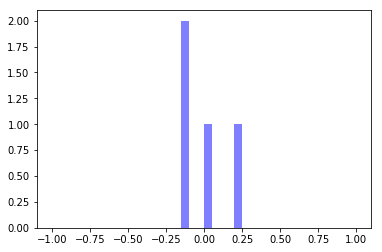

L1_S25_F2751


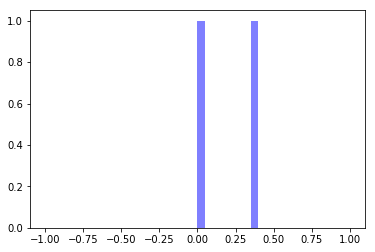

L1_S25_F2755


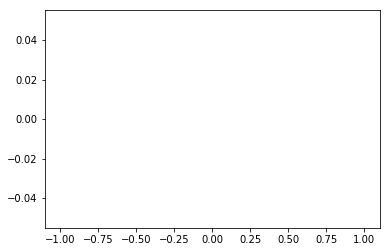

L1_S25_F2758


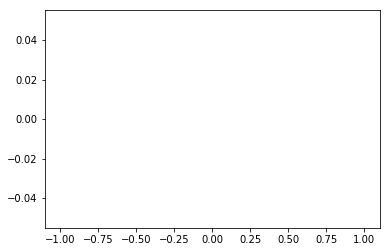

L1_S25_F2761


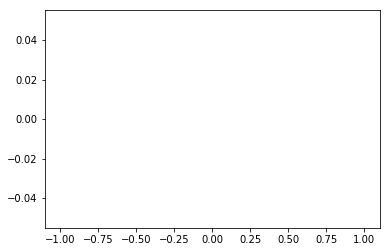

L1_S25_F2764


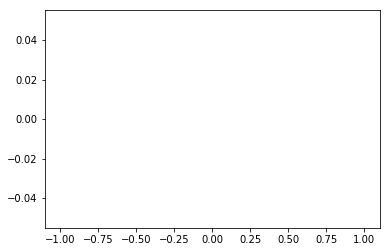

L1_S25_F2767


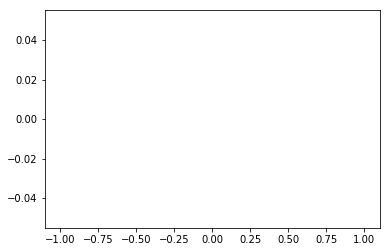

L1_S25_F2770


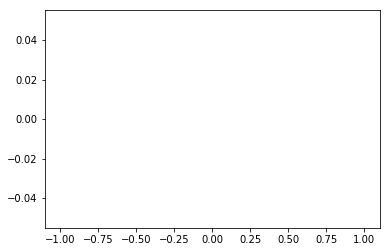

L1_S25_F2773


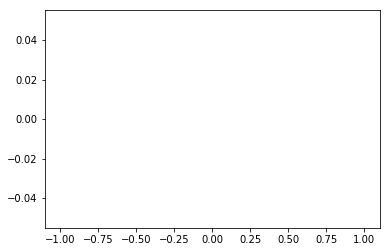

L1_S25_F2776


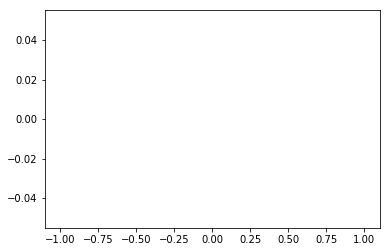

L1_S25_F2781


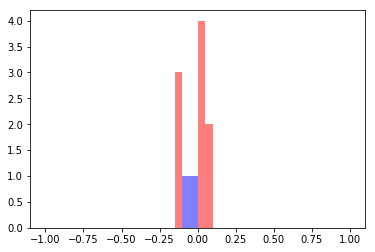

L1_S25_F2783


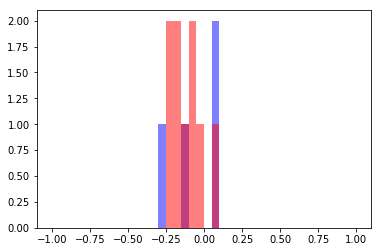

L1_S25_F2787


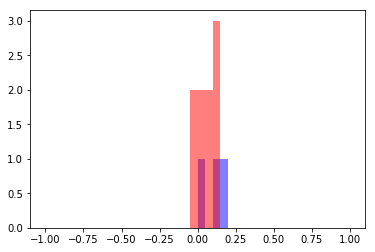

L1_S25_F2789


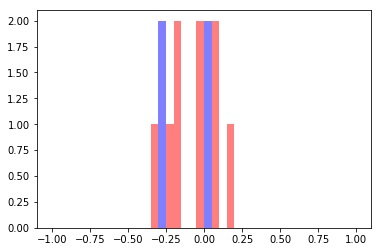

L1_S25_F2791


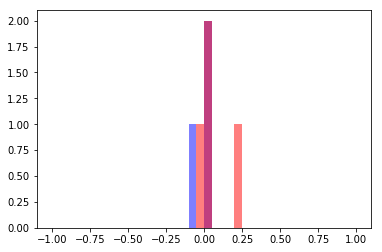

L1_S25_F2793


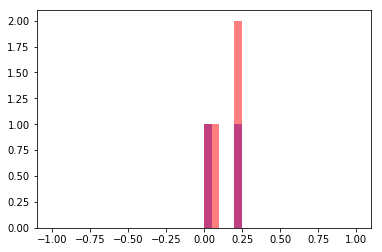

L1_S25_F2795


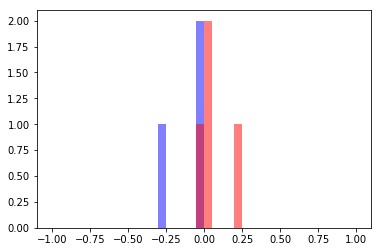

L1_S25_F2797


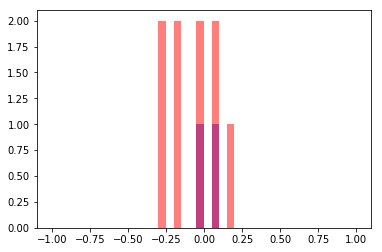

L1_S25_F2799


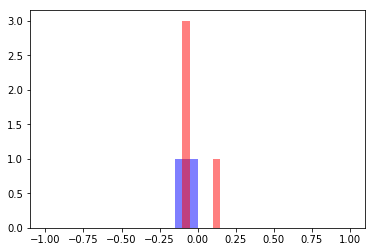

L1_S25_F2808


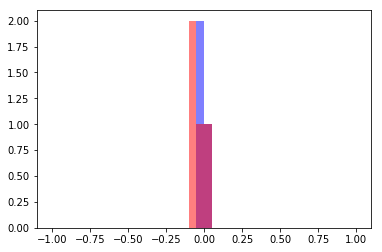

L1_S25_F2813


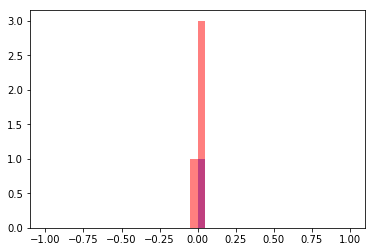

L1_S25_F2818


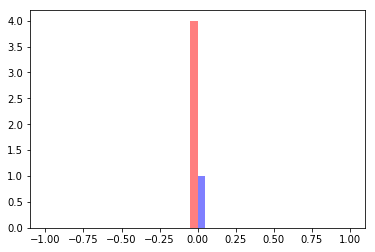

L1_S25_F2823


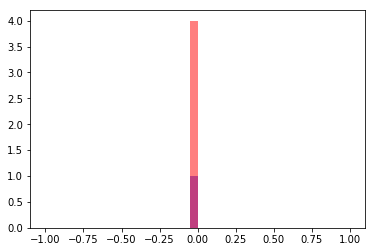

L1_S25_F2828


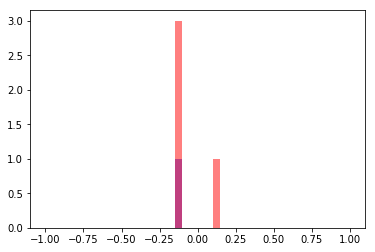

L1_S25_F2837


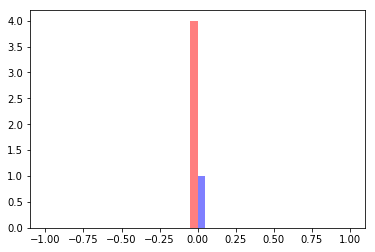

L1_S25_F2842


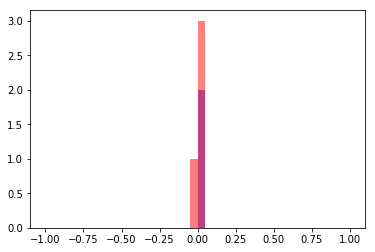

L1_S25_F2847


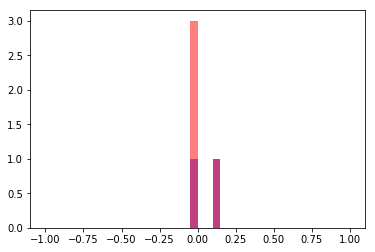

L1_S25_F2852


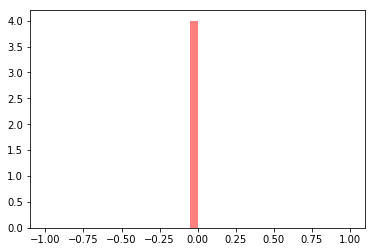

L1_S25_F2857


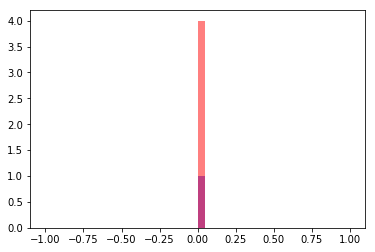

L1_S25_F2862


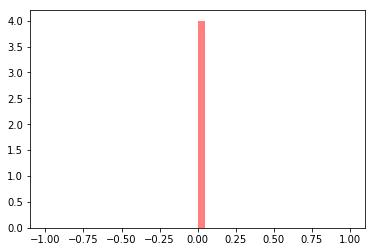

L1_S25_F2867


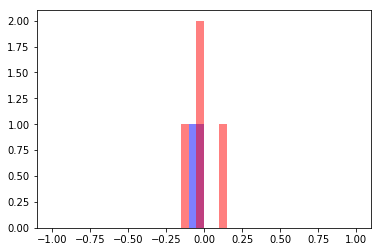

L1_S25_F2872


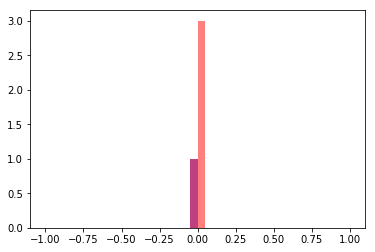

L1_S25_F2877


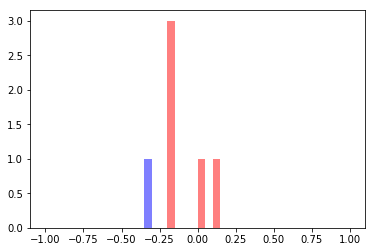

L1_S25_F2886


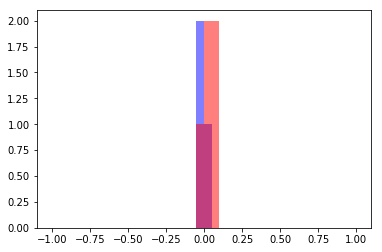

L1_S25_F2891


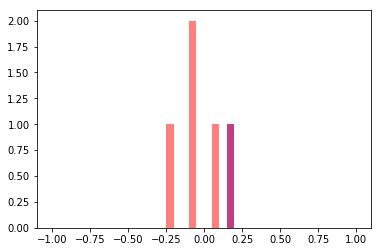

L1_S25_F2896


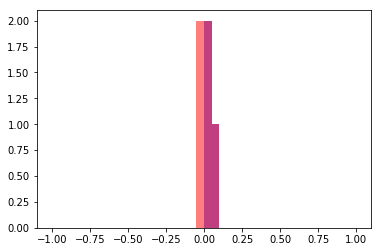

L1_S25_F2901


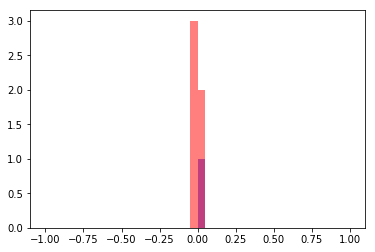

L1_S25_F2906


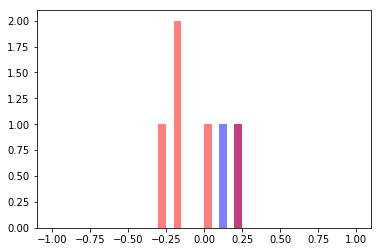

L1_S25_F2915


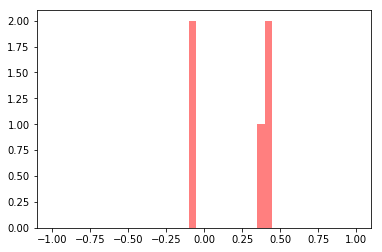

L1_S25_F2920


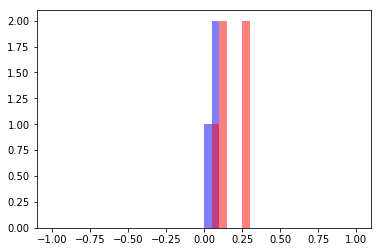

L1_S25_F2925


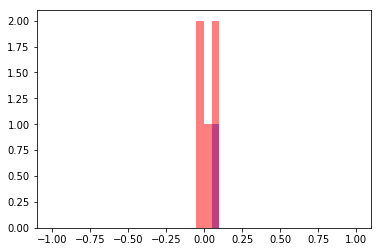

L1_S25_F2930


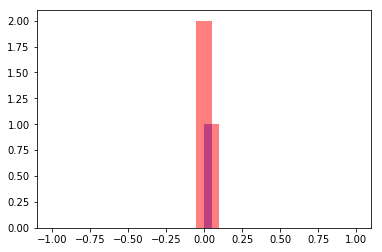

L1_S25_F2935


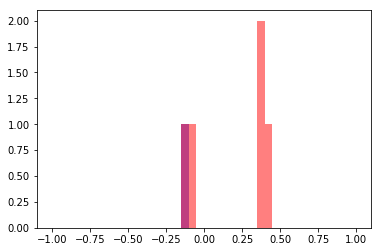

L1_S25_F2940


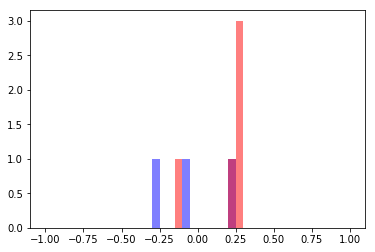

L1_S25_F2945


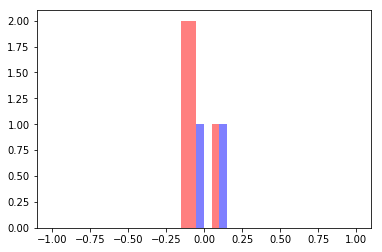

L1_S25_F2950


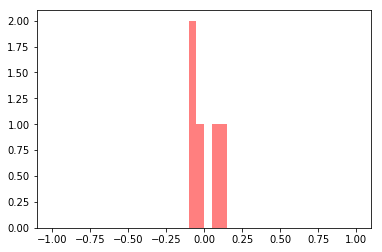

L1_S25_F2955


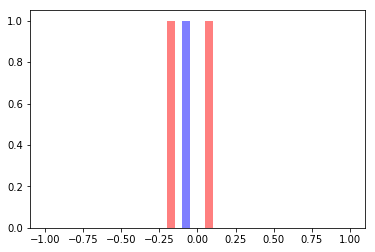

L1_S25_F2960


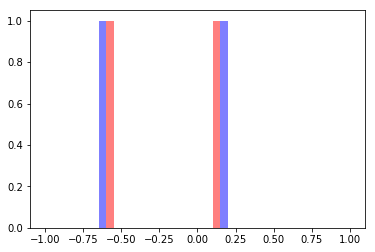

L1_S25_F2965


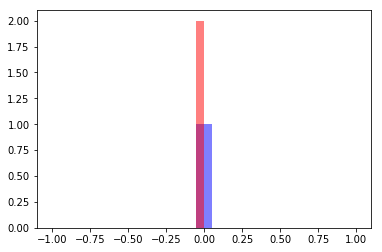

L1_S25_F2970


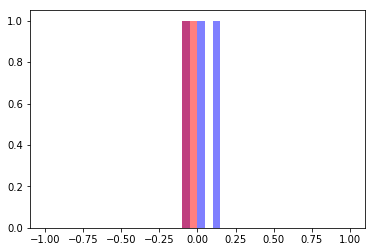

L1_S25_F2975


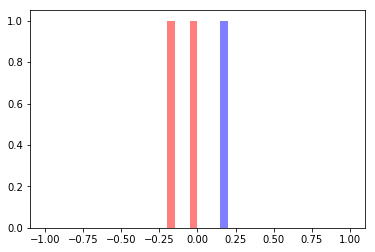

L1_S25_F2980


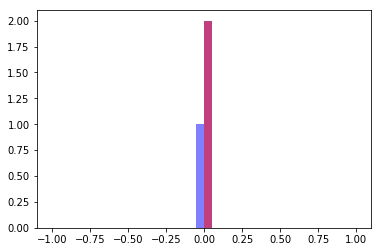

L1_S25_F2985


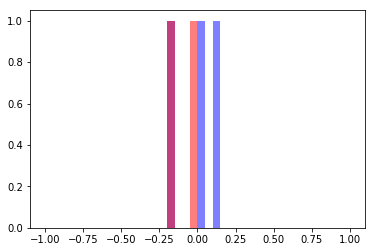

L1_S25_F2990


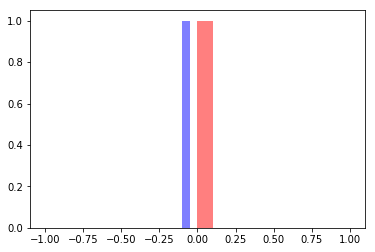

L1_S25_F2995


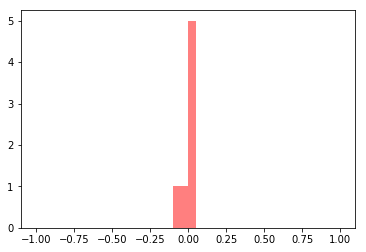

L1_S25_F2997


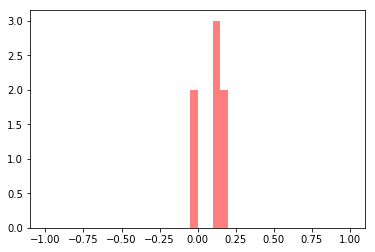

L1_S25_F2999


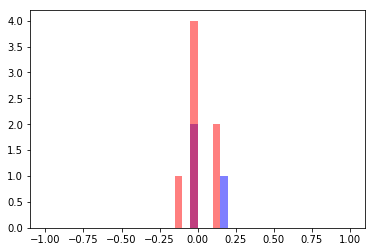

L1_S25_F3001


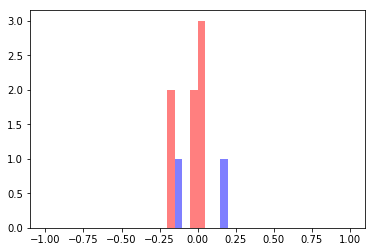

L1_S25_F3003


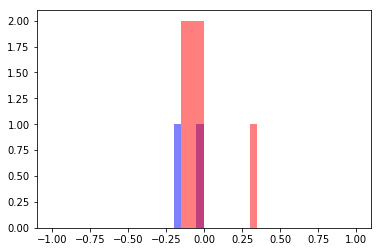

L1_S25_F3005


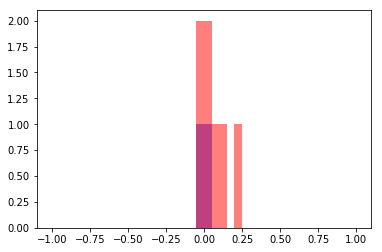

L1_S25_F3007


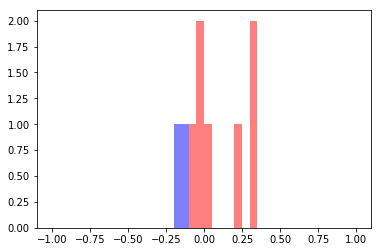

L1_S25_F3009


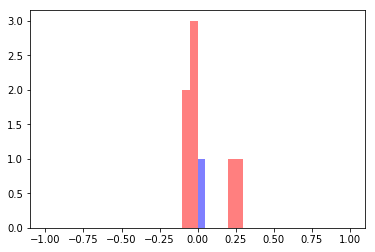

L1_S25_F3015


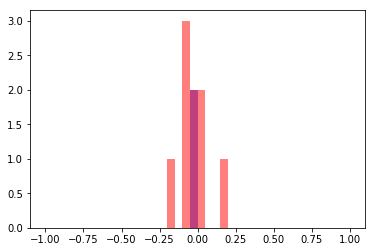

L1_S25_F3017


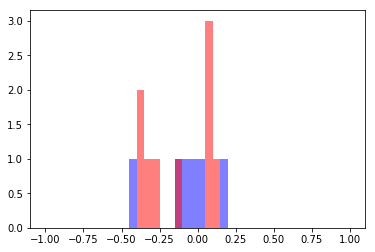

L1_S25_F3020


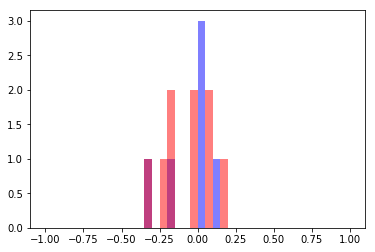

L1_S25_F3022


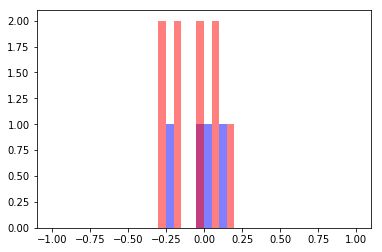

L1_S25_F3024


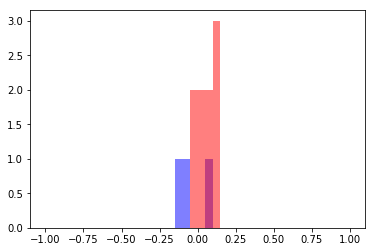

L1_S25_F3026


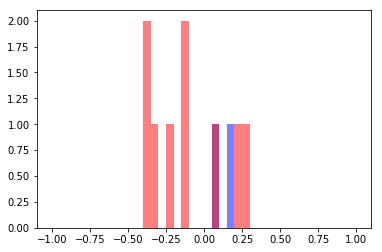

L1_S25_F3028


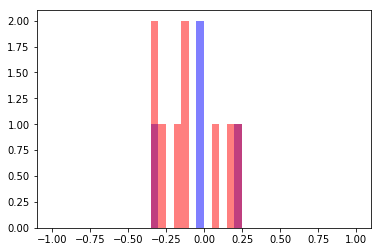

L1_S25_F3030


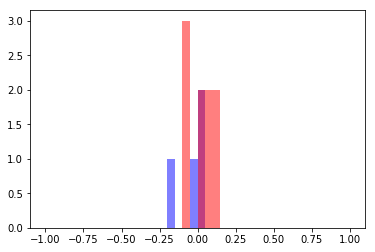

L1_S25_F3032


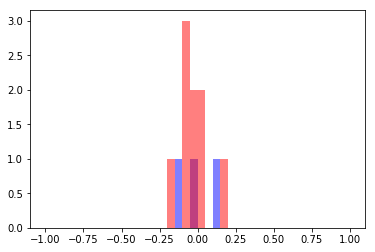

L1_S25_F3034


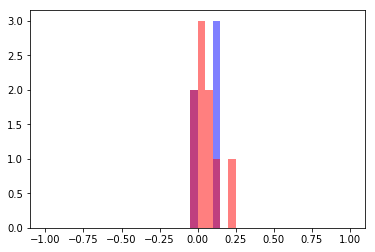

In [92]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_25.csv", 'L1_S25_D1854')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [93]:
df_pass_with_numeric.describe()

Id      L0_S0_D1     L0_S1_D26     L0_S2_D34     L0_S3_D70  \
count  5.546600e+04  55466.000000  55466.000000  55466.000000  55466.000000   
mean   1.176198e+06      0.006545      0.006545      0.003137      0.003407   
std    6.766642e+05      0.080634      0.080634      0.055922      0.058275   
min    5.200000e+01      0.000000      0.000000      0.000000      0.000000   
25%    5.967445e+05      0.000000      0.000000      0.000000      0.000000   
50%    1.161670e+06      0.000000      0.000000      0.000000      0.000000   
75%    1.765389e+06      0.000000      0.000000      0.000000      0.000000   
max    2.367460e+06      1.000000      1.000000      1.000000      1.000000   

         L0_S4_D106    L0_S5_D115    L0_S6_D120    L0_S7_D137    L0_S8_D145  \
count  55466.000000  55466.000000  55466.000000  55466.000000  55466.000000   
mean       0.003245      0.003299      0.003119      0.003426      0.006545   
std        0.056875      0.057345      0.055762      0.058428      0.080634   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           ...       L1_S25_F3015  L1_S25_F3017  L1_S25_F3020  L1_S25_F3022  \
count      ...         341.000000    341.000000    341.000000    341.000000   
mean       ...          -0.003592      0.013076     -0.001938     -0.013625   
std        ...           0.137655      0.165347      0.112052      0.115594   
min        ...          -0.521000     -0.437000     -0.409000     -0.403000   
25%        ...          -0.067000     -0.103000     -0.041000     -0.067000   
50%        ...           0.011000      0.030000      0.025000     -0.001000   
75%        ...           0.094000      0.130000      0.069000      0.057000   
max        ...           0.284000      0.414000      0.292000      0.319000   

       L1_S25_F3024  L1_S25_F3026  L1_S25_F3028  L1_S25_F3030  L1_S25_F3032  \
count    341.000000    341.000000    341.000000    341.000000    341.000000   
mean       0.010144     -0.001868     -0.001126      0.005405     -0.003334   
std        0.116845      0.279298      0.234547      0.078202      0.134986   
min       -0.325000     -0.448000     -0.375000     -0.202000     -0.490000   
25%       -0.058000     -0.289000     -0.245000     -0.045000     -0.069000   
50%        0.003000      0.044000      0.034000      0.016000      0.009000   
75%        0.076000      0.240000      0.196000      0.062000      0.094000   
max        0.459000      0.465000      0.449000      0.165000      0.294000   

       L1_S25_F3034  
count    341.000000  
mean       0.017434  
std        0.080989  
min       -0.188000  
25%       -0.038000  
50%        0.016000  
75%        0.067000  
max        0.241000  

[8 rows x 340 columns]

### station 26 編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L2_S26_F3036', 'L2_S26_F3040', 'L2_S26_F3047', 'L2_S26_F3051',
    

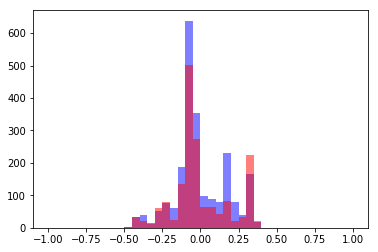

L2_S26_F3040


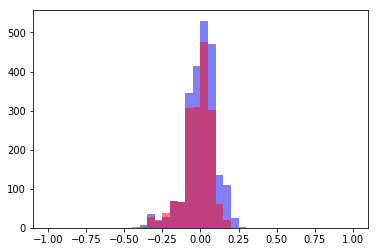

L2_S26_F3047


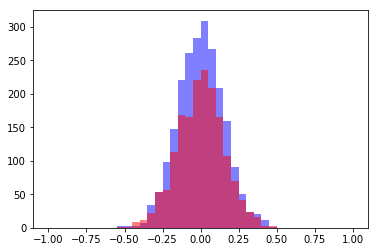

L2_S26_F3051


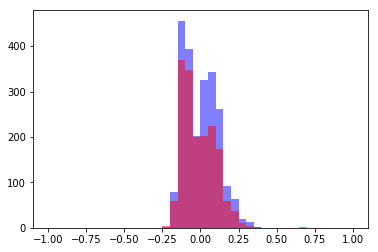

L2_S26_F3055


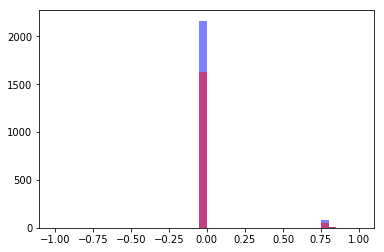

L2_S26_F3062


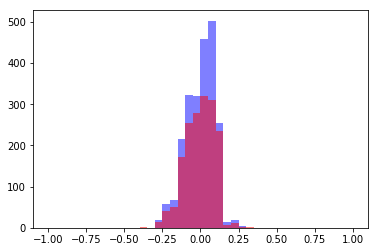

L2_S26_F3069


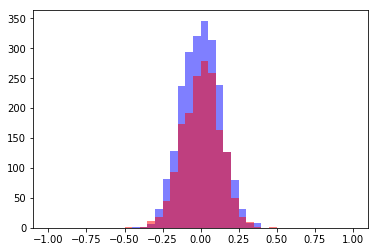

L2_S26_F3073


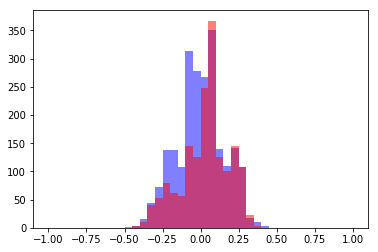

L2_S26_F3077


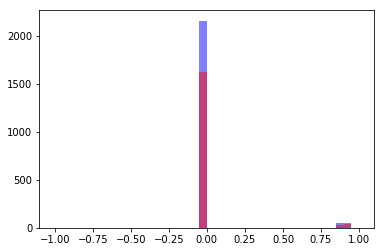

L2_S26_F3106


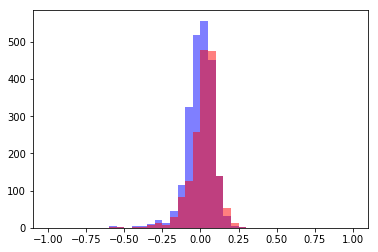

L2_S26_F3113


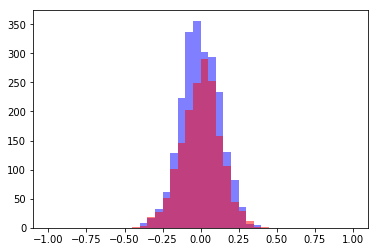

L2_S26_F3117


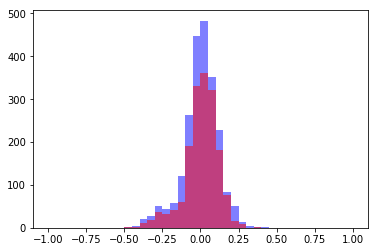

L2_S26_F3121


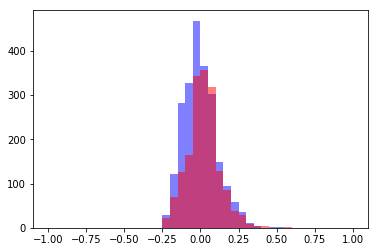

L2_S26_F3125


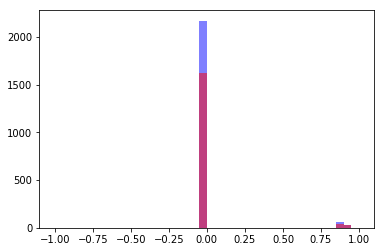

In [94]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_26.csv", 'L2_S26_D3037')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [96]:
df_pass_with_numeric.describe()

Id       L0_S0_D1      L0_S1_D26      L0_S2_D34  \
count  2.270110e+05  227011.000000  227011.000000  227011.000000   
mean   1.189239e+06       0.207078       0.207043       0.103797   
std    6.781649e+05       0.405213       0.405187       0.304997   
min    1.600000e+01       0.000000       0.000000       0.000000   
25%    6.073495e+05       0.000000       0.000000       0.000000   
50%    1.188021e+06       0.000000       0.000000       0.000000   
75%    1.776404e+06       0.000000       0.000000       0.000000   
max    2.367490e+06       1.000000       1.000000       1.000000   

           L0_S3_D70     L0_S4_D106     L0_S5_D115     L0_S6_D120  \
count  227011.000000  227011.000000  227011.000000  227011.000000   
mean        0.103427       0.103819       0.103524       0.103876   
std         0.304516       0.305026       0.304642       0.305100   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          L0_S7_D137     L0_S8_D145      ...         L2_S26_F3055  \
count  227011.000000  227011.000000      ...        227011.000000   
mean        0.103396       0.206990      ...             0.000388   
std         0.304476       0.405149      ...             0.157357   
min         0.000000       0.000000      ...            -0.031000   
25%         0.000000       0.000000      ...            -0.031000   
50%         0.000000       0.000000      ...            -0.031000   
75%         0.000000       0.000000      ...            -0.031000   
max         1.000000       1.000000      ...             0.916000   

        L2_S26_F3062   L2_S26_F3069   L2_S26_F3073   L2_S26_F3077  \
count  227011.000000  227011.000000  227011.000000  227011.000000   
mean        0.000083      -0.000212      -0.000021       0.000471   
std         0.096366       0.121284       0.156228       0.178466   
min        -0.503000      -0.496000      -0.538000      -0.035000   
25%        -0.075000      -0.084000      -0.093000      -0.035000   
50%         0.017000       0.001000       0.006000      -0.035000   
75%         0.074000       0.082000       0.090000      -0.035000   
max         0.483000       0.503000       0.461000       0.961000   

        L2_S26_F3106   L2_S26_F3113   L2_S26_F3117   L2_S26_F3121  \
count  227011.000000  227011.000000  227011.000000  227011.000000   
mean        0.000163       0.000322       0.000396      -0.000215   
std         0.091039       0.124233       0.115655       0.106453   
min        -0.657000      -0.515000      -0.540000      -0.333000   
25%        -0.046000      -0.083000      -0.054000      -0.068000   
50%         0.009000       0.001000       0.010000      -0.012000   
75%         0.059000       0.083000       0.074000       0.068000   
max         0.324000       0.485000       0.460000       0.624000   

        L2_S26_F3125  
count  227011.000000  
mean        0.000443  
std         0.175635  
min        -0.034000  
25%        -0.034000  
50%        -0.034000  
75%        -0.034000  
max         0.966000  

[8 rows x 70 columns]

### station 27編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L2_S27_F3129', 'L2_S27_F3133', 'L2_S27_F3140', 'L2_S27_F3144',
    

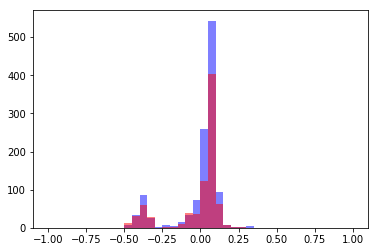

L2_S27_F3133


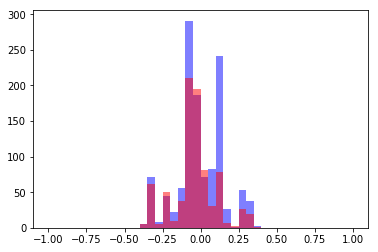

L2_S27_F3140


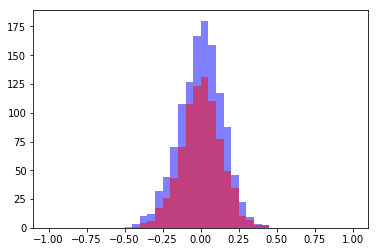

L2_S27_F3144


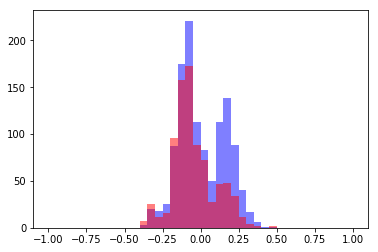

L2_S27_F3148


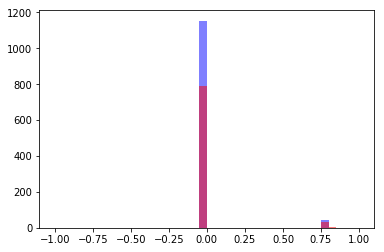

L2_S27_F3155


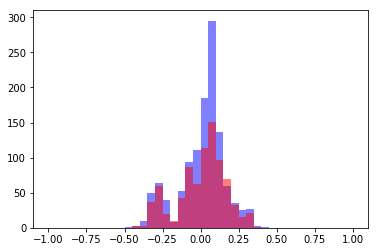

L2_S27_F3162


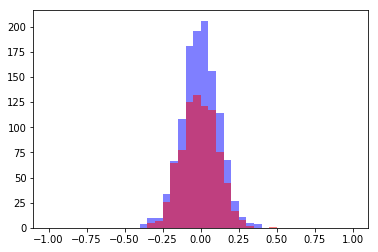

L2_S27_F3166


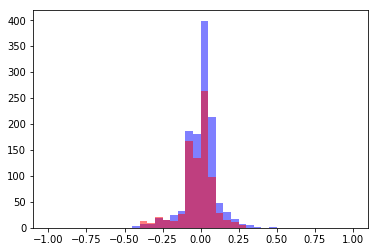

L2_S27_F3170


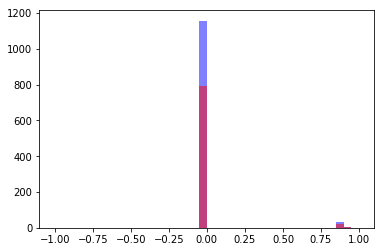

L2_S27_F3199


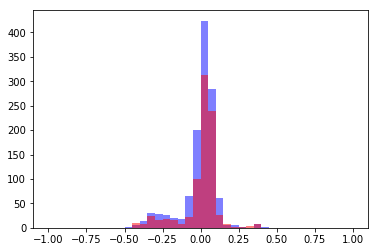

L2_S27_F3206


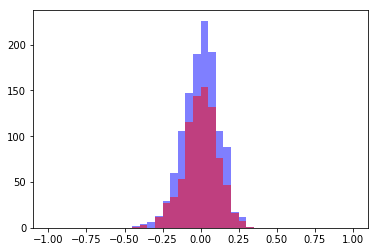

L2_S27_F3210


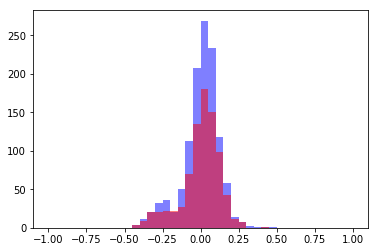

L2_S27_F3214


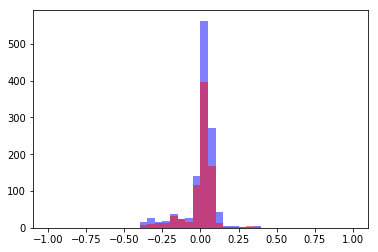

L2_S27_F3218


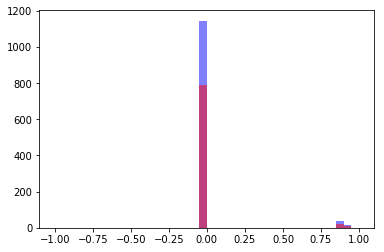

In [97]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_27.csv", 'L2_S27_D3130')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [98]:
df_pass_with_numeric.describe()

Id       L0_S0_D1      L0_S1_D26      L0_S2_D34  \
count  1.207290e+05  120729.000000  120729.000000  120729.000000   
mean   1.179292e+06       0.350976       0.351034       0.177836   
std    6.805137e+05       0.477277       0.477296       0.382376   
min    5.600000e+01       0.000000       0.000000       0.000000   
25%    5.950400e+05       0.000000       0.000000       0.000000   
50%    1.179096e+06       0.000000       0.000000       0.000000   
75%    1.764630e+06       1.000000       1.000000       0.000000   
max    2.367488e+06       1.000000       1.000000       1.000000   

           L0_S3_D70     L0_S4_D106     L0_S5_D115     L0_S6_D120  \
count  120729.000000  120729.000000  120729.000000  120729.000000   
mean        0.173438       0.178027       0.173529       0.176586   
std         0.378627       0.382537       0.378706       0.381319   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          L0_S7_D137     L0_S8_D145      ...         L2_S27_F3148  \
count  120729.000000  120729.000000      ...        120729.000000   
mean        0.174888       0.351059      ...             0.000424   
std         0.379872       0.477303      ...             0.154171   
min         0.000000       0.000000      ...            -0.030000   
25%         0.000000       0.000000      ...            -0.030000   
50%         0.000000       0.000000      ...            -0.030000   
75%         0.000000       1.000000      ...            -0.030000   
max         1.000000       1.000000      ...             0.950000   

        L2_S27_F3155   L2_S27_F3162   L2_S27_F3166   L2_S27_F3170  \
count  120729.000000  120729.000000  120729.000000  120729.000000   
mean       -0.000009       0.000144       0.000048      -0.000241   
std         0.163840       0.118856       0.109490       0.176622   
min        -0.540000      -0.519000      -0.478000      -0.035000   
25%        -0.078000      -0.078000      -0.043000      -0.035000   
50%         0.038000       0.001000       0.001000      -0.035000   
75%         0.096000       0.080000       0.060000      -0.035000   
max         0.458000       0.469000       0.515000       0.965000   

        L2_S27_F3199   L2_S27_F3206   L2_S27_F3210   L2_S27_F3214  \
count  120729.000000  120729.000000  120729.000000  120729.000000   
mean        0.000472       0.000163       0.000272       0.000198   
std         0.109799       0.114200       0.123325       0.099647   
min        -0.484000      -0.523000      -0.520000      -0.459000   
25%        -0.021000      -0.072000      -0.048000      -0.002000   
50%         0.026000       0.005000       0.016000       0.021000   
75%         0.057000       0.078000       0.073000       0.053000   
max         0.502000       0.446000       0.473000       0.489000   

        L2_S27_F3218  
count  120729.000000  
mean        0.000057  
std         0.184656  
min        -0.038000  
25%        -0.038000  
50%        -0.038000  
75%        -0.038000  
max         0.961000  

[8 rows x 70 columns]

### station 29編

L3_S29_F3339, L3_S29_F3342 の分布がちょっと違ってるように見えるが、これで識別できるか。

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145',
       ...
       'L3_S29_F3464', 'L3_S29_F3467', 'L3_S29_F3470', 'L3_S29_F3473',
       'L3_S29_F3476', 'L3_S29_F3479', 'L3_S29_F3482', 'L3_S29_F3485',
       'L3_S29_F3488', 'L3_S29_F3491'],
      dtype='object', length=109)
L3_S29_F3315


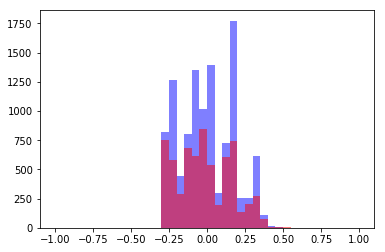

L3_S29_F3318


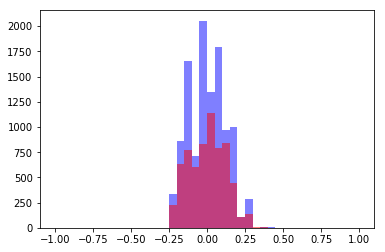

L3_S29_F3321


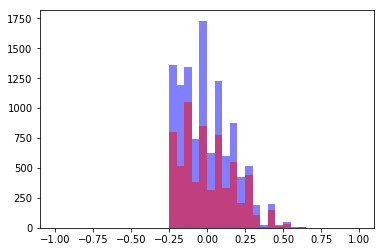

L3_S29_F3324


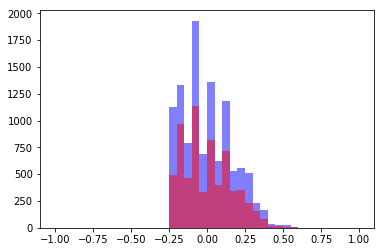

L3_S29_F3327


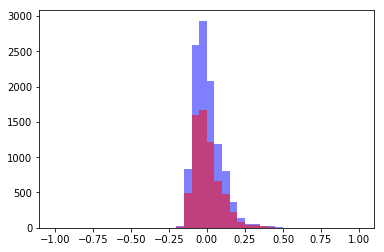

L3_S29_F3330


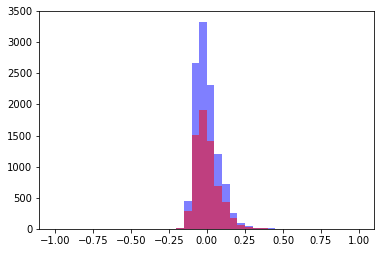

L3_S29_F3333


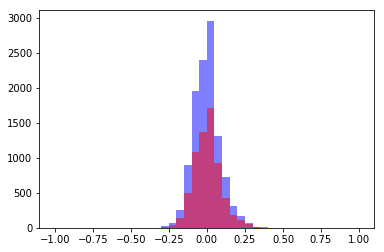

L3_S29_F3336


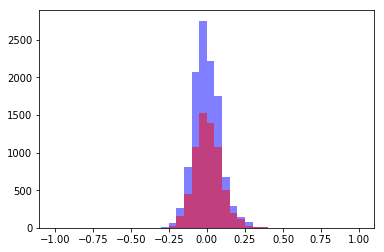

L3_S29_F3339


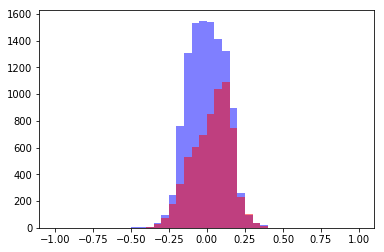

L3_S29_F3342


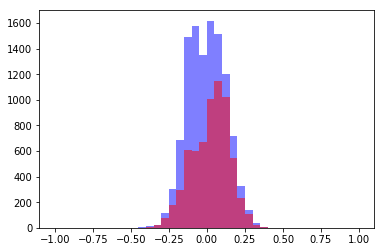

L3_S29_F3345


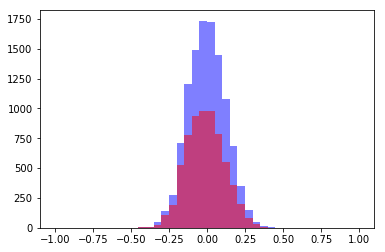

L3_S29_F3348


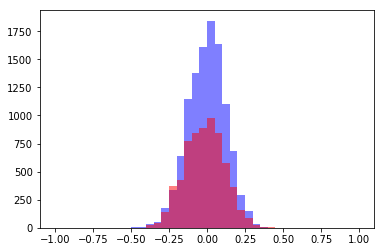

L3_S29_F3351


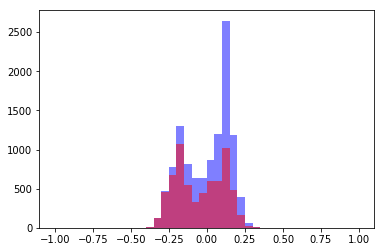

L3_S29_F3354


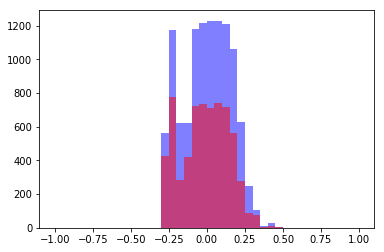

L3_S29_F3357


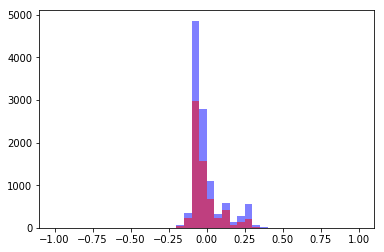

L3_S29_F3360


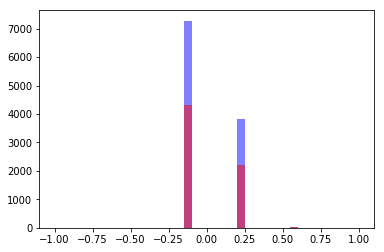

L3_S29_F3367


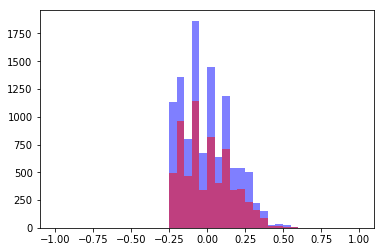

L3_S29_F3370


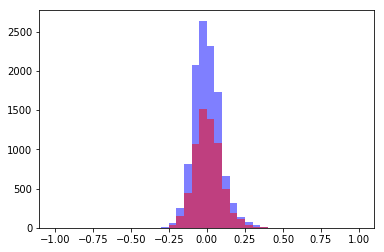

L3_S29_F3373


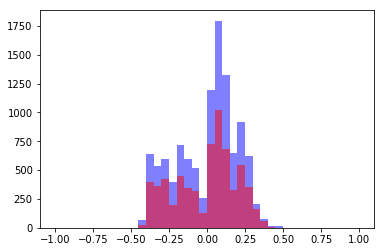

L3_S29_F3376


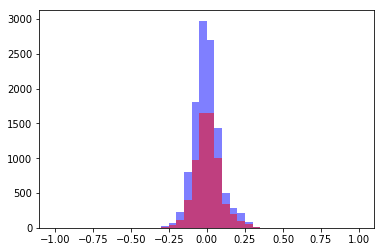

L3_S29_F3379


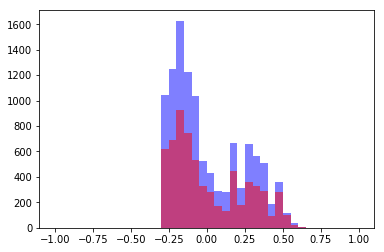

L3_S29_F3382


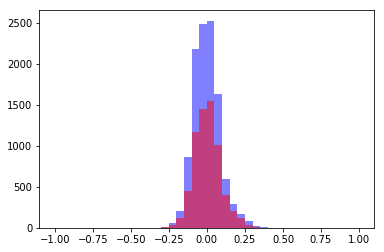

L3_S29_F3385


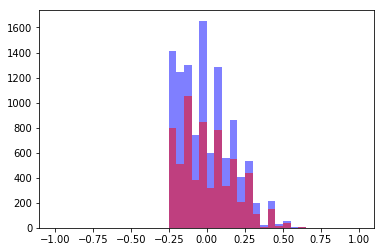

L3_S29_F3388


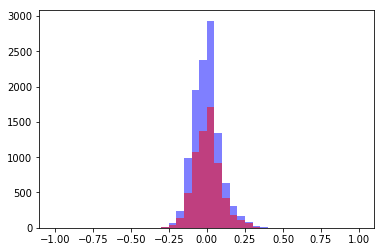

L3_S29_F3395


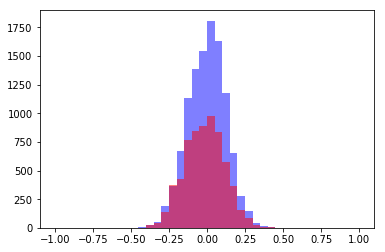

L3_S29_F3398


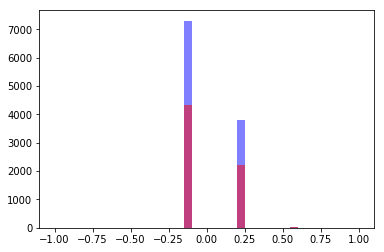

L3_S29_F3401


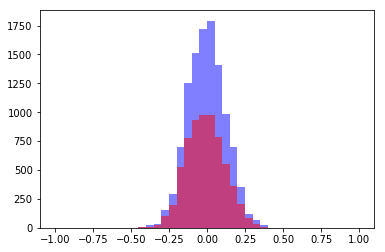

L3_S29_F3404


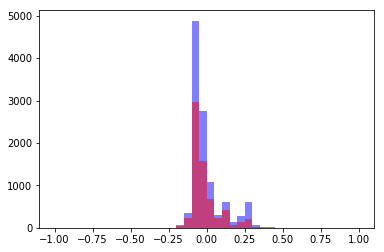

L3_S29_F3407


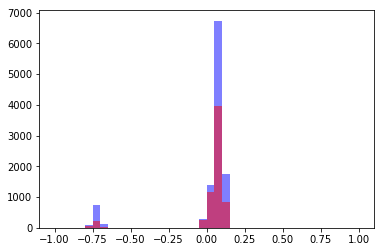

L3_S29_F3412


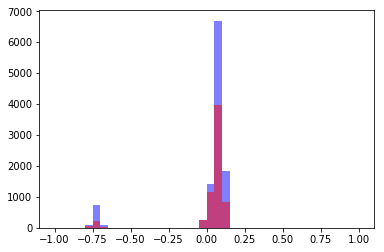

L3_S29_F3421


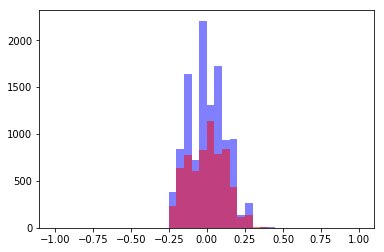

L3_S29_F3424


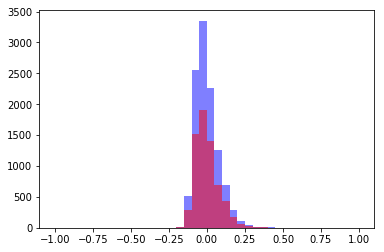

L3_S29_F3427


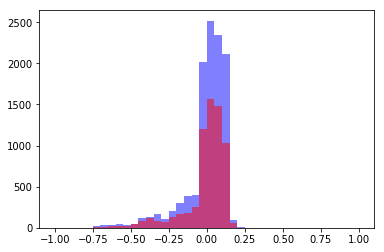

L3_S29_F3430


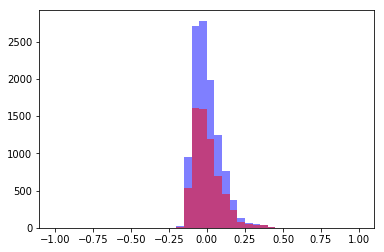

L3_S29_F3433


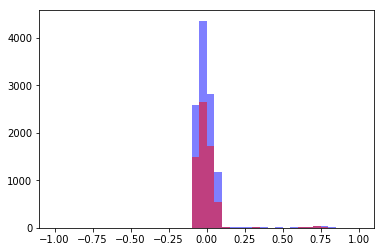

L3_S29_F3436


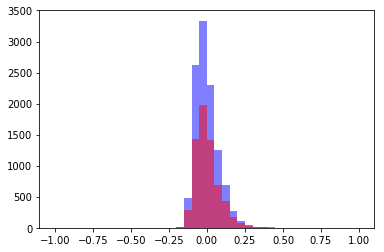

L3_S29_F3439


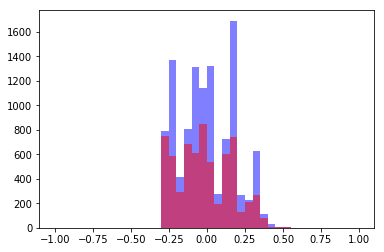

L3_S29_F3442


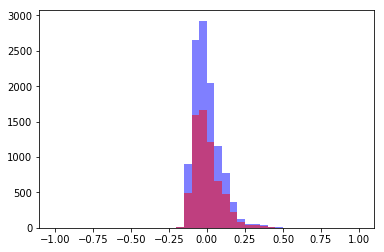

L3_S29_F3449


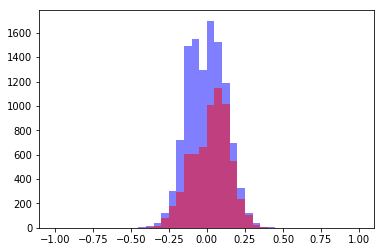

L3_S29_F3452


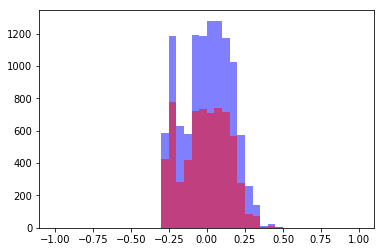

L3_S29_F3455


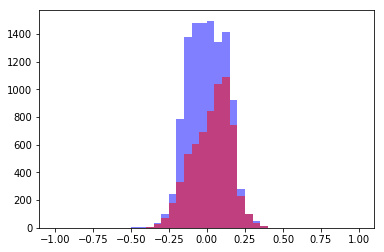

L3_S29_F3458


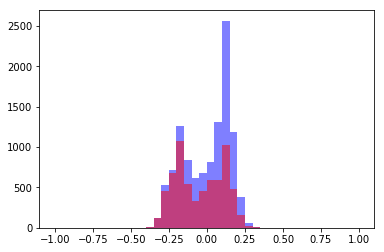

L3_S29_F3461


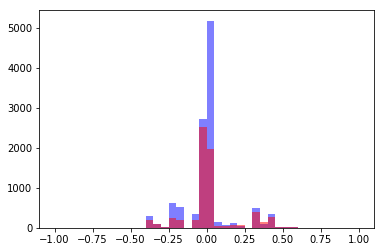

L3_S29_F3464


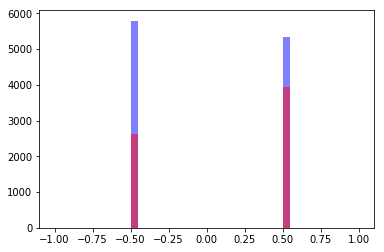

L3_S29_F3467


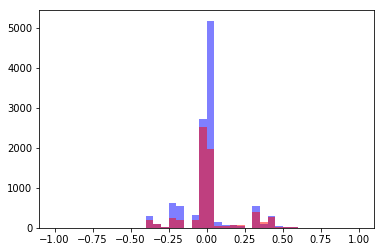

L3_S29_F3470


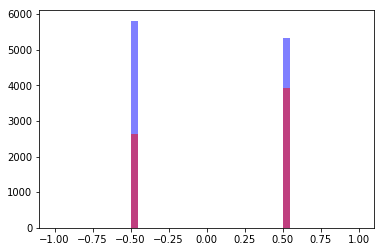

L3_S29_F3473


C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


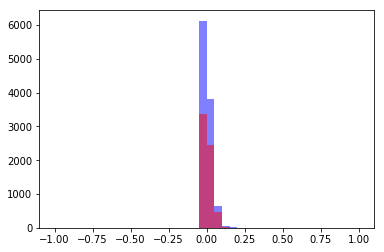

L3_S29_F3476


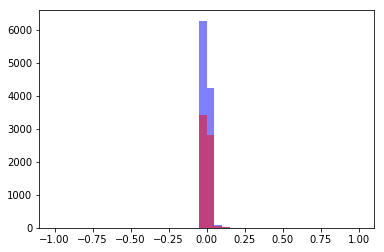

L3_S29_F3479


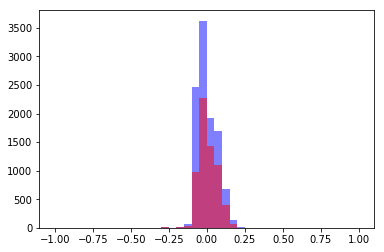

L3_S29_F3482


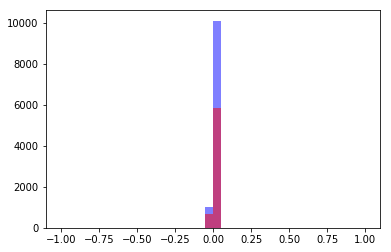

L3_S29_F3485


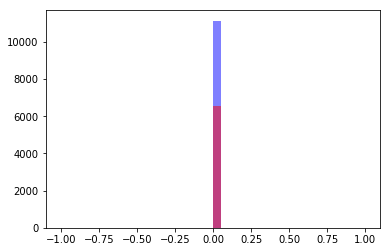

L3_S29_F3488


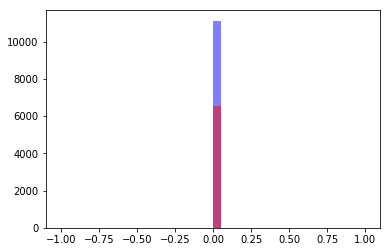

L3_S29_F3491


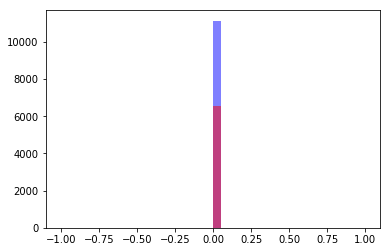

In [100]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_29.csv", 'L3_S29_D3316')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [103]:
df_pass_with_numeric.describe()

Id      L0_S0_D1     L0_S1_D26     L0_S2_D34     L0_S3_D70  \
count  1.119629e+06  1.119629e+06  1.119629e+06  1.119629e+06  1.119629e+06   
mean   1.184971e+06  5.682132e-01  5.682364e-01  2.861341e-01  2.826070e-01   
std    6.835112e+05  4.953253e-01  4.953221e-01  4.519530e-01  4.502671e-01   
min    4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.925680e+05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.186707e+06  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
75%    1.777020e+06  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
max    2.367495e+06  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

         L0_S4_D106    L0_S5_D115    L0_S6_D120    L0_S7_D137    L0_S8_D145  \
count  1.119629e+06  1.119629e+06  1.119629e+06  1.119629e+06  1.119629e+06   
mean   2.827088e-01  2.863038e-01  2.858259e-01  2.830813e-01  5.682257e-01   
std    4.503163e-01  4.520333e-01  4.518071e-01  4.504958e-01  4.953236e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
75%    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

           ...       L3_S29_F3464  L3_S29_F3467  L3_S29_F3470  L3_S29_F3473  \
count      ...       1.119629e+06  1.119629e+06  1.119629e+06  1.069324e+06   
mean       ...       3.171408e-04 -1.275297e-04  3.171408e-04 -8.693343e-06   
std        ...       4.996127e-01  1.524023e-01  4.996127e-01  2.941262e-02   
min        ...      -4.800000e-01 -3.540000e-01 -4.800000e-01 -1.330000e-01   
25%        ...      -4.800000e-01 -4.000000e-02 -4.800000e-01 -2.300000e-02   
50%        ...      -4.800000e-01  1.700000e-02 -4.800000e-01 -9.000000e-03   
75%        ...       5.200000e-01  1.700000e-02  5.200000e-01  1.500000e-02   
max        ...       5.200000e-01  6.460000e-01  5.200000e-01  8.670000e-01   

       L3_S29_F3476  L3_S29_F3479  L3_S29_F3482  L3_S29_F3485  L3_S29_F3488  \
count  1.069324e+06  1.069324e+06  1.119629e+06  1.119629e+06  1.119629e+06   
mean  -5.585678e-05  3.040145e-05 -8.435116e-05  6.430702e-06  4.018027e-05   
std    2.051277e-02  6.340853e-02  1.539043e-03  7.261640e-04  1.400104e-03   
min   -1.070000e-01 -4.510000e-01 -3.900000e-02  0.000000e+00  0.000000e+00   
25%   -1.700000e-02 -4.700000e-02  0.000000e+00  0.000000e+00  0.000000e+00   
50%   -9.000000e-03 -1.600000e-02  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.500000e-02  4.700000e-02  0.000000e+00  0.000000e+00  0.000000e+00   
max    8.930000e-01  5.490000e-01  7.490000e-01  5.570000e-01  7.270000e-01   

       L3_S29_F3491  
count  1.119629e+06  
mean   2.851659e-05  
std    2.486520e-03  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

[8 rows x 109 columns]

In [106]:
df_tmp = df_pass_with_numeric[df_pass_with_numeric['L3_S29_F3491']== 1]
df_tmp['Response']

1061220    0
Name: Response, dtype: int64

### station30 編
これといった特徴はない感じ。

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145',
       ...
       'L3_S30_F3784', 'L3_S30_F3789', 'L3_S30_F3794', 'L3_S30_F3799',
       'L3_S30_F3804', 'L3_S30_F3809', 'L3_S30_F3814', 'L3_S30_F3819',
       'L3_S30_F3824', 'L3_S30_F3829'],
      dtype='object', length=124)
L3_S30_F3494


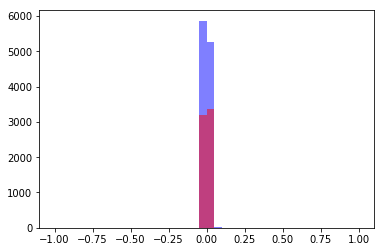

L3_S30_F3499


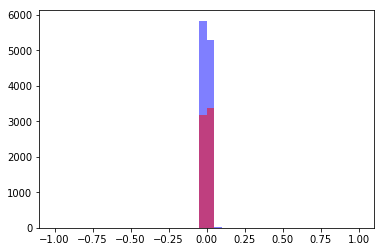

L3_S30_F3504


C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Tomonobu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


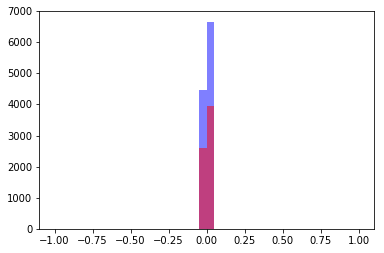

L3_S30_F3509


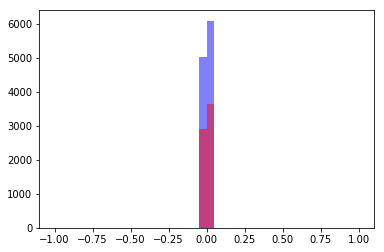

L3_S30_F3514


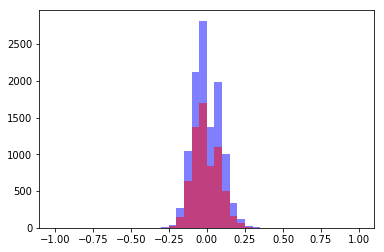

L3_S30_F3519


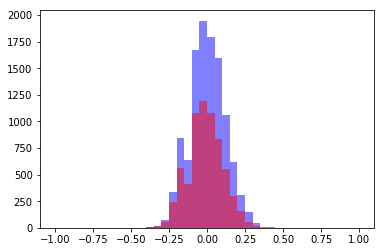

L3_S30_F3524


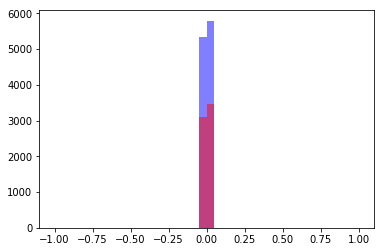

L3_S30_F3529


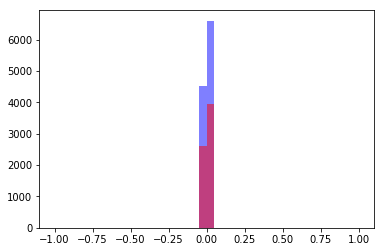

L3_S30_F3534


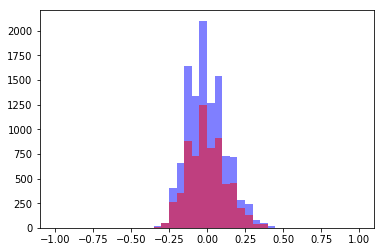

L3_S30_F3539


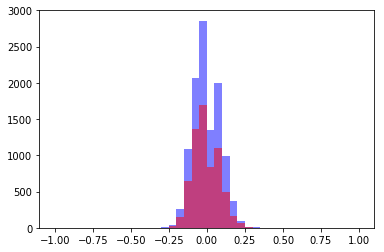

L3_S30_F3544


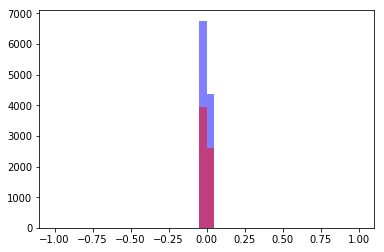

L3_S30_F3549


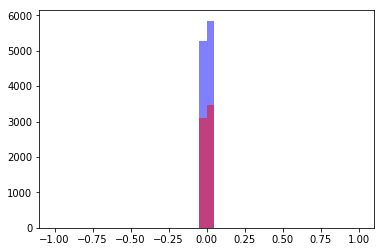

L3_S30_F3554


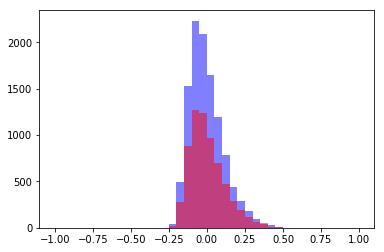

L3_S30_F3559


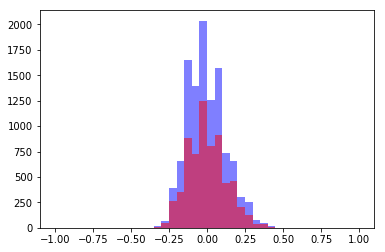

L3_S30_F3564


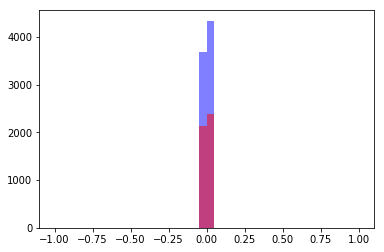

L3_S30_F3569


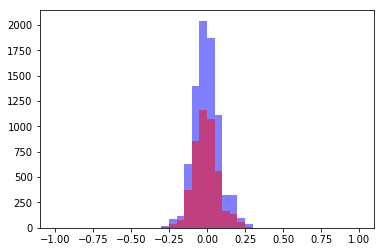

L3_S30_F3574


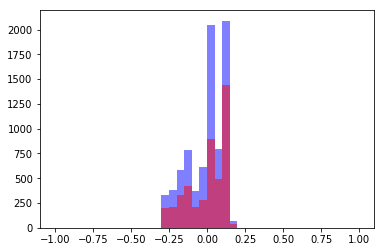

L3_S30_F3579


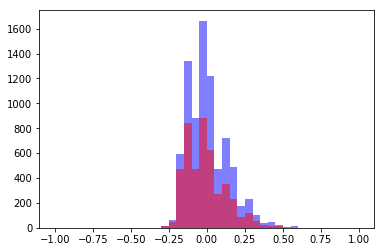

L3_S30_F3584


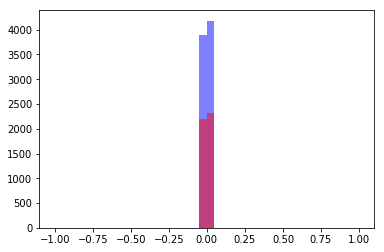

L3_S30_F3589


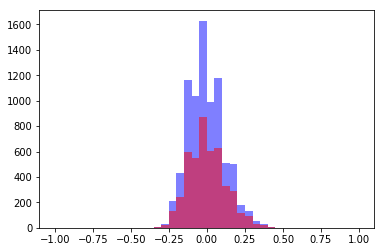

L3_S30_F3594


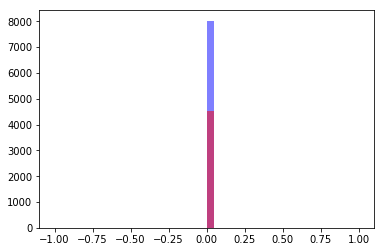

L3_S30_F3599


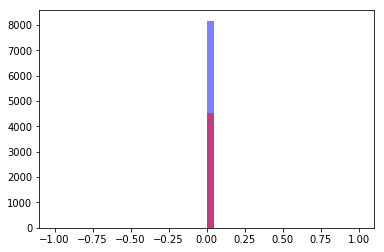

L3_S30_F3604


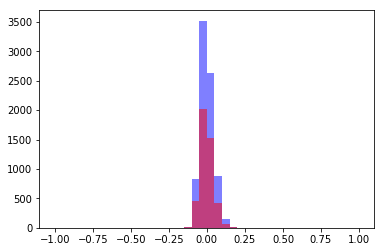

L3_S30_F3609


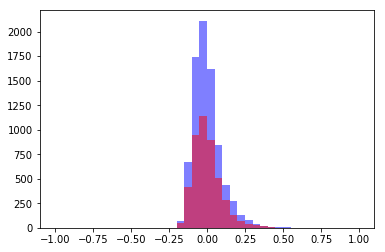

L3_S30_F3614


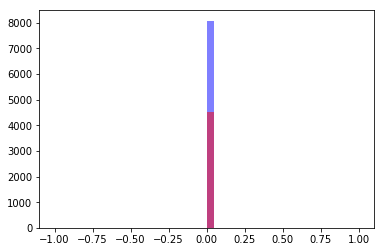

L3_S30_F3619


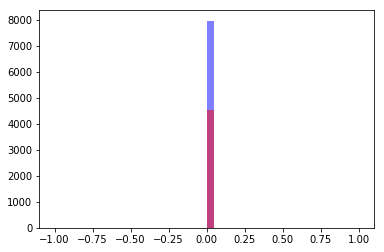

L3_S30_F3624


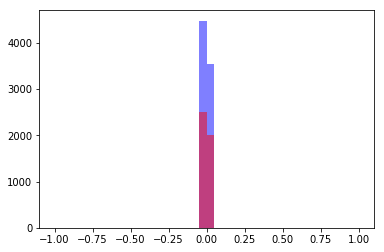

L3_S30_F3629


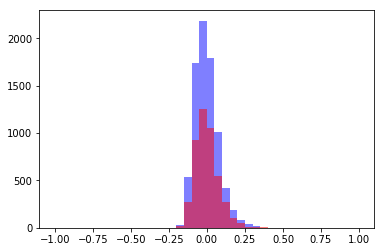

L3_S30_F3634


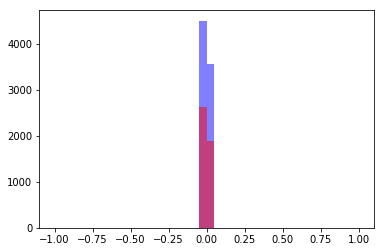

L3_S30_F3639


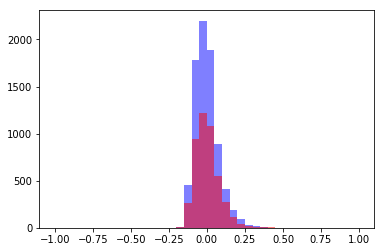

L3_S30_F3644


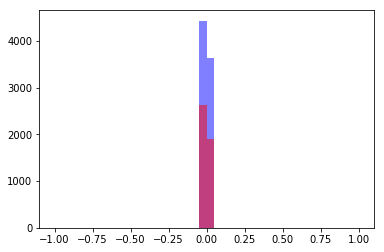

L3_S30_F3649


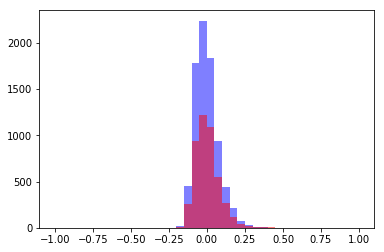

L3_S30_F3654


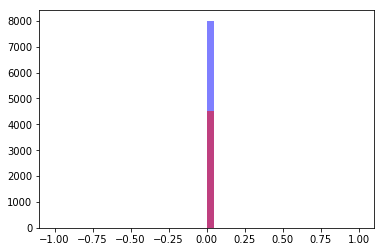

L3_S30_F3659


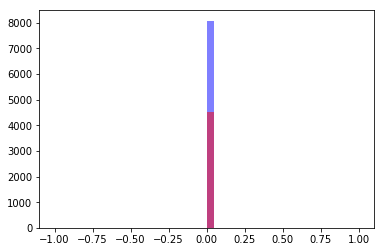

L3_S30_F3664


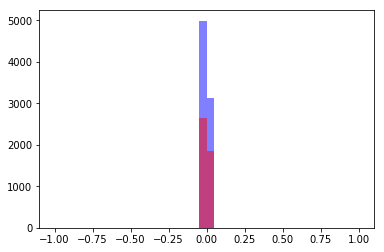

L3_S30_F3669


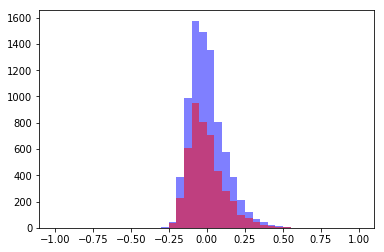

L3_S30_F3674


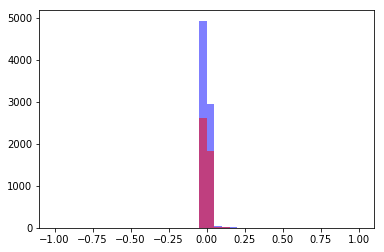

L3_S30_F3679


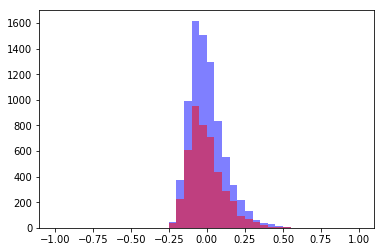

L3_S30_F3684


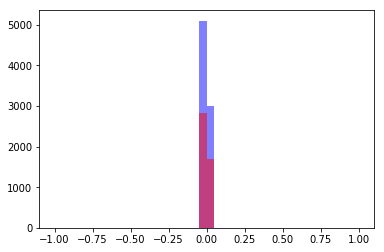

L3_S30_F3689


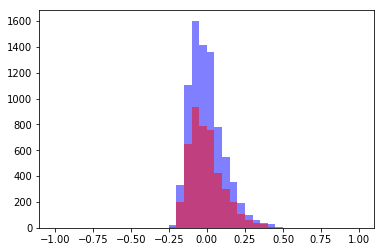

L3_S30_F3694


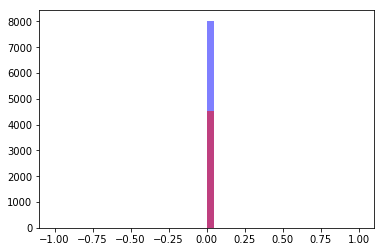

L3_S30_F3699


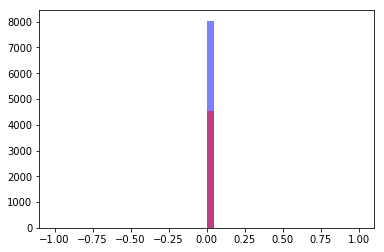

L3_S30_F3704


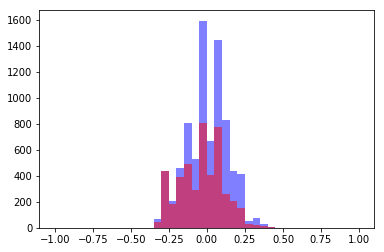

L3_S30_F3709


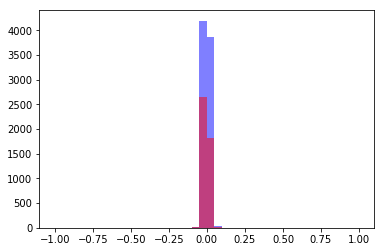

L3_S30_F3714


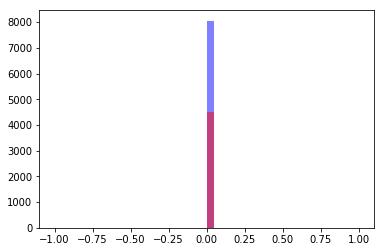

L3_S30_F3719


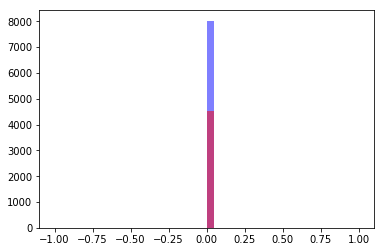

L3_S30_F3724


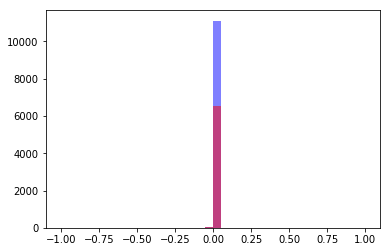

L3_S30_F3729


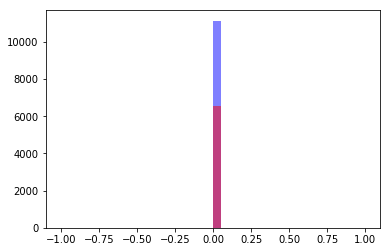

L3_S30_F3734


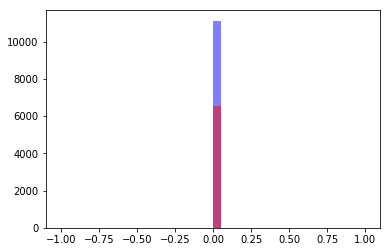

L3_S30_F3739


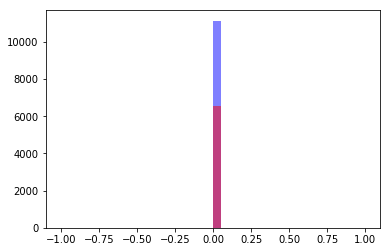

L3_S30_F3744


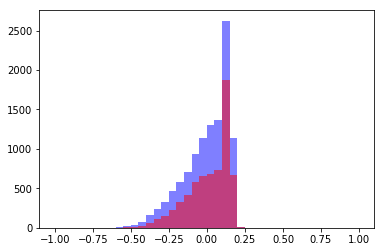

L3_S30_F3749


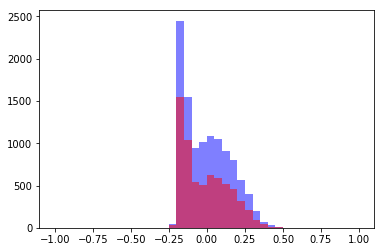

L3_S30_F3754


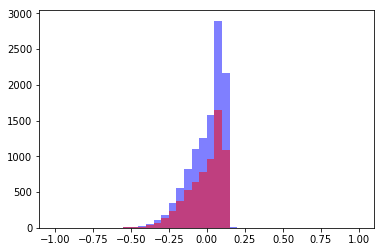

L3_S30_F3759


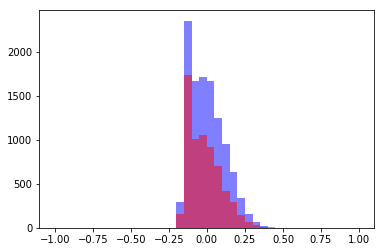

L3_S30_F3764


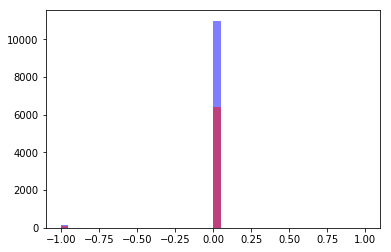

L3_S30_F3769


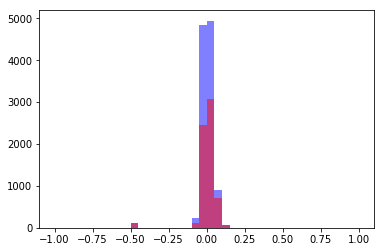

L3_S30_F3774


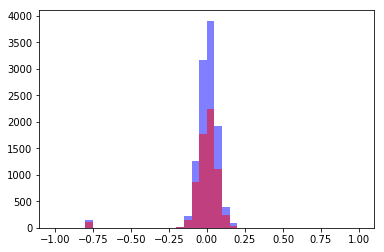

L3_S30_F3779


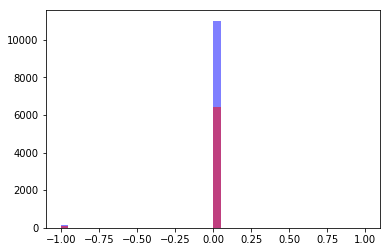

L3_S30_F3784


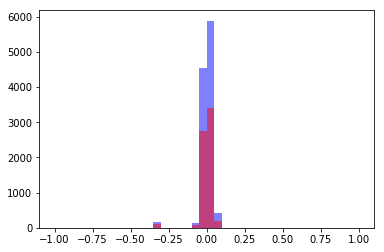

L3_S30_F3789


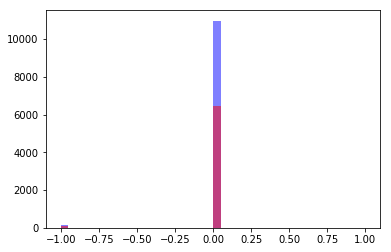

L3_S30_F3794


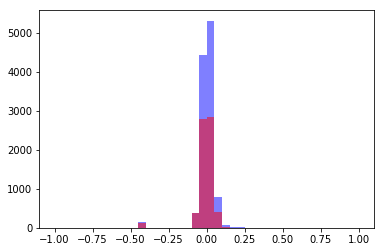

L3_S30_F3799


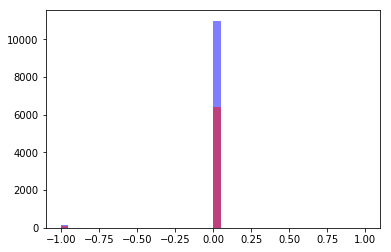

L3_S30_F3804


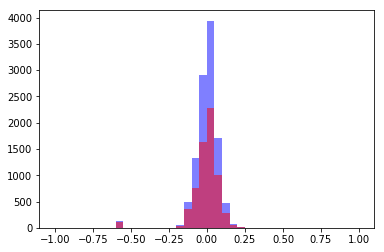

L3_S30_F3809


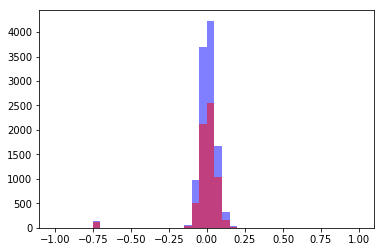

L3_S30_F3814


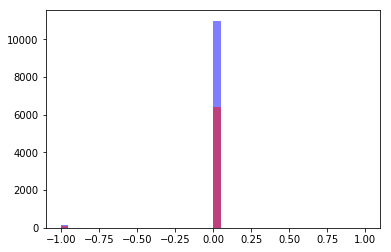

L3_S30_F3819


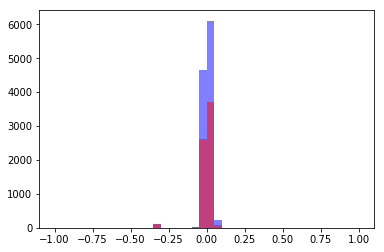

L3_S30_F3824


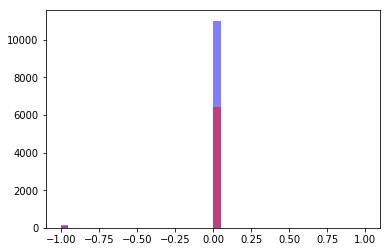

L3_S30_F3829


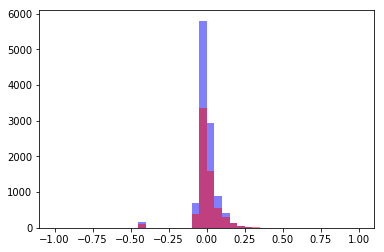

In [108]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_30.csv", 'L3_S30_D3496')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

### station31 編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S31_F3834', 'L3_S31_F3838', 'L3_S31_F3842', 'L3_S31_F3846'],
   

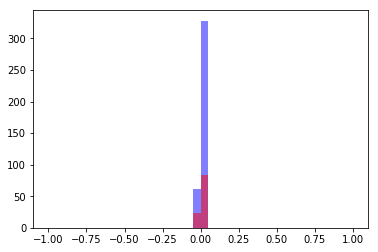

L3_S31_F3838


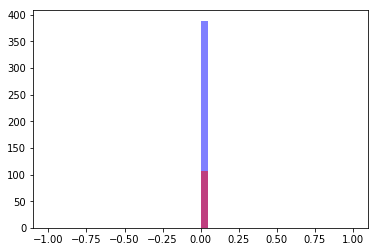

L3_S31_F3842


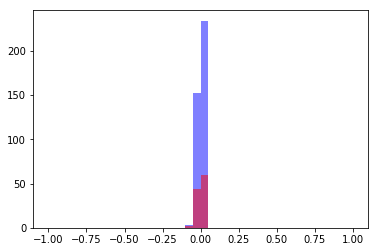

L3_S31_F3846


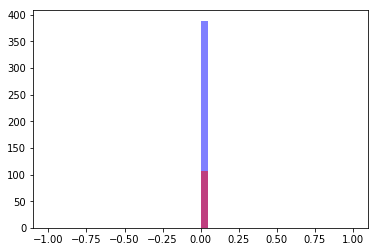

In [110]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_31.csv", 'L3_S31_D3836')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

### statoin 32 編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S32_F3850'],
      dtype='object')
L3_S32_F3850


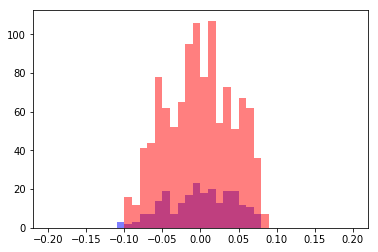

In [113]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_32.csv", 'L3_S32_D3852')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric, rangeL=-0.2, rangeH=0.2)

時間との関係を見てみる。
station32 は、time = 700 あたりで、5個～10個に1個の割合で不良を作っていることがわかる。

In [114]:
df_pass_with_numeric.columns

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S32_F3850'],
      dtype='object')

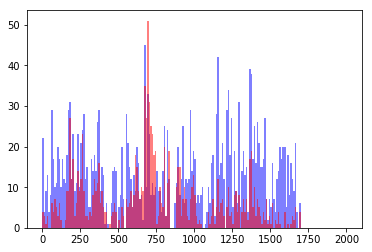

In [124]:
df_tmp = df_pass_with_numeric[['StartTime', 'Response']]
df_disp1 = df_tmp[df_tmp['Response'] == 0].sample(frac=0.1)
df_disp2 = df_tmp[df_tmp['Response'] == 1]
plt.hist(df_disp1['StartTime'], label = "0", bins = 200, range = (0, 2000),alpha = 0.5, color = "blue")
plt.hist(df_disp2['StartTime'], label = "1", bins = 200, range = (0, 2000), alpha = 0.5, color = "red")
plt.show()
        

### statoin 33編


Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S33_F3855', 'L3_S33_F3857', 'L3_S33_F3859', 'L3_S33_F3861',
    

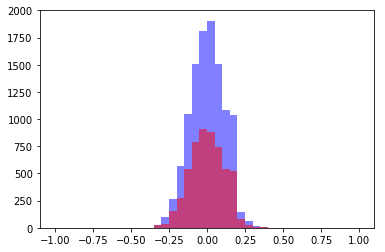

L3_S33_F3857


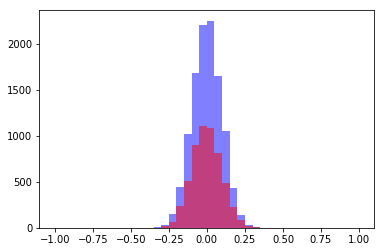

L3_S33_F3859


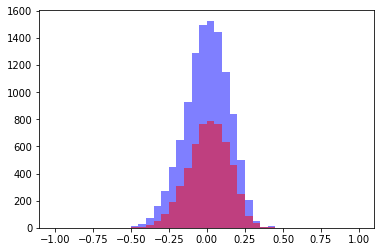

L3_S33_F3861


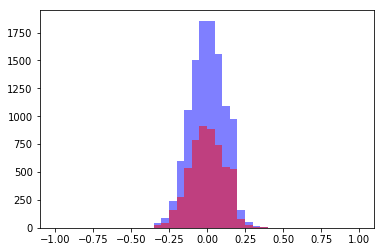

L3_S33_F3863


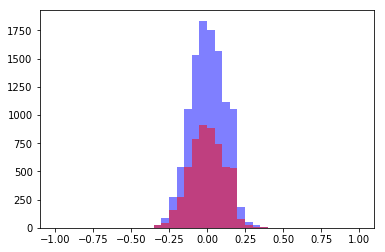

L3_S33_F3865


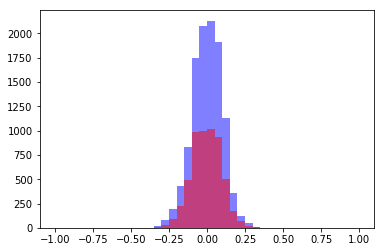

L3_S33_F3867


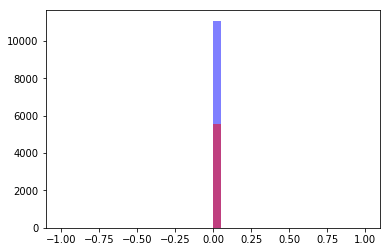

L3_S33_F3869


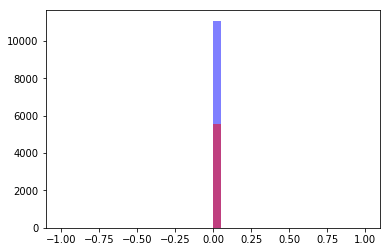

L3_S33_F3871


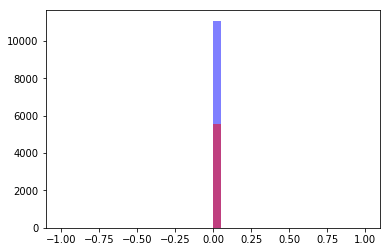

L3_S33_F3873


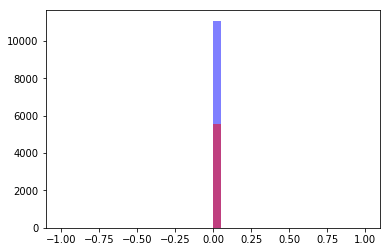

In [38]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_33.csv", 'L3_S33_D3856')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [33]:
df_pass_with_numeric.describe()

Id      L0_S0_D1     L0_S1_D26     L0_S2_D34     L0_S3_D70  \
count  1.114695e+06  1.114695e+06  1.114695e+06  1.114695e+06  1.114695e+06   
mean   1.185014e+06  5.673588e-01  5.673866e-01  2.856790e-01  2.822108e-01   
std    6.834855e+05  4.954422e-01  4.954385e-01  4.517374e-01  4.500756e-01   
min    4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.925645e+05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.186815e+06  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
75%    1.777042e+06  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
max    2.367495e+06  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

         L0_S4_D106    L0_S5_D115    L0_S6_D120    L0_S7_D137    L0_S8_D145  \
count  1.114695e+06  1.114695e+06  1.114695e+06  1.114695e+06  1.114695e+06   
mean   2.822817e-01  2.858782e-01  2.853956e-01  2.826594e-01  5.673731e-01   
std    4.501099e-01  4.518319e-01  4.516028e-01  4.502924e-01  4.954403e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
75%    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

           ...       L3_S33_F3855  L3_S33_F3857  L3_S33_F3859  L3_S33_F3861  \
count      ...       1.114695e+06  1.114695e+06  1.114695e+06  1.114695e+06   
mean       ...      -1.201782e-04 -4.347378e-05  3.119329e-05 -1.201782e-04   
std        ...       1.071156e-01  9.449016e-02  1.388562e-01  1.071156e-01   
min        ...      -4.830000e-01 -5.240000e-01 -5.300000e-01 -4.830000e-01   
25%        ...      -7.400000e-02 -6.400000e-02 -8.900000e-02 -7.400000e-02   
50%        ...       1.700000e-02 -1.000000e-03  8.000000e-03  1.700000e-02   
75%        ...       6.200000e-02  6.300000e-02  9.900000e-02  6.200000e-02   
max        ...       5.170000e-01  4.760000e-01  4.700000e-01  5.170000e-01   

       L3_S33_F3863  L3_S33_F3865  L3_S33_F3867  L3_S33_F3869  L3_S33_F3871  \
count  1.114695e+06  1.114695e+06  1.114695e+06  1.114695e+06  1.114695e+06   
mean  -1.201782e-04 -4.512176e-05  2.033740e-06  4.966650e-05  1.016511e-05   
std    1.071156e-01  9.687610e-02  8.559549e-04  3.142600e-03  1.032909e-03   
min   -4.830000e-01 -3.390000e-01 -1.000000e-03  0.000000e+00  0.000000e+00   
25%   -7.400000e-02 -6.300000e-02  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.700000e-02  2.000000e-03  0.000000e+00  0.000000e+00  0.000000e+00   
75%    6.200000e-02  6.700000e-02  0.000000e+00  0.000000e+00  0.000000e+00   
max    5.170000e-01  6.610000e-01  7.300000e-01  9.960000e-01  1.000000e+00   

       L3_S33_F3873  
count  1.114695e+06  
mean   2.447844e-05  
std    1.496467e-03  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

[8 rows x 66 columns]

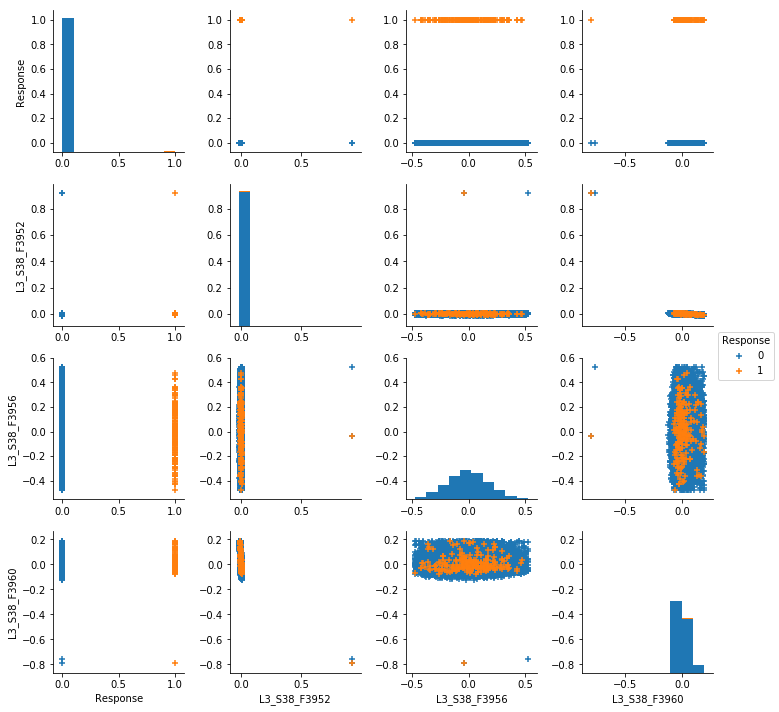

In [82]:
view_cols = df_numeric.columns.delete(0)
view_cols = view_cols.insert(0 ,'Response')
df_tmp = df_pass_with_numeric[view_cols]
sns.pairplot(df_tmp, hue='Response', markers="+")
plt.show()

### station34 編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S34_F3876', 'L3_S34_F3878', 'L3_S34_F3880', 'L3_S34_F3882'],
   

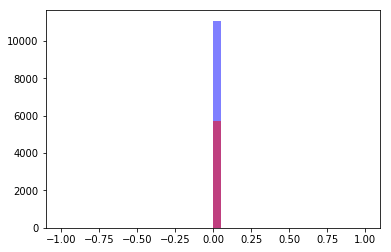

L3_S34_F3878


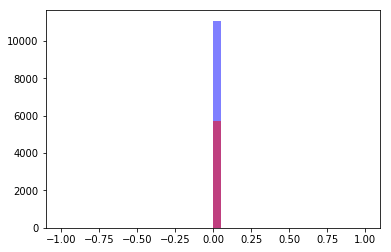

L3_S34_F3880


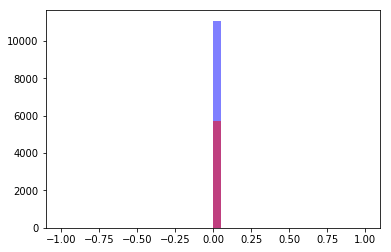

L3_S34_F3882


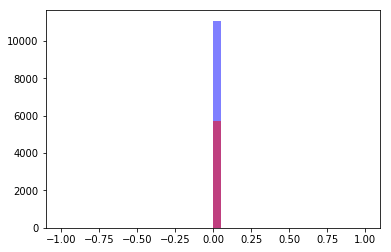

In [40]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_34.csv", 'L3_S34_D3875')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [41]:
df_pass_with_numeric.describe()

Id      L0_S0_D1     L0_S1_D26     L0_S2_D34     L0_S3_D70  \
count  1.115118e+06  1.115118e+06  1.115118e+06  1.115118e+06  1.115118e+06   
mean   1.185077e+06  5.674225e-01  5.674485e-01  2.857303e-01  2.822186e-01   
std    6.834920e+05  4.954336e-01  4.954300e-01  4.517617e-01  4.500794e-01   
min    4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.926262e+05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.186911e+06  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
75%    1.777109e+06  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
max    2.367495e+06  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

         L0_S4_D106    L0_S5_D115    L0_S6_D120    L0_S7_D137    L0_S8_D145  \
count  1.115118e+06  1.115118e+06  1.115118e+06  1.115118e+06  1.115118e+06   
mean   2.823136e-01  2.859088e-01  2.853940e-01  2.827225e-01  5.674341e-01   
std    4.501253e-01  4.518463e-01  4.516021e-01  4.503229e-01  4.954320e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
75%    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

           ...       L3_S49_D4208  L3_S50_D4242  L3_S51_D4255     StartTime  \
count      ...          1115118.0     1115118.0     1115118.0  1.115118e+06   
mean       ...                0.0           0.0           0.0  8.394602e+02   
std        ...                0.0           0.0           0.0  4.687474e+02   
min        ...                0.0           0.0           0.0  0.000000e+00   
25%        ...                0.0           0.0           0.0  4.262600e+02   
50%        ...                0.0           0.0           0.0  8.390100e+02   
75%        ...                0.0           0.0           0.0  1.213000e+03   
max        ...                0.0           0.0           0.0  1.713710e+03   

            EndTime      Response  L3_S34_F3876  L3_S34_F3878  L3_S34_F3880  \
count  1.115118e+06  1.115118e+06  1.115118e+06  1.115118e+06  1.115118e+06   
mean   8.503425e+02  5.127708e-03  3.066043e-06  2.050007e-06  5.942869e-06   
std    4.683930e+02  7.142422e-02  1.325410e-03  9.621226e-04  9.989299e-04   
min    4.600000e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.753300e+02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    8.802400e+02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.214050e+03  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.718480e+03  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       L3_S34_F3882  
count  1.115118e+06  
mean   4.493785e-05  
std    2.242799e-03  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    7.380000e-01  

[8 rows x 60 columns]

### station35編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S35_F3884', 'L3_S35_F3889', 'L3_S35_F3894', 'L3_S35_F3896',
    

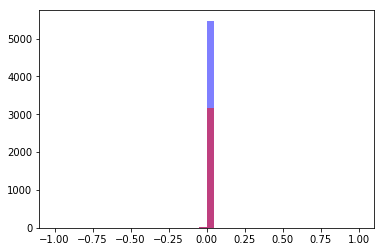

L3_S35_F3889


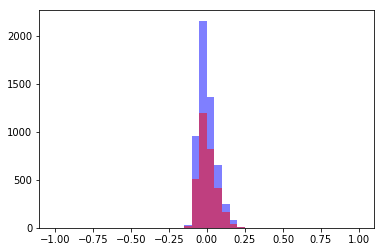

L3_S35_F3894


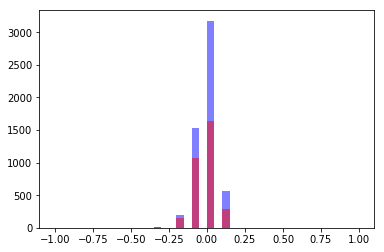

L3_S35_F3896


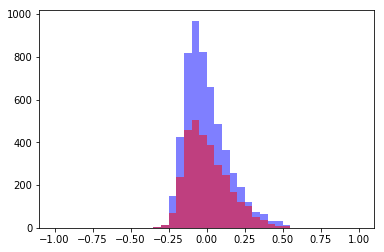

L3_S35_F3898


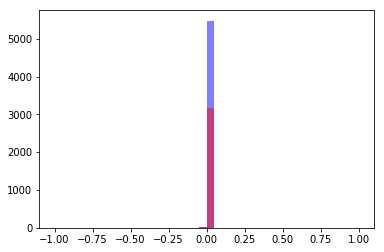

L3_S35_F3903


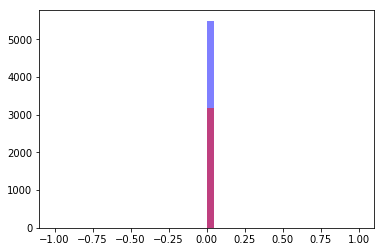

L3_S35_F3908


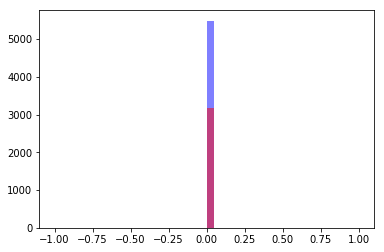

L3_S35_F3913


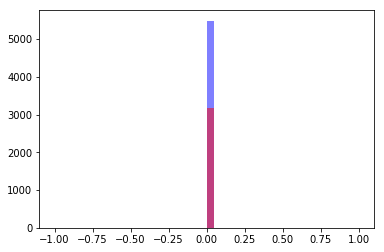

In [42]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_35.csv", 'L3_S35_D3886')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

### station36編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S36_F3918', 'L3_S36_F3920', 'L3_S36_F3922', 'L3_S36_F3924',
    

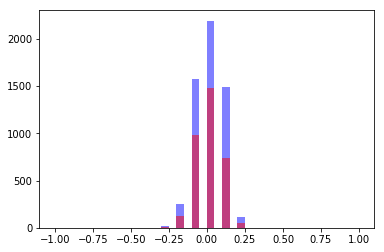

L3_S36_F3920


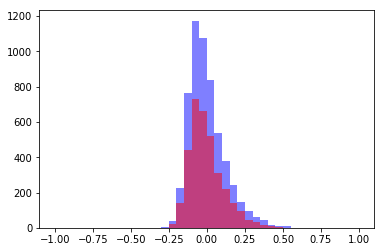

L3_S36_F3922


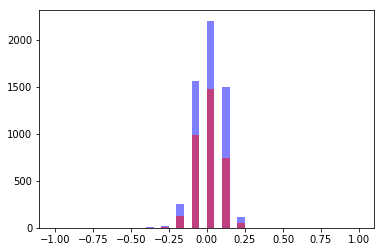

L3_S36_F3924


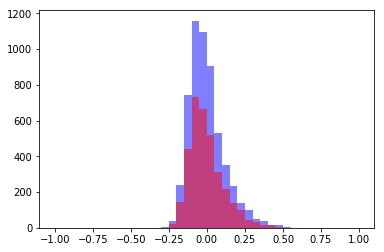

L3_S36_F3926


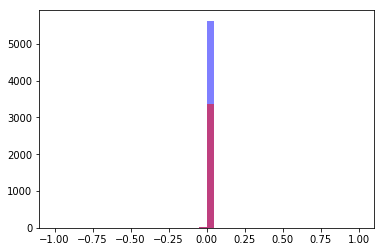

L3_S36_F3930


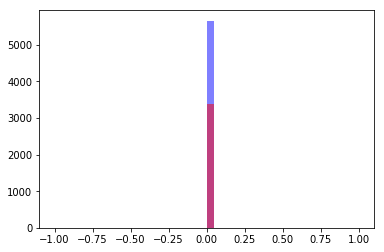

L3_S36_F3934


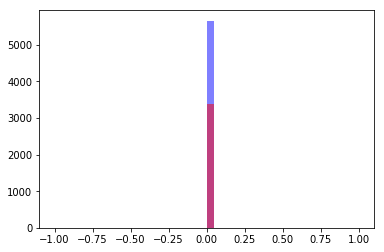

L3_S36_F3938


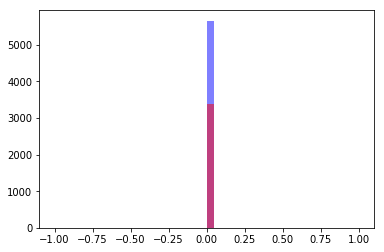

In [45]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_36.csv", 'L3_S36_D3919')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

### station37編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S37_F3944', 'L3_S37_F3946', 'L3_S37_F3948', 'L3_S37_F3950'],
   

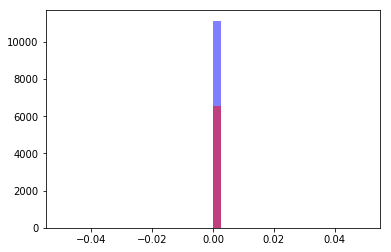

L3_S37_F3946


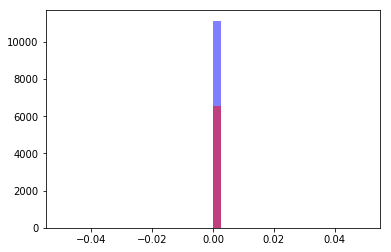

L3_S37_F3948


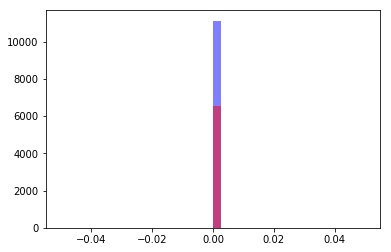

L3_S37_F3950


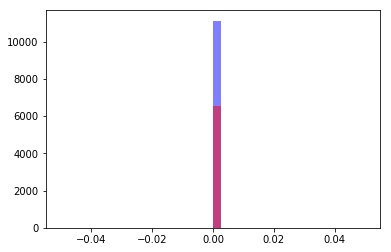

In [47]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_37.csv", 'L3_S37_D3942')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [48]:
df_numeric.describe()

Id  L3_S37_F3944  L3_S37_F3946  L3_S37_F3948  L3_S37_F3950
count  1.183747e+06  1.120394e+06  1.120394e+06  1.120394e+06  1.120394e+06
mean   1.184050e+06  7.363481e-07  3.595164e-06  2.454404e-05  3.733954e-05
std    6.834348e+05  1.877606e-04  9.905752e-04  1.216175e-03  2.282694e-03
min    4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    5.921385e+05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    1.184628e+06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    1.775674e+06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
max    2.367495e+06  1.570000e-01  5.260000e-01  5.420000e-01  8.200000e-01

In [51]:
df_pass_with_numeric[df_pass_with_numeric['L3_S37_F3950'] !=0]

Id  L0_S0_D1  L0_S1_D26  L0_S2_D34  L0_S3_D70  L0_S4_D106  \
21            55         0          0          0          0           0   
174          353         1          1          1          0           0   
355          692         1          1          0          1           0   
679         1346         1          1          1          0           0   
719         1432         1          1          0          1           0   
819         1653         1          1          1          0           1   
1116        2271         0          0          0          0           0   
1238        2511         0          0          0          0           0   
1246        2523         1          1          0          1           1   
1436        2910         0          0          0          0           0   
1563        3184         0          0          0          0           0   
1846        3759         1          1          1          0           0   
1867        3801         0          0          0          0           0   
1966        3990         1          1          0          1           1   
2120        4282         1          1          1          0           1   
2174        4380         1          1          1          0           0   
2199        4426         0          0          0          0           0   
3091        6225         1          1          1          0           0   
3535        7049         1          1          0          1           1   
3625        7240         1          1          0          1           0   
3926        7854         1          1          1          0           1   
4008        8017         1          1          1          0           0   
4028        8054         1          1          1          0           1   
4155        8292         0          0          0          0           0   
4264        8499         1          1          1          0           0   
4284        8535         1          1          0          1           0   
4317        8609         1          1          1          0           0   
4328        8627         1          1          0          1           0   
5248       10439         1          1          0          1           1   
5434       10809         1          1          0          1           1   
...          ...       ...        ...        ...        ...         ...   
1180724  2361432         0          0          0          0           0   
1180984  2361911         0          0          0          0           0   
1181058  2362082         1          1          0          1           1   
1181071  2362109         1          1          0          1           0   
1181166  2362304         0          0          0          0           0   
1181379  2362727         1          1          0          1           0   
1181619  2363239         1          1          0          1           0   
1181745  2363491         0          0          0          0           0   
1181777  2363550         0          0          0          0           0   
1181783  2363560         1          1          1          0           0   
1181868  2363727         1          1          0          1           0   
1181890  2363781         1          1          1          0           0   
1181891  2363782         1          1          1          0           0   
1181911  2363819         1          1          0          1           0   
1182143  2364266         1          1          0          1           1   
1182240  2364458         0          0          0          0           0   
1182319  2364639         1          1          1          0           0   
1182320  2364640         1          1          1          0           0   
1182335  2364673         1          1          0          1           0   
1182509  2365044         0          0          0          0           0   
1182607  2365236         0          0          0          0           0   
1182882  2365797         0          0  

### station 38編

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255', 'StartTime', 'EndTime', 'Response',
       'L3_S38_F3952', 'L3_S38_F3956', 'L3_S38_F3960'],
      dtype='object

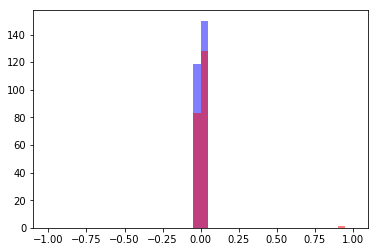

L3_S38_F3956


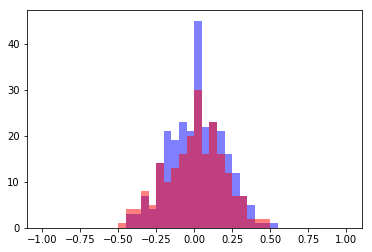

L3_S38_F3960


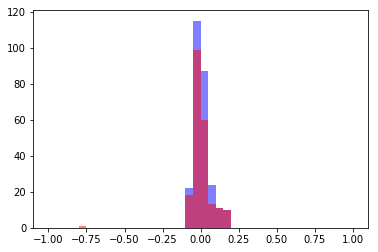

In [52]:
df_numeric, df_pass_with_numeric = generate_df_one("./train_numeric_station_38.csv", 'L3_S38_D3953')
print(df_pass_with_numeric.columns)
plot_features(df_numeric, df_pass_with_numeric)

In [ ]:
plot_features(df_numeric, df_pass_with_numeric)